In [1]:
#참고 : https://bo-10000.tistory.com/202
#참고 : https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=UserWarning)

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data.xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]

X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['JLA']].values

def split_data(random_state):
    return train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)

# Custom Neural Network Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=32):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()

# Optuna objective function
def objective(trial):
    # 하이퍼파라미터 검색 공간
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    hidden_neurons = trial.suggest_int('hidden_neurons', 8, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 500, 3000)
    batch_size = trial.suggest_int('batch_size', 32, 128)
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-3, log=True)
    patience = trial.suggest_int('patience', 10, 100)

    # 데이터 분할
    X_train, X_test, Y_train, Y_test = split_data(random_state)

    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    r2_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

        # 모델 학습
        model = TorchRegressor(
            hidden_layers=hidden_layers,
            hidden_neurons=hidden_neurons,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            batch_size=batch_size,
            weight_decay=weight_decay,
            patience=patience
        )
        model.fit(X_train_fold, Y_train_fold)
        y_pred_val = model.predict(X_val_fold)

        # R² Score 계산
        r2_val = r2_score(Y_val_fold, y_pred_val)

        if r2_val < 0.6:
            raise optuna.exceptions.TrialPruned()

        r2_scores.append(r2_val)

    # K-Fold 평균 R2 Score를 반환
    return np.mean(r2_scores)

# 여러 random_state에 대해 Optuna 실행
results = []

for random_state in range(101):  # 다양한 random_state에 대해 반복
    print(f"Running Optuna for random_state: {random_state}")
    
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=20, interval_steps=5)
    
    # Optuna study 실행
    study = optuna.create_study(direction="maximize", pruner=pruner)
    
    # 최대 30번의 trial을 수행하지만, 성공적인 trial이 없으면 다음 random_state로 넘어감
    study.optimize(objective, n_trials=30)

    # 최적의 하이퍼파라미터와 성능 저장
    try:
        if study.best_trial:
            best_params = study.best_params
            best_r2 = study.best_value
            results.append({"random_state": random_state, "best_params": best_params, "best_r2": best_r2})
    except ValueError:
        print(f"No successful trials for random_state {random_state}, skipping.")


# 결과 요약
if results:
    results_df = pd.DataFrame(results)
    # 최적의 random_state와 해당 결과 출력
    best_result = results_df.loc[results_df['best_r2'].idxmax()]
    print("Best random_state:", best_result['random_state'])
    print("Best R2 Score:", best_result['best_r2'])
    print("Best Hyperparameters:", best_result['best_params'])
    # 결과 저장
    results_df.to_csv("JLA2_optuna_results_random_states.csv", index=False)
else:
    print("No successful trials found for any random_state.")

# 모델 재학습 및 성능 평가 (최적 하이퍼파라미터 사용)
if results:
    best_random_state = int(best_result['random_state'])
    best_params = best_result['best_params']

    X_train, X_test, Y_train, Y_test = split_data(best_random_state)

    model = TorchRegressor(
        hidden_layers=best_params['hidden_layers'],
        hidden_neurons=best_params['hidden_neurons'],
        learning_rate=best_params['learning_rate'],
        num_epochs=best_params['num_epochs'],
        batch_size=best_params['batch_size'],
        weight_decay=best_params['weight_decay'],
        patience=best_params['patience']
    )

    # 모델 학습
    model.fit(X_train, Y_train)

    # 예측
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # R² 점수 계산
    r2_test = r2_score(Y_test, y_pred_test)
    r2_train = r2_score(Y_train, y_pred_train)

    # 결과 출력
    print(f"Random State: {best_random_state}")
    print(f"Best Parameters: {best_params}")
    print(f"Train R²: {r2_train}")
    print(f"Test R²: {r2_test}")

    # 모델 저장(Optional)

    torch.save(model, "best_JLA2_model.pt")


c:\Users\User.DESKTOP-SJB33S8\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-18 16:16:48,527] A new study created in memory with name: no-name-09f14c95-9e2a-4ddb-8342-7693e09b618c


Running Optuna for random_state: 0


[I 2024-12-18 16:16:58,534] Trial 0 pruned. 
[I 2024-12-18 16:17:25,683] Trial 1 pruned. 
[I 2024-12-18 16:17:28,862] Trial 2 pruned. 
[I 2024-12-18 16:17:43,796] Trial 3 pruned. 
[I 2024-12-18 16:19:17,896] Trial 4 pruned. 
[I 2024-12-18 16:19:31,354] Trial 5 pruned. 
[I 2024-12-18 16:19:56,625] Trial 6 pruned. 
[I 2024-12-18 16:20:24,754] Trial 7 pruned. 


Early stopping at epoch 1491


[I 2024-12-18 16:21:02,495] Trial 8 pruned. 
[I 2024-12-18 16:21:11,689] Trial 9 pruned. 


Early stopping at epoch 779


[I 2024-12-18 16:21:28,823] Trial 10 pruned. 
[I 2024-12-18 16:21:45,766] Trial 11 pruned. 
[I 2024-12-18 16:22:57,413] Trial 12 finished with value: 0.7930142238219864 and parameters: {'hidden_layers': 8, 'hidden_neurons': 124, 'learning_rate': 3.193065584288266e-05, 'num_epochs': 1347, 'batch_size': 87, 'weight_decay': 4.943694481406865e-06, 'patience': 27}. Best is trial 12 with value: 0.7930142238219864.
[I 2024-12-18 16:23:08,834] Trial 13 pruned. 
[I 2024-12-18 16:23:12,955] Trial 14 pruned. 
[I 2024-12-18 16:23:30,988] Trial 15 pruned. 
[I 2024-12-18 16:23:42,602] Trial 16 pruned. 
[I 2024-12-18 16:23:48,473] Trial 17 pruned. 
[I 2024-12-18 16:23:56,922] Trial 18 pruned. 
[I 2024-12-18 16:24:24,302] Trial 19 pruned. 
[I 2024-12-18 16:24:34,998] Trial 20 pruned. 
[I 2024-12-18 16:25:14,962] Trial 21 pruned. 
[I 2024-12-18 16:27:40,630] Trial 22 finished with value: 0.7909986129254304 and parameters: {'hidden_layers': 9, 'hidden_neurons': 119, 'learning_rate': 2.4698884410611335e-

Early stopping at epoch 955
Early stopping at epoch 1511
Early stopping at epoch 1181
Early stopping at epoch 1295


[I 2024-12-18 16:35:30,347] Trial 27 finished with value: 0.7715780230369571 and parameters: {'hidden_layers': 9, 'hidden_neurons': 78, 'learning_rate': 0.0002890311575692539, 'num_epochs': 2025, 'batch_size': 86, 'weight_decay': 3.842355070677808e-07, 'patience': 19}. Best is trial 24 with value: 0.8038363869753578.


Early stopping at epoch 1248


[I 2024-12-18 16:37:20,719] Trial 28 finished with value: 0.7702881803451678 and parameters: {'hidden_layers': 8, 'hidden_neurons': 94, 'learning_rate': 6.0851653029759185e-05, 'num_epochs': 1597, 'batch_size': 91, 'weight_decay': 1.5625472240237627e-05, 'patience': 41}. Best is trial 24 with value: 0.8038363869753578.


Early stopping at epoch 987
Early stopping at epoch 985
Early stopping at epoch 640


[I 2024-12-18 16:38:42,255] Trial 29 finished with value: 0.7647552632184188 and parameters: {'hidden_layers': 10, 'hidden_neurons': 112, 'learning_rate': 0.0002969609312790066, 'num_epochs': 1290, 'batch_size': 105, 'weight_decay': 1.0498337072241086e-07, 'patience': 33}. Best is trial 24 with value: 0.8038363869753578.
[I 2024-12-18 16:38:42,257] A new study created in memory with name: no-name-b6b45389-4f23-400c-94e1-0d376030f3ae


Early stopping at epoch 948
Running Optuna for random_state: 1


[I 2024-12-18 16:38:54,642] Trial 0 pruned. 
[I 2024-12-18 16:38:56,266] Trial 1 pruned. 


Early stopping at epoch 137


[I 2024-12-18 16:40:51,095] Trial 2 pruned. 
[I 2024-12-18 16:42:39,977] Trial 3 finished with value: 0.7352674708128394 and parameters: {'hidden_layers': 10, 'hidden_neurons': 53, 'learning_rate': 0.00016360519606254488, 'num_epochs': 1902, 'batch_size': 106, 'weight_decay': 4.5426893371346947e-05, 'patience': 62}. Best is trial 3 with value: 0.7352674708128394.


Early stopping at epoch 410
Early stopping at epoch 404


[I 2024-12-18 16:42:52,459] Trial 4 pruned. 


Early stopping at epoch 288


[I 2024-12-18 16:43:06,620] Trial 5 pruned. 
[I 2024-12-18 16:43:31,287] Trial 6 pruned. 


Early stopping at epoch 852
Early stopping at epoch 324


[I 2024-12-18 16:44:36,529] Trial 7 pruned. 


Early stopping at epoch 832


[I 2024-12-18 16:47:04,416] Trial 8 pruned. 
[I 2024-12-18 16:47:21,825] Trial 9 pruned. 
[I 2024-12-18 16:48:50,914] Trial 10 pruned. 
[I 2024-12-18 16:49:02,798] Trial 11 pruned. 
[I 2024-12-18 16:50:05,811] Trial 12 pruned. 
[I 2024-12-18 16:50:11,434] Trial 13 pruned. 
[I 2024-12-18 16:50:29,414] Trial 14 pruned. 
[I 2024-12-18 16:50:39,993] Trial 15 pruned. 
[I 2024-12-18 16:50:47,610] Trial 16 pruned. 


Early stopping at epoch 1819
Early stopping at epoch 1633
Early stopping at epoch 1086


[I 2024-12-18 16:52:03,788] Trial 17 pruned. 


Early stopping at epoch 1675
Early stopping at epoch 1067
Early stopping at epoch 601
Early stopping at epoch 1489
Early stopping at epoch 1190


[I 2024-12-18 16:52:41,029] Trial 18 pruned. 


Early stopping at epoch 785


[I 2024-12-18 16:54:44,383] Trial 19 pruned. 
[I 2024-12-18 16:54:56,171] Trial 20 pruned. 
[I 2024-12-18 16:55:15,599] Trial 21 pruned. 
[I 2024-12-18 16:56:31,995] Trial 22 pruned. 
[I 2024-12-18 16:57:09,333] Trial 23 pruned. 
[I 2024-12-18 16:57:39,462] Trial 24 pruned. 


Early stopping at epoch 306


[I 2024-12-18 16:57:46,124] Trial 25 pruned. 


Early stopping at epoch 572
Early stopping at epoch 1487


[I 2024-12-18 16:59:03,717] Trial 26 pruned. 


Early stopping at epoch 1943


[I 2024-12-18 16:59:31,047] Trial 27 pruned. 


Early stopping at epoch 337
Early stopping at epoch 579
Early stopping at epoch 729


[I 2024-12-18 17:00:00,631] Trial 28 pruned. 


Early stopping at epoch 539


[I 2024-12-18 17:01:55,588] Trial 29 pruned. 
[I 2024-12-18 17:01:55,590] A new study created in memory with name: no-name-c1ba07cd-ba73-4e30-a35f-28e86dbdbb46


Running Optuna for random_state: 2
Early stopping at epoch 878
Early stopping at epoch 865


[I 2024-12-18 17:02:27,397] Trial 0 pruned. 


Early stopping at epoch 1488


[I 2024-12-18 17:03:06,609] Trial 1 pruned. 
[I 2024-12-18 17:03:15,470] Trial 2 pruned. 


Early stopping at epoch 557
Early stopping at epoch 2881


[I 2024-12-18 17:04:35,302] Trial 3 pruned. 


Early stopping at epoch 1324


[I 2024-12-18 17:05:11,571] Trial 4 pruned. 
[I 2024-12-18 17:06:41,951] Trial 5 pruned. 
[I 2024-12-18 17:07:02,684] Trial 6 pruned. 
[I 2024-12-18 17:07:18,351] Trial 7 pruned. 
[I 2024-12-18 17:07:41,606] Trial 8 pruned. 
[I 2024-12-18 17:07:42,302] Trial 9 pruned. 


Early stopping at epoch 54


[I 2024-12-18 17:08:09,045] Trial 10 pruned. 
[I 2024-12-18 17:08:33,616] Trial 11 pruned. 
[I 2024-12-18 17:08:50,781] Trial 12 pruned. 
[I 2024-12-18 17:09:15,889] Trial 13 pruned. 


Early stopping at epoch 507
Early stopping at epoch 589


[I 2024-12-18 17:09:33,879] Trial 14 pruned. 


Early stopping at epoch 385


[I 2024-12-18 17:09:55,965] Trial 15 pruned. 


Early stopping at epoch 895
Early stopping at epoch 900


[I 2024-12-18 17:10:11,886] Trial 16 pruned. 


Early stopping at epoch 483


[I 2024-12-18 17:11:04,520] Trial 17 pruned. 
[I 2024-12-18 17:11:42,207] Trial 18 pruned. 
[I 2024-12-18 17:12:17,217] Trial 19 pruned. 


Early stopping at epoch 593
Early stopping at epoch 569


[I 2024-12-18 17:12:43,409] Trial 20 pruned. 


Early stopping at epoch 427


[I 2024-12-18 17:12:58,647] Trial 21 pruned. 
[I 2024-12-18 17:13:11,420] Trial 22 pruned. 
[I 2024-12-18 17:14:04,396] Trial 23 pruned. 
[I 2024-12-18 17:14:26,364] Trial 24 pruned. 
[I 2024-12-18 17:14:45,525] Trial 25 pruned. 
[I 2024-12-18 17:14:55,791] Trial 26 pruned. 


Early stopping at epoch 1259
Early stopping at epoch 1657


[I 2024-12-18 17:16:12,163] Trial 27 pruned. 


Early stopping at epoch 251
Early stopping at epoch 208


[I 2024-12-18 17:16:22,819] Trial 28 pruned. 


Early stopping at epoch 280


[I 2024-12-18 17:17:19,312] Trial 29 pruned. 
[I 2024-12-18 17:17:19,314] A new study created in memory with name: no-name-7aea93e7-bdf9-41cb-a1d4-b53b5a89f036


No successful trials for random_state 2, skipping.
Running Optuna for random_state: 3


[I 2024-12-18 17:17:30,120] Trial 0 pruned. 
[I 2024-12-18 17:17:39,536] Trial 1 pruned. 


Early stopping at epoch 502
Early stopping at epoch 307


[I 2024-12-18 17:17:59,436] Trial 2 pruned. 


Early stopping at epoch 477
Early stopping at epoch 377
Early stopping at epoch 616
Early stopping at epoch 474
Early stopping at epoch 725


[I 2024-12-18 17:18:31,211] Trial 3 pruned. 


Early stopping at epoch 512


[I 2024-12-18 17:18:53,088] Trial 4 pruned. 


Early stopping at epoch 474


[I 2024-12-18 17:19:15,041] Trial 5 pruned. 


Early stopping at epoch 687
Early stopping at epoch 538
Early stopping at epoch 534


[I 2024-12-18 17:19:26,645] Trial 6 pruned. 


Early stopping at epoch 775
Early stopping at epoch 148
Early stopping at epoch 189


[I 2024-12-18 17:19:38,205] Trial 7 pruned. 


Early stopping at epoch 363


[I 2024-12-18 17:20:05,827] Trial 8 pruned. 


Early stopping at epoch 926


[I 2024-12-18 17:20:18,453] Trial 9 pruned. 
[I 2024-12-18 17:20:42,466] Trial 10 pruned. 
[I 2024-12-18 17:20:51,619] Trial 11 pruned. 
[I 2024-12-18 17:22:03,298] Trial 12 pruned. 
[I 2024-12-18 17:22:09,591] Trial 13 pruned. 


Early stopping at epoch 2133


[I 2024-12-18 17:23:53,507] Trial 14 pruned. 
[I 2024-12-18 17:24:12,364] Trial 15 pruned. 
[I 2024-12-18 17:24:20,010] Trial 16 pruned. 
[I 2024-12-18 17:25:54,737] Trial 17 pruned. 
[I 2024-12-18 17:27:10,764] Trial 18 pruned. 
[I 2024-12-18 17:28:23,882] Trial 19 pruned. 
[I 2024-12-18 17:28:55,262] Trial 20 pruned. 


Early stopping at epoch 473


[I 2024-12-18 17:29:03,967] Trial 21 pruned. 


Early stopping at epoch 358


[I 2024-12-18 17:29:28,101] Trial 22 pruned. 
[I 2024-12-18 17:30:30,706] Trial 23 pruned. 
[I 2024-12-18 17:31:17,599] Trial 24 pruned. 


Early stopping at epoch 1046
Early stopping at epoch 664


[I 2024-12-18 17:31:50,276] Trial 25 pruned. 


Early stopping at epoch 379


[I 2024-12-18 17:32:03,010] Trial 26 pruned. 


Early stopping at epoch 469
Early stopping at epoch 201


[I 2024-12-18 17:32:14,238] Trial 27 pruned. 


Early stopping at epoch 227


[I 2024-12-18 17:32:30,204] Trial 28 pruned. 
[I 2024-12-18 17:33:17,057] Trial 29 pruned. 
[I 2024-12-18 17:33:17,059] A new study created in memory with name: no-name-09fbbf63-b617-49a7-836a-6908e50a8cb4


No successful trials for random_state 3, skipping.
Running Optuna for random_state: 4


[I 2024-12-18 17:33:22,939] Trial 0 pruned. 


Early stopping at epoch 437


[I 2024-12-18 17:33:28,033] Trial 1 pruned. 


Early stopping at epoch 108


[I 2024-12-18 17:33:35,531] Trial 2 pruned. 
[I 2024-12-18 17:34:09,532] Trial 3 pruned. 
[I 2024-12-18 17:34:22,322] Trial 4 pruned. 
[I 2024-12-18 17:34:33,470] Trial 5 pruned. 


Early stopping at epoch 1266


[I 2024-12-18 17:34:56,038] Trial 6 pruned. 
[I 2024-12-18 17:35:57,067] Trial 7 pruned. 


Early stopping at epoch 841


[I 2024-12-18 17:37:09,051] Trial 8 pruned. 


Early stopping at epoch 1501


[I 2024-12-18 17:38:14,666] Trial 9 pruned. 
[I 2024-12-18 17:38:24,395] Trial 10 pruned. 
[I 2024-12-18 17:38:30,408] Trial 11 pruned. 
[I 2024-12-18 17:38:36,459] Trial 12 pruned. 


Early stopping at epoch 815
Early stopping at epoch 544


[I 2024-12-18 17:39:00,823] Trial 13 pruned. 


Early stopping at epoch 732


[I 2024-12-18 17:39:13,389] Trial 14 pruned. 
[I 2024-12-18 17:40:01,102] Trial 15 pruned. 


Early stopping at epoch 550
Early stopping at epoch 598


[I 2024-12-18 17:40:31,644] Trial 16 pruned. 


Early stopping at epoch 705


[I 2024-12-18 17:41:24,735] Trial 17 pruned. 
[I 2024-12-18 17:41:39,189] Trial 18 pruned. 


Early stopping at epoch 685
Early stopping at epoch 1303
Early stopping at epoch 1480


[I 2024-12-18 17:42:22,494] Trial 19 pruned. 


Early stopping at epoch 1939


[I 2024-12-18 17:42:49,525] Trial 20 pruned. 
[I 2024-12-18 17:42:58,701] Trial 21 pruned. 
[I 2024-12-18 17:43:23,781] Trial 22 pruned. 
[I 2024-12-18 17:43:27,351] Trial 23 pruned. 
[I 2024-12-18 17:43:42,574] Trial 24 pruned. 
[I 2024-12-18 17:44:35,769] Trial 25 pruned. 
[I 2024-12-18 17:44:39,199] Trial 26 pruned. 
[I 2024-12-18 17:44:47,400] Trial 27 pruned. 
[I 2024-12-18 17:44:56,494] Trial 28 pruned. 
[I 2024-12-18 17:45:38,619] Trial 29 pruned. 
[I 2024-12-18 17:45:38,620] A new study created in memory with name: no-name-5904a045-fc29-499f-b2f7-c630f6a7128e


No successful trials for random_state 4, skipping.
Running Optuna for random_state: 5


[I 2024-12-18 17:45:41,230] Trial 0 pruned. 


Early stopping at epoch 287


[I 2024-12-18 17:45:43,574] Trial 1 pruned. 


Early stopping at epoch 237


[I 2024-12-18 17:46:47,550] Trial 2 finished with value: 0.7937831314681871 and parameters: {'hidden_layers': 5, 'hidden_neurons': 100, 'learning_rate': 0.00016180239298831675, 'num_epochs': 1436, 'batch_size': 111, 'weight_decay': 3.790507777022196e-07, 'patience': 41}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:47:04,653] Trial 3 pruned. 
[I 2024-12-18 17:47:08,199] Trial 4 pruned. 


Early stopping at epoch 432


[I 2024-12-18 17:47:27,833] Trial 5 pruned. 


Early stopping at epoch 2360


[I 2024-12-18 17:48:01,397] Trial 6 finished with value: 0.7861937843137606 and parameters: {'hidden_layers': 8, 'hidden_neurons': 82, 'learning_rate': 0.00023184635264966104, 'num_epochs': 585, 'batch_size': 103, 'weight_decay': 0.00026188364071815277, 'patience': 77}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:48:05,025] Trial 7 pruned. 


Early stopping at epoch 471


[I 2024-12-18 17:48:52,163] Trial 8 pruned. 
[I 2024-12-18 17:48:56,176] Trial 9 pruned. 


Early stopping at epoch 383


[I 2024-12-18 17:49:04,875] Trial 10 pruned. 
[I 2024-12-18 17:50:00,782] Trial 11 finished with value: 0.7757911016418385 and parameters: {'hidden_layers': 10, 'hidden_neurons': 96, 'learning_rate': 6.459296832046493e-05, 'num_epochs': 1340, 'batch_size': 126, 'weight_decay': 1.0854093445510734e-07, 'patience': 48}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:50:15,494] Trial 12 pruned. 
[I 2024-12-18 17:50:31,908] Trial 13 pruned. 
[I 2024-12-18 17:50:59,739] Trial 14 finished with value: 0.7895824405135898 and parameters: {'hidden_layers': 3, 'hidden_neurons': 68, 'learning_rate': 0.0002646006411614595, 'num_epochs': 936, 'batch_size': 88, 'weight_decay': 0.0008945803590924617, 'patience': 33}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:51:06,505] Trial 15 pruned. 
[I 2024-12-18 17:51:09,571] Trial 16 pruned. 


Early stopping at epoch 452


[I 2024-12-18 17:51:19,846] Trial 17 pruned. 
[I 2024-12-18 17:51:29,519] Trial 18 pruned. 
[I 2024-12-18 17:52:25,743] Trial 19 finished with value: 0.7703726827550883 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.001670473641824641, 'num_epochs': 1595, 'batch_size': 79, 'weight_decay': 8.247465776359411e-06, 'patience': 31}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:52:38,652] Trial 20 pruned. 
[I 2024-12-18 17:53:03,853] Trial 21 finished with value: 0.7702666187160521 and parameters: {'hidden_layers': 6, 'hidden_neurons': 77, 'learning_rate': 0.0003597940382721053, 'num_epochs': 530, 'batch_size': 100, 'weight_decay': 0.0009058565262491207, 'patience': 58}. Best is trial 2 with value: 0.7937831314681871.
[I 2024-12-18 17:53:41,630] Trial 22 finished with value: 0.7942534944155994 and parameters: {'hidden_layers': 7, 'hidden_neurons': 92, 'learning_rate': 0.0004537823564544966, 'num_epochs': 714, 'batch_size': 115, 'weight_decay

Early stopping at epoch 840


[I 2024-12-18 17:54:23,165] Trial 23 pruned. 


Early stopping at epoch 988
Early stopping at epoch 338
Early stopping at epoch 316


[I 2024-12-18 17:54:32,050] Trial 24 pruned. 


Early stopping at epoch 529


[I 2024-12-18 17:54:39,656] Trial 25 pruned. 
[I 2024-12-18 17:54:47,683] Trial 26 pruned. 


Early stopping at epoch 366
Early stopping at epoch 492
Early stopping at epoch 312
Early stopping at epoch 551


[I 2024-12-18 17:55:10,085] Trial 27 finished with value: 0.8043227734884226 and parameters: {'hidden_layers': 6, 'hidden_neurons': 108, 'learning_rate': 0.0007492731592261995, 'num_epochs': 696, 'batch_size': 110, 'weight_decay': 3.1342347812405646e-05, 'patience': 25}. Best is trial 27 with value: 0.8043227734884226.


Early stopping at epoch 470
Early stopping at epoch 234
Early stopping at epoch 287
Early stopping at epoch 436
Early stopping at epoch 606


[I 2024-12-18 17:55:37,476] Trial 28 finished with value: 0.8001064609781373 and parameters: {'hidden_layers': 9, 'hidden_neurons': 113, 'learning_rate': 0.0007922814532595261, 'num_epochs': 674, 'batch_size': 110, 'weight_decay': 2.7801329859594605e-05, 'patience': 22}. Best is trial 27 with value: 0.8043227734884226.


Early stopping at epoch 392


[I 2024-12-18 17:55:39,506] Trial 29 pruned. 
[I 2024-12-18 17:55:39,507] A new study created in memory with name: no-name-b18ebbc6-6e8d-44a5-b62a-40b8042ee38f


Early stopping at epoch 142
Running Optuna for random_state: 6


[I 2024-12-18 17:55:49,444] Trial 0 pruned. 
[I 2024-12-18 17:56:31,645] Trial 1 pruned. 
[I 2024-12-18 17:56:40,912] Trial 2 pruned. 
[I 2024-12-18 17:56:44,188] Trial 3 pruned. 
[I 2024-12-18 17:56:56,058] Trial 4 pruned. 
[I 2024-12-18 17:57:08,613] Trial 5 pruned. 
[I 2024-12-18 17:57:51,419] Trial 6 pruned. 
[I 2024-12-18 17:58:05,991] Trial 7 pruned. 
[I 2024-12-18 17:58:38,727] Trial 8 pruned. 
[I 2024-12-18 17:58:48,075] Trial 9 pruned. 
[I 2024-12-18 17:58:55,213] Trial 10 pruned. 
[I 2024-12-18 17:59:12,447] Trial 11 pruned. 


Early stopping at epoch 2237


[I 2024-12-18 17:59:44,032] Trial 12 pruned. 


Early stopping at epoch 2199


[I 2024-12-18 18:00:03,761] Trial 13 pruned. 
[I 2024-12-18 18:00:21,185] Trial 14 pruned. 


Early stopping at epoch 1643


[I 2024-12-18 18:00:41,210] Trial 15 pruned. 
[I 2024-12-18 18:01:03,183] Trial 16 pruned. 
[I 2024-12-18 18:01:10,216] Trial 17 pruned. 


Early stopping at epoch 638


[I 2024-12-18 18:01:18,333] Trial 18 pruned. 
[I 2024-12-18 18:01:30,896] Trial 19 pruned. 
[I 2024-12-18 18:01:54,810] Trial 20 pruned. 
[I 2024-12-18 18:02:04,432] Trial 21 pruned. 
[I 2024-12-18 18:02:15,147] Trial 22 pruned. 
[I 2024-12-18 18:02:27,813] Trial 23 pruned. 
[I 2024-12-18 18:02:39,905] Trial 24 pruned. 
[I 2024-12-18 18:02:55,557] Trial 25 pruned. 
[I 2024-12-18 18:03:07,404] Trial 26 pruned. 
[I 2024-12-18 18:03:17,180] Trial 27 pruned. 
[I 2024-12-18 18:03:29,139] Trial 28 pruned. 
[I 2024-12-18 18:03:35,419] Trial 29 pruned. 
[I 2024-12-18 18:03:35,420] A new study created in memory with name: no-name-ebca14de-a3ab-4bde-aacc-8121deba7341


No successful trials for random_state 6, skipping.
Running Optuna for random_state: 7
Early stopping at epoch 1399


[I 2024-12-18 18:03:59,893] Trial 0 pruned. 


Early stopping at epoch 1312
Early stopping at epoch 467


[I 2024-12-18 18:04:11,295] Trial 1 pruned. 


Early stopping at epoch 503


[I 2024-12-18 18:04:22,533] Trial 2 pruned. 
[I 2024-12-18 18:04:41,481] Trial 3 pruned. 
[I 2024-12-18 18:05:05,477] Trial 4 pruned. 
[I 2024-12-18 18:05:23,306] Trial 5 pruned. 
[I 2024-12-18 18:06:03,143] Trial 6 pruned. 


Early stopping at epoch 1562


[I 2024-12-18 18:06:15,657] Trial 7 pruned. 
[I 2024-12-18 18:06:19,286] Trial 8 pruned. 
[I 2024-12-18 18:06:23,112] Trial 9 pruned. 


Early stopping at epoch 502


[I 2024-12-18 18:06:42,643] Trial 10 pruned. 


Early stopping at epoch 727
Early stopping at epoch 355


[I 2024-12-18 18:06:53,102] Trial 11 pruned. 


Early stopping at epoch 273
Early stopping at epoch 2156


[I 2024-12-18 18:08:35,220] Trial 12 pruned. 


Early stopping at epoch 2556


[I 2024-12-18 18:10:05,208] Trial 13 pruned. 


Early stopping at epoch 323


[I 2024-12-18 18:10:15,371] Trial 14 pruned. 


Early stopping at epoch 258


[I 2024-12-18 18:10:46,363] Trial 15 pruned. 
[I 2024-12-18 18:11:21,632] Trial 16 pruned. 


Early stopping at epoch 879


[I 2024-12-18 18:11:43,960] Trial 17 pruned. 


Early stopping at epoch 1415


[I 2024-12-18 18:12:14,907] Trial 18 pruned. 


Early stopping at epoch 823


[I 2024-12-18 18:12:52,283] Trial 19 pruned. 
[I 2024-12-18 18:13:50,864] Trial 20 pruned. 


Early stopping at epoch 2146
Early stopping at epoch 543


[I 2024-12-18 18:13:58,001] Trial 21 pruned. 


Early stopping at epoch 979


[I 2024-12-18 18:14:00,244] Trial 22 pruned. 


Early stopping at epoch 318


[I 2024-12-18 18:14:01,621] Trial 23 pruned. 


Early stopping at epoch 142


[I 2024-12-18 18:14:20,584] Trial 24 pruned. 
[I 2024-12-18 18:14:51,199] Trial 25 pruned. 
[I 2024-12-18 18:14:57,341] Trial 26 pruned. 


Early stopping at epoch 229


[I 2024-12-18 18:15:01,856] Trial 27 pruned. 


Early stopping at epoch 174
Early stopping at epoch 447
Early stopping at epoch 643
Early stopping at epoch 573
Early stopping at epoch 309


[I 2024-12-18 18:15:27,822] Trial 28 finished with value: 0.7254641097042797 and parameters: {'hidden_layers': 5, 'hidden_neurons': 108, 'learning_rate': 0.0023658747028056253, 'num_epochs': 1599, 'batch_size': 63, 'weight_decay': 3.272709306734469e-07, 'patience': 26}. Best is trial 28 with value: 0.7254641097042797.


Early stopping at epoch 787
Early stopping at epoch 835


[I 2024-12-18 18:15:47,275] Trial 29 pruned. 
[I 2024-12-18 18:15:47,276] A new study created in memory with name: no-name-15926db0-c455-463d-93f3-ee7537a39be4


Early stopping at epoch 1078
Running Optuna for random_state: 8
Early stopping at epoch 1667
Early stopping at epoch 1004


[I 2024-12-18 18:16:17,376] Trial 0 pruned. 


Early stopping at epoch 1760


[I 2024-12-18 18:19:13,837] Trial 1 finished with value: 0.8494759421820849 and parameters: {'hidden_layers': 9, 'hidden_neurons': 100, 'learning_rate': 3.120960420750395e-05, 'num_epochs': 2660, 'batch_size': 106, 'weight_decay': 1.1276222225203547e-06, 'patience': 55}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:19:20,893] Trial 2 pruned. 
[I 2024-12-18 18:19:33,590] Trial 3 pruned. 


Early stopping at epoch 1936
Early stopping at epoch 1974
Early stopping at epoch 2071


[I 2024-12-18 18:22:28,215] Trial 4 finished with value: 0.7723699378731326 and parameters: {'hidden_layers': 10, 'hidden_neurons': 77, 'learning_rate': 0.00030419755380311147, 'num_epochs': 2396, 'batch_size': 87, 'weight_decay': 2.0553640244254173e-05, 'patience': 44}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:22:36,688] Trial 5 pruned. 


Early stopping at epoch 464
Early stopping at epoch 426
Early stopping at epoch 493


[I 2024-12-18 18:23:16,204] Trial 6 finished with value: 0.8326462494291451 and parameters: {'hidden_layers': 7, 'hidden_neurons': 120, 'learning_rate': 0.0006189238078899851, 'num_epochs': 516, 'batch_size': 47, 'weight_decay': 4.4360189624501914e-05, 'patience': 17}. Best is trial 1 with value: 0.8494759421820849.


Early stopping at epoch 490


[I 2024-12-18 18:26:34,519] Trial 7 finished with value: 0.8381278429050052 and parameters: {'hidden_layers': 10, 'hidden_neurons': 31, 'learning_rate': 6.793921853136435e-05, 'num_epochs': 2880, 'batch_size': 48, 'weight_decay': 2.744548404468022e-05, 'patience': 15}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:26:48,221] Trial 8 pruned. 


Early stopping at epoch 429
Early stopping at epoch 398
Early stopping at epoch 547


[I 2024-12-18 18:27:06,010] Trial 9 finished with value: 0.8379650548181103 and parameters: {'hidden_layers': 7, 'hidden_neurons': 64, 'learning_rate': 0.005338802114044814, 'num_epochs': 697, 'batch_size': 125, 'weight_decay': 7.394704144195044e-07, 'patience': 51}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:29:42,548] Trial 10 finished with value: 0.8265816701444978 and parameters: {'hidden_layers': 6, 'hidden_neurons': 127, 'learning_rate': 0.00010096076032966626, 'num_epochs': 2995, 'batch_size': 104, 'weight_decay': 2.0624032172526942e-07, 'patience': 65}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:35:42,264] Trial 11 finished with value: 0.8121686460045137 and parameters: {'hidden_layers': 8, 'hidden_neurons': 100, 'learning_rate': 6.34789583518581e-05, 'num_epochs': 2953, 'batch_size': 33, 'weight_decay': 3.3011793422000875e-06, 'patience': 62}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:37:12,434] Trial 12 pruned

Early stopping at epoch 71


[I 2024-12-18 18:37:33,861] Trial 14 pruned. 
[I 2024-12-18 18:39:21,340] Trial 15 finished with value: 0.8454792336245369 and parameters: {'hidden_layers': 10, 'hidden_neurons': 107, 'learning_rate': 3.9920317456963885e-05, 'num_epochs': 1308, 'batch_size': 105, 'weight_decay': 8.576880061624811e-05, 'patience': 38}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:39:27,214] Trial 16 pruned. 


Early stopping at epoch 905
Early stopping at epoch 923
Early stopping at epoch 914
Early stopping at epoch 1097


[I 2024-12-18 18:40:31,677] Trial 17 finished with value: 0.8232402241754944 and parameters: {'hidden_layers': 8, 'hidden_neurons': 105, 'learning_rate': 0.0007502116638136547, 'num_epochs': 1397, 'batch_size': 115, 'weight_decay': 0.00010130305961046381, 'patience': 55}. Best is trial 1 with value: 0.8494759421820849.


Early stopping at epoch 654


[I 2024-12-18 18:41:38,451] Trial 18 pruned. 
[I 2024-12-18 18:42:23,005] Trial 19 pruned. 


Early stopping at epoch 509
Early stopping at epoch 344


[I 2024-12-18 18:42:36,564] Trial 20 pruned. 


Early stopping at epoch 346


[I 2024-12-18 18:44:29,590] Trial 21 pruned. 
[I 2024-12-18 18:45:48,754] Trial 22 pruned. 
[I 2024-12-18 18:45:52,889] Trial 23 pruned. 


Early stopping at epoch 369
Early stopping at epoch 1699
Early stopping at epoch 1393


[I 2024-12-18 18:49:07,798] Trial 24 finished with value: 0.824395122919484 and parameters: {'hidden_layers': 10, 'hidden_neurons': 76, 'learning_rate': 0.0002603141715304429, 'num_epochs': 1964, 'batch_size': 42, 'weight_decay': 2.87104158898794e-06, 'patience': 46}. Best is trial 1 with value: 0.8494759421820849.
[I 2024-12-18 18:49:33,429] Trial 25 pruned. 


Early stopping at epoch 1354


[I 2024-12-18 18:49:42,811] Trial 26 pruned. 


Early stopping at epoch 1185
Early stopping at epoch 800
Early stopping at epoch 953
Early stopping at epoch 1142


[I 2024-12-18 18:51:14,278] Trial 27 finished with value: 0.8291256887840499 and parameters: {'hidden_layers': 10, 'hidden_neurons': 111, 'learning_rate': 0.0004923761824783487, 'num_epochs': 2809, 'batch_size': 80, 'weight_decay': 2.4068847131365348e-05, 'patience': 35}. Best is trial 1 with value: 0.8494759421820849.


Early stopping at epoch 1179


[I 2024-12-18 18:56:44,224] Trial 28 finished with value: 0.8148590629416474 and parameters: {'hidden_layers': 9, 'hidden_neurons': 91, 'learning_rate': 7.442825554124927e-05, 'num_epochs': 2129, 'batch_size': 32, 'weight_decay': 0.00021788962538131471, 'patience': 45}. Best is trial 1 with value: 0.8494759421820849.


Early stopping at epoch 1243
Early stopping at epoch 1331


[I 2024-12-18 18:57:11,687] Trial 29 pruned. 
[I 2024-12-18 18:57:11,688] A new study created in memory with name: no-name-9c305dfd-dec8-4661-80a8-358be66d64f9


Early stopping at epoch 558
Running Optuna for random_state: 9
Early stopping at epoch 303
Early stopping at epoch 149
Early stopping at epoch 246


[I 2024-12-18 18:57:20,640] Trial 0 pruned. 


Early stopping at epoch 153
Early stopping at epoch 1663


[I 2024-12-18 18:58:41,047] Trial 1 pruned. 
[I 2024-12-18 18:58:58,563] Trial 2 pruned. 
[I 2024-12-18 19:00:02,162] Trial 3 pruned. 
[I 2024-12-18 19:00:54,165] Trial 4 pruned. 


Early stopping at epoch 197
Early stopping at epoch 213
Early stopping at epoch 183


[I 2024-12-18 19:01:03,421] Trial 5 pruned. 


Early stopping at epoch 172


[I 2024-12-18 19:02:01,781] Trial 6 pruned. 
[I 2024-12-18 19:02:08,129] Trial 7 pruned. 
[I 2024-12-18 19:02:29,283] Trial 8 pruned. 
[I 2024-12-18 19:03:01,152] Trial 9 pruned. 


Early stopping at epoch 341


[I 2024-12-18 19:03:26,584] Trial 10 pruned. 


Early stopping at epoch 1008
Early stopping at epoch 1574
Early stopping at epoch 1036


[I 2024-12-18 19:04:12,049] Trial 11 pruned. 


Early stopping at epoch 2074
Early stopping at epoch 1445
Early stopping at epoch 1796
Early stopping at epoch 2200


[I 2024-12-18 19:05:37,565] Trial 12 pruned. 
[I 2024-12-18 19:06:20,882] Trial 13 pruned. 


Early stopping at epoch 2902


[I 2024-12-18 19:08:14,799] Trial 14 pruned. 


Early stopping at epoch 1761
Early stopping at epoch 343
Early stopping at epoch 875


[I 2024-12-18 19:08:58,636] Trial 15 pruned. 


Early stopping at epoch 910
Early stopping at epoch 1614
Early stopping at epoch 1493
Early stopping at epoch 839


[I 2024-12-18 19:09:34,834] Trial 16 pruned. 


Early stopping at epoch 1296
Early stopping at epoch 825
Early stopping at epoch 876
Early stopping at epoch 737


[I 2024-12-18 19:10:20,612] Trial 17 pruned. 


Early stopping at epoch 423
Early stopping at epoch 1393
Early stopping at epoch 1665


[I 2024-12-18 19:10:56,679] Trial 18 pruned. 


Early stopping at epoch 1125
Early stopping at epoch 1057
Early stopping at epoch 1235
Early stopping at epoch 1708


[I 2024-12-18 19:11:55,559] Trial 19 pruned. 


Early stopping at epoch 1348


[I 2024-12-18 19:12:03,811] Trial 20 pruned. 
[I 2024-12-18 19:12:15,739] Trial 21 pruned. 


Early stopping at epoch 853
Early stopping at epoch 1096


[I 2024-12-18 19:13:15,925] Trial 22 pruned. 


Early stopping at epoch 516


[I 2024-12-18 19:14:08,521] Trial 23 pruned. 
[I 2024-12-18 19:16:37,086] Trial 24 pruned. 
[I 2024-12-18 19:16:50,875] Trial 25 pruned. 
[I 2024-12-18 19:17:57,048] Trial 26 pruned. 


Early stopping at epoch 1224
Early stopping at epoch 1888
Early stopping at epoch 1007


[I 2024-12-18 19:18:40,377] Trial 27 pruned. 


Early stopping at epoch 1991


[I 2024-12-18 19:19:05,973] Trial 28 pruned. 
[I 2024-12-18 19:20:04,520] Trial 29 pruned. 
[I 2024-12-18 19:20:04,522] A new study created in memory with name: no-name-cafcbb34-a2ec-4001-a5b7-c52191e3b424


No successful trials for random_state 9, skipping.
Running Optuna for random_state: 10


[I 2024-12-18 19:20:46,712] Trial 0 pruned. 
[I 2024-12-18 19:21:47,118] Trial 1 pruned. 
[I 2024-12-18 19:22:19,377] Trial 2 pruned. 
[I 2024-12-18 19:22:33,484] Trial 3 pruned. 
[I 2024-12-18 19:22:56,979] Trial 4 pruned. 


Early stopping at epoch 658
Early stopping at epoch 672


[I 2024-12-18 19:23:27,116] Trial 5 pruned. 


Early stopping at epoch 284
Early stopping at epoch 796
Early stopping at epoch 1083


[I 2024-12-18 19:24:08,173] Trial 6 pruned. 


Early stopping at epoch 1141


[I 2024-12-18 19:24:52,701] Trial 7 pruned. 
[I 2024-12-18 19:25:04,972] Trial 8 pruned. 
[I 2024-12-18 19:25:18,263] Trial 9 pruned. 
[I 2024-12-18 19:26:17,054] Trial 10 pruned. 


Early stopping at epoch 1071
Early stopping at epoch 942


[I 2024-12-18 19:26:58,503] Trial 11 pruned. 


Early stopping at epoch 768
Early stopping at epoch 1818


[I 2024-12-18 19:28:06,902] Trial 12 pruned. 
[I 2024-12-18 19:28:15,713] Trial 13 pruned. 
[I 2024-12-18 19:28:32,266] Trial 14 pruned. 
[I 2024-12-18 19:29:32,296] Trial 15 pruned. 
[I 2024-12-18 19:30:50,561] Trial 16 pruned. 
[I 2024-12-18 19:30:59,351] Trial 17 pruned. 
[I 2024-12-18 19:31:47,101] Trial 18 pruned. 
[I 2024-12-18 19:32:07,220] Trial 19 pruned. 
[I 2024-12-18 19:33:03,029] Trial 20 pruned. 


Early stopping at epoch 770


[I 2024-12-18 19:33:37,269] Trial 21 pruned. 
[I 2024-12-18 19:35:07,845] Trial 22 pruned. 
[I 2024-12-18 19:35:20,531] Trial 23 pruned. 


Early stopping at epoch 820
Early stopping at epoch 1230


[I 2024-12-18 19:36:18,917] Trial 24 pruned. 


Early stopping at epoch 2016


[I 2024-12-18 19:36:38,783] Trial 25 pruned. 
[I 2024-12-18 19:37:21,915] Trial 26 pruned. 
[I 2024-12-18 19:38:55,922] Trial 27 pruned. 


Early stopping at epoch 1261
Early stopping at epoch 715


[I 2024-12-18 19:40:01,216] Trial 28 pruned. 


Early stopping at epoch 1070


[I 2024-12-18 19:40:15,586] Trial 29 pruned. 
[I 2024-12-18 19:40:15,587] A new study created in memory with name: no-name-249e05aa-f10b-4cf0-9a38-f653d5baed66


No successful trials for random_state 10, skipping.
Running Optuna for random_state: 11
Early stopping at epoch 276
Early stopping at epoch 470
Early stopping at epoch 474
Early stopping at epoch 257


[I 2024-12-18 19:40:33,470] Trial 0 pruned. 


Early stopping at epoch 313


[I 2024-12-18 19:40:44,707] Trial 1 pruned. 


Early stopping at epoch 2355
Early stopping at epoch 1525
Early stopping at epoch 1835
Early stopping at epoch 1089


[I 2024-12-18 19:42:18,911] Trial 2 pruned. 


Early stopping at epoch 1666


[I 2024-12-18 19:44:14,741] Trial 3 finished with value: 0.7895098364258579 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 7.642422810100741e-05, 'num_epochs': 2561, 'batch_size': 96, 'weight_decay': 2.949046772688396e-05, 'patience': 32}. Best is trial 3 with value: 0.7895098364258579.
[I 2024-12-18 19:44:17,806] Trial 4 pruned. 
[I 2024-12-18 19:44:19,061] Trial 5 pruned. 


Early stopping at epoch 117
Early stopping at epoch 1227
Early stopping at epoch 1025
Early stopping at epoch 2054


[I 2024-12-18 19:44:51,975] Trial 6 finished with value: 0.7398774505056388 and parameters: {'hidden_layers': 1, 'hidden_neurons': 94, 'learning_rate': 0.009571341926806627, 'num_epochs': 2266, 'batch_size': 96, 'weight_decay': 0.00011776262846900815, 'patience': 29}. Best is trial 3 with value: 0.7895098364258579.


Early stopping at epoch 1189


[I 2024-12-18 19:45:34,458] Trial 7 pruned. 


Early stopping at epoch 396
Early stopping at epoch 304
Early stopping at epoch 543
Early stopping at epoch 590


[I 2024-12-18 19:45:55,988] Trial 8 pruned. 


Early stopping at epoch 411


[I 2024-12-18 19:48:17,317] Trial 9 finished with value: 0.7662830266598994 and parameters: {'hidden_layers': 4, 'hidden_neurons': 60, 'learning_rate': 5.3697087696392185e-05, 'num_epochs': 2408, 'batch_size': 32, 'weight_decay': 3.3320256526321885e-06, 'patience': 41}. Best is trial 3 with value: 0.7895098364258579.
[I 2024-12-18 19:49:37,991] Trial 10 finished with value: 0.810571404356379 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 0.00010374627283145172, 'num_epochs': 1713, 'batch_size': 63, 'weight_decay': 5.693111720831672e-05, 'patience': 65}. Best is trial 10 with value: 0.810571404356379.
[I 2024-12-18 19:51:40,222] Trial 11 finished with value: 0.8247367239763008 and parameters: {'hidden_layers': 4, 'hidden_neurons': 123, 'learning_rate': 0.0001227242384078055, 'num_epochs': 1761, 'batch_size': 60, 'weight_decay': 4.36369264795589e-05, 'patience': 64}. Best is trial 11 with value: 0.8247367239763008.
[I 2024-12-18 19:53:39,953] Trial 12 finish

Running Optuna for random_state: 12


[I 2024-12-18 20:16:13,984] Trial 0 pruned. 
[I 2024-12-18 20:16:51,975] Trial 1 pruned. 
[I 2024-12-18 20:16:56,568] Trial 2 pruned. 


Early stopping at epoch 407


[I 2024-12-18 20:17:08,322] Trial 3 pruned. 


Early stopping at epoch 333


[I 2024-12-18 20:17:20,387] Trial 4 pruned. 


Early stopping at epoch 650


[I 2024-12-18 20:17:38,272] Trial 5 pruned. 


Early stopping at epoch 592


[I 2024-12-18 20:17:43,251] Trial 6 pruned. 
[I 2024-12-18 20:17:49,501] Trial 7 pruned. 
[I 2024-12-18 20:18:08,310] Trial 8 pruned. 


Early stopping at epoch 969


[I 2024-12-18 20:18:19,680] Trial 9 pruned. 


Early stopping at epoch 576


[I 2024-12-18 20:18:57,548] Trial 10 pruned. 
[I 2024-12-18 20:19:17,887] Trial 11 pruned. 
[I 2024-12-18 20:20:43,245] Trial 12 pruned. 
[I 2024-12-18 20:21:23,586] Trial 13 pruned. 


Early stopping at epoch 270


[I 2024-12-18 20:21:30,695] Trial 14 pruned. 


Early stopping at epoch 224


[I 2024-12-18 20:21:44,453] Trial 15 pruned. 
[I 2024-12-18 20:22:07,176] Trial 16 pruned. 


Early stopping at epoch 1282


[I 2024-12-18 20:22:38,664] Trial 17 pruned. 


Early stopping at epoch 1719


[I 2024-12-18 20:23:01,947] Trial 18 pruned. 
[I 2024-12-18 20:23:15,905] Trial 19 pruned. 
[I 2024-12-18 20:23:19,677] Trial 20 pruned. 
[I 2024-12-18 20:23:24,446] Trial 21 pruned. 
[I 2024-12-18 20:23:29,523] Trial 22 pruned. 
[I 2024-12-18 20:23:35,069] Trial 23 pruned. 
[I 2024-12-18 20:24:01,223] Trial 24 pruned. 
[I 2024-12-18 20:24:09,544] Trial 25 pruned. 
[I 2024-12-18 20:24:10,189] Trial 26 pruned. 


Early stopping at epoch 87


[I 2024-12-18 20:24:22,133] Trial 27 pruned. 


Early stopping at epoch 1530


[I 2024-12-18 20:25:06,258] Trial 28 pruned. 


Early stopping at epoch 1536


[I 2024-12-18 20:25:15,101] Trial 29 pruned. 
[I 2024-12-18 20:25:15,103] A new study created in memory with name: no-name-7dd855ff-a6d6-46b3-b7fd-f635ecb701fa


No successful trials for random_state 12, skipping.
Running Optuna for random_state: 13
Early stopping at epoch 711
Early stopping at epoch 756


[I 2024-12-18 20:26:03,433] Trial 0 pruned. 


Early stopping at epoch 879


[I 2024-12-18 20:26:26,290] Trial 1 pruned. 


Early stopping at epoch 1459


[I 2024-12-18 20:26:53,144] Trial 2 pruned. 
[I 2024-12-18 20:27:01,361] Trial 3 pruned. 
[I 2024-12-18 20:27:24,002] Trial 4 pruned. 
[I 2024-12-18 20:27:29,415] Trial 5 pruned. 


Early stopping at epoch 1144
Early stopping at epoch 856


[I 2024-12-18 20:27:53,522] Trial 6 pruned. 


Early stopping at epoch 1068


[I 2024-12-18 20:28:12,993] Trial 7 pruned. 


Early stopping at epoch 1197


[I 2024-12-18 20:29:31,360] Trial 8 pruned. 
[I 2024-12-18 20:30:32,383] Trial 9 pruned. 
[I 2024-12-18 20:30:45,322] Trial 10 pruned. 


Early stopping at epoch 606
Early stopping at epoch 678
Early stopping at epoch 634


[I 2024-12-18 20:31:32,964] Trial 11 pruned. 


Early stopping at epoch 610


[I 2024-12-18 20:32:11,620] Trial 12 pruned. 
[I 2024-12-18 20:32:17,124] Trial 13 pruned. 


Early stopping at epoch 309


[I 2024-12-18 20:32:46,036] Trial 14 pruned. 


Early stopping at epoch 421
Early stopping at epoch 663


[I 2024-12-18 20:33:25,451] Trial 15 pruned. 


Early stopping at epoch 845
Early stopping at epoch 986


[I 2024-12-18 20:34:22,212] Trial 16 pruned. 


Early stopping at epoch 451


[I 2024-12-18 20:34:47,304] Trial 17 pruned. 
[I 2024-12-18 20:35:22,298] Trial 18 pruned. 


Early stopping at epoch 640
Early stopping at epoch 388


[I 2024-12-18 20:35:35,523] Trial 19 pruned. 


Early stopping at epoch 441
Early stopping at epoch 1660


[I 2024-12-18 20:36:56,320] Trial 20 pruned. 


Early stopping at epoch 1416


[I 2024-12-18 20:37:20,318] Trial 21 pruned. 
[I 2024-12-18 20:37:33,847] Trial 22 pruned. 


Early stopping at epoch 1859


[I 2024-12-18 20:38:08,402] Trial 23 pruned. 


Early stopping at epoch 2073


[I 2024-12-18 20:38:22,360] Trial 24 pruned. 
[I 2024-12-18 20:38:59,879] Trial 25 pruned. 


Early stopping at epoch 1491


[I 2024-12-18 20:39:09,602] Trial 26 pruned. 


Early stopping at epoch 675


[I 2024-12-18 20:39:31,476] Trial 27 pruned. 


Early stopping at epoch 739
Early stopping at epoch 826


[I 2024-12-18 20:40:01,759] Trial 28 pruned. 


Early stopping at epoch 1271
Early stopping at epoch 251
Early stopping at epoch 418


[I 2024-12-18 20:40:11,714] Trial 29 pruned. 
[I 2024-12-18 20:40:11,715] A new study created in memory with name: no-name-4c5b2af9-0ab6-4d4f-8dbf-15e0bb58b36f


Early stopping at epoch 347
No successful trials for random_state 13, skipping.
Running Optuna for random_state: 14


[I 2024-12-18 20:40:27,433] Trial 0 pruned. 


Early stopping at epoch 1014
Early stopping at epoch 881
Early stopping at epoch 746


[I 2024-12-18 20:41:01,757] Trial 1 pruned. 


Early stopping at epoch 591
Early stopping at epoch 1391


[I 2024-12-18 20:41:52,149] Trial 2 pruned. 
[I 2024-12-18 20:43:00,656] Trial 3 pruned. 


Early stopping at epoch 1140


[I 2024-12-18 20:43:30,317] Trial 4 pruned. 


Early stopping at epoch 912
Early stopping at epoch 476
Early stopping at epoch 208
Early stopping at epoch 262


[I 2024-12-18 20:43:43,875] Trial 5 pruned. 


Early stopping at epoch 192


[I 2024-12-18 20:44:41,089] Trial 6 pruned. 
[I 2024-12-18 20:44:52,279] Trial 7 pruned. 
[I 2024-12-18 20:45:07,234] Trial 8 pruned. 


Early stopping at epoch 1017
Early stopping at epoch 961
Early stopping at epoch 1286


[I 2024-12-18 20:45:42,643] Trial 9 pruned. 


Early stopping at epoch 941


[I 2024-12-18 20:45:49,784] Trial 10 pruned. 
[I 2024-12-18 20:45:57,035] Trial 11 pruned. 
[I 2024-12-18 20:46:57,351] Trial 12 pruned. 


Early stopping at epoch 356


[I 2024-12-18 20:47:05,998] Trial 13 pruned. 


Early stopping at epoch 266


[I 2024-12-18 20:52:54,949] Trial 14 pruned. 
[I 2024-12-18 20:53:40,299] Trial 15 pruned. 


Early stopping at epoch 1733
Early stopping at epoch 714
Early stopping at epoch 1140


[I 2024-12-18 20:54:30,530] Trial 16 pruned. 


Early stopping at epoch 805


[I 2024-12-18 20:54:44,450] Trial 17 pruned. 


Early stopping at epoch 2000


[I 2024-12-18 20:55:15,898] Trial 18 pruned. 
[I 2024-12-18 20:55:59,862] Trial 19 pruned. 
[I 2024-12-18 20:56:33,828] Trial 20 pruned. 
[I 2024-12-18 20:57:36,592] Trial 21 pruned. 


Early stopping at epoch 618
Early stopping at epoch 441
Early stopping at epoch 429


[I 2024-12-18 20:57:52,798] Trial 22 pruned. 


Early stopping at epoch 281
Early stopping at epoch 678
Early stopping at epoch 968
Early stopping at epoch 768


[I 2024-12-18 20:58:17,025] Trial 23 pruned. 


Early stopping at epoch 718
Early stopping at epoch 473


[I 2024-12-18 20:58:21,859] Trial 24 pruned. 


Early stopping at epoch 259
Early stopping at epoch 721


[I 2024-12-18 20:58:51,611] Trial 25 pruned. 
[I 2024-12-18 20:59:35,892] Trial 26 pruned. 
[I 2024-12-18 21:00:54,383] Trial 27 pruned. 


Early stopping at epoch 472
Early stopping at epoch 1013
Early stopping at epoch 979


[I 2024-12-18 21:01:33,738] Trial 28 pruned. 


Early stopping at epoch 999


[I 2024-12-18 21:03:24,801] Trial 29 pruned. 
[I 2024-12-18 21:03:24,803] A new study created in memory with name: no-name-c50c6251-4e1c-4c53-b9a4-f2a2f86cffb8


No successful trials for random_state 14, skipping.
Running Optuna for random_state: 15


[I 2024-12-18 21:03:30,339] Trial 0 pruned. 


Early stopping at epoch 898


[I 2024-12-18 21:04:47,274] Trial 1 pruned. 
[I 2024-12-18 21:05:08,243] Trial 2 pruned. 
[I 2024-12-18 21:06:11,565] Trial 3 pruned. 
[I 2024-12-18 21:06:11,821] Trial 4 pruned. 


Early stopping at epoch 63
Early stopping at epoch 1353
Early stopping at epoch 1465


[I 2024-12-18 21:07:47,891] Trial 5 pruned. 


Early stopping at epoch 719
Early stopping at epoch 1394


[I 2024-12-18 21:08:29,462] Trial 6 pruned. 


Early stopping at epoch 1545


[I 2024-12-18 21:10:12,861] Trial 7 pruned. 
[I 2024-12-18 21:10:26,488] Trial 8 pruned. 
[I 2024-12-18 21:11:28,861] Trial 9 pruned. 
[I 2024-12-18 21:11:34,898] Trial 10 pruned. 
[I 2024-12-18 21:11:53,587] Trial 11 pruned. 
[I 2024-12-18 21:12:53,886] Trial 12 pruned. 
[I 2024-12-18 21:13:33,988] Trial 13 pruned. 


Early stopping at epoch 1290


[I 2024-12-18 21:15:08,447] Trial 14 pruned. 
[I 2024-12-18 21:15:12,773] Trial 15 pruned. 


Early stopping at epoch 1028
Early stopping at epoch 979


[I 2024-12-18 21:15:38,512] Trial 16 pruned. 


Early stopping at epoch 277


[I 2024-12-18 21:15:57,788] Trial 17 pruned. 
[I 2024-12-18 21:16:31,582] Trial 18 pruned. 
[I 2024-12-18 21:17:56,664] Trial 19 pruned. 
[I 2024-12-18 21:18:07,486] Trial 20 pruned. 
[I 2024-12-18 21:18:30,564] Trial 21 pruned. 


Early stopping at epoch 295
Early stopping at epoch 590


[I 2024-12-18 21:18:42,923] Trial 22 pruned. 


Early stopping at epoch 636


[I 2024-12-18 21:19:12,126] Trial 23 pruned. 
[I 2024-12-18 21:19:23,707] Trial 24 pruned. 


Early stopping at epoch 501
Early stopping at epoch 605


[I 2024-12-18 21:19:43,431] Trial 25 pruned. 


Early stopping at epoch 509


[I 2024-12-18 21:20:31,726] Trial 26 pruned. 
[I 2024-12-18 21:21:13,137] Trial 27 pruned. 
[I 2024-12-18 21:21:18,089] Trial 28 pruned. 


Early stopping at epoch 344


[I 2024-12-18 21:21:47,721] Trial 29 pruned. 
[I 2024-12-18 21:21:47,723] A new study created in memory with name: no-name-4dcd0f1e-2ce3-458e-ae5a-8b7fe7dcb8f2


No successful trials for random_state 15, skipping.
Running Optuna for random_state: 16


[I 2024-12-18 21:22:33,613] Trial 0 finished with value: 0.7495812674310675 and parameters: {'hidden_layers': 3, 'hidden_neurons': 21, 'learning_rate': 0.001977103979808766, 'num_epochs': 1082, 'batch_size': 39, 'weight_decay': 2.362565373982108e-05, 'patience': 64}. Best is trial 0 with value: 0.7495812674310675.


Early stopping at epoch 1343
Early stopping at epoch 1544
Early stopping at epoch 1472
Early stopping at epoch 1288


[I 2024-12-18 21:23:22,629] Trial 1 finished with value: 0.6651723776286019 and parameters: {'hidden_layers': 6, 'hidden_neurons': 13, 'learning_rate': 0.0038535769326913535, 'num_epochs': 2537, 'batch_size': 81, 'weight_decay': 9.961122282941133e-07, 'patience': 46}. Best is trial 0 with value: 0.7495812674310675.


Early stopping at epoch 1373


[I 2024-12-18 21:24:37,083] Trial 2 pruned. 
[I 2024-12-18 21:24:46,304] Trial 3 pruned. 
[I 2024-12-18 21:24:58,543] Trial 4 pruned. 
[I 2024-12-18 21:25:03,737] Trial 5 pruned. 
[I 2024-12-18 21:25:07,804] Trial 6 pruned. 
[I 2024-12-18 21:26:35,034] Trial 7 pruned. 
[I 2024-12-18 21:26:44,197] Trial 8 pruned. 
[I 2024-12-18 21:26:45,747] Trial 9 pruned. 


Early stopping at epoch 134


[I 2024-12-18 21:27:18,033] Trial 10 finished with value: 0.7452101793644345 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 0.00174066540165924, 'num_epochs': 523, 'batch_size': 34, 'weight_decay': 0.0003287938003670115, 'patience': 66}. Best is trial 0 with value: 0.7495812674310675.
[I 2024-12-18 21:27:52,685] Trial 11 finished with value: 0.7611377532525365 and parameters: {'hidden_layers': 3, 'hidden_neurons': 117, 'learning_rate': 0.0020262784568819752, 'num_epochs': 542, 'batch_size': 34, 'weight_decay': 0.00040255419614516365, 'patience': 67}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:28:19,339] Trial 12 finished with value: 0.7492174595133105 and parameters: {'hidden_layers': 3, 'hidden_neurons': 124, 'learning_rate': 0.002228041618844556, 'num_epochs': 543, 'batch_size': 50, 'weight_decay': 0.0008082194577830811, 'patience': 79}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:28:44,369] Trial 13 pruned. 


Early stopping at epoch 1106
Early stopping at epoch 1251


[I 2024-12-18 21:29:33,988] Trial 14 finished with value: 0.7354058655103282 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.009896563476320673, 'num_epochs': 1302, 'batch_size': 48, 'weight_decay': 8.379760688936066e-05, 'patience': 64}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:29:40,197] Trial 15 pruned. 


Early stopping at epoch 359
Early stopping at epoch 285
Early stopping at epoch 367


[I 2024-12-18 21:29:55,862] Trial 16 pruned. 


Early stopping at epoch 238
Early stopping at epoch 1084


[I 2024-12-18 21:30:26,970] Trial 17 pruned. 


Early stopping at epoch 1041


[I 2024-12-18 21:32:26,631] Trial 18 finished with value: 0.7176153971440585 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.00020438577029331456, 'num_epochs': 2884, 'batch_size': 61, 'weight_decay': 3.068156809272786e-05, 'patience': 88}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:33:22,001] Trial 19 finished with value: 0.743149504732269 and parameters: {'hidden_layers': 4, 'hidden_neurons': 83, 'learning_rate': 0.003106547567918874, 'num_epochs': 761, 'batch_size': 32, 'weight_decay': 0.0009798901697101645, 'patience': 62}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:34:01,141] Trial 20 finished with value: 0.7410667421911586 and parameters: {'hidden_layers': 2, 'hidden_neurons': 52, 'learning_rate': 0.0012213800387450623, 'num_epochs': 1462, 'batch_size': 94, 'weight_decay': 0.00021644566442425678, 'patience': 73}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:34:14,389] Trial 21 pruned

Early stopping at epoch 733


[I 2024-12-18 21:37:14,230] Trial 26 finished with value: 0.7466867312877514 and parameters: {'hidden_layers': 5, 'hidden_neurons': 104, 'learning_rate': 0.0006514419466667275, 'num_epochs': 1165, 'batch_size': 41, 'weight_decay': 1.2598542761595444e-05, 'patience': 89}. Best is trial 11 with value: 0.7611377532525365.
[I 2024-12-18 21:37:23,710] Trial 27 pruned. 


Early stopping at epoch 600


[I 2024-12-18 21:37:56,434] Trial 28 pruned. 


Early stopping at epoch 886
Early stopping at epoch 471


[I 2024-12-18 21:38:08,177] Trial 29 pruned. 
[I 2024-12-18 21:38:08,179] A new study created in memory with name: no-name-467cb5c2-b40f-4d7e-a049-7c5d67ed8666


Running Optuna for random_state: 17


[I 2024-12-18 21:38:26,975] Trial 0 pruned. 
[I 2024-12-18 21:38:34,458] Trial 1 pruned. 


Early stopping at epoch 2892


[I 2024-12-18 21:38:59,437] Trial 2 pruned. 


Early stopping at epoch 283


[I 2024-12-18 21:39:55,256] Trial 3 pruned. 
[I 2024-12-18 21:40:59,674] Trial 4 pruned. 
[I 2024-12-18 21:41:38,951] Trial 5 pruned. 
[I 2024-12-18 21:44:12,920] Trial 6 pruned. 
[I 2024-12-18 21:44:47,080] Trial 7 pruned. 


Early stopping at epoch 1532
Early stopping at epoch 1143


[I 2024-12-18 21:45:07,263] Trial 8 pruned. 
[I 2024-12-18 21:45:51,119] Trial 9 pruned. 
[I 2024-12-18 21:45:59,348] Trial 10 pruned. 
[I 2024-12-18 21:46:03,632] Trial 11 pruned. 
[I 2024-12-18 21:46:13,467] Trial 12 pruned. 
[I 2024-12-18 21:46:21,331] Trial 13 pruned. 
[I 2024-12-18 21:47:00,616] Trial 14 pruned. 
[I 2024-12-18 21:47:39,270] Trial 15 pruned. 
[I 2024-12-18 21:47:50,548] Trial 16 pruned. 


Early stopping at epoch 979


[I 2024-12-18 21:47:54,687] Trial 17 pruned. 
[I 2024-12-18 21:48:47,653] Trial 18 pruned. 
[I 2024-12-18 21:49:15,412] Trial 19 pruned. 
[I 2024-12-18 21:50:17,883] Trial 20 pruned. 
[I 2024-12-18 21:50:33,727] Trial 21 pruned. 


Early stopping at epoch 1650
Early stopping at epoch 1558


[I 2024-12-18 21:52:11,924] Trial 22 pruned. 
[I 2024-12-18 21:52:13,998] Trial 23 pruned. 


Early stopping at epoch 270


[I 2024-12-18 21:53:04,945] Trial 24 pruned. 
[I 2024-12-18 21:55:47,487] Trial 25 pruned. 


Early stopping at epoch 462
Early stopping at epoch 366
Early stopping at epoch 486


[I 2024-12-18 21:55:57,692] Trial 26 pruned. 


Early stopping at epoch 593


[I 2024-12-18 21:56:01,368] Trial 27 pruned. 
[I 2024-12-18 21:56:21,008] Trial 28 pruned. 


Early stopping at epoch 1499


[I 2024-12-18 21:57:25,716] Trial 29 pruned. 
[I 2024-12-18 21:57:25,717] A new study created in memory with name: no-name-c47730f9-6459-45b0-921f-4cebfc4f00da


No successful trials for random_state 17, skipping.
Running Optuna for random_state: 18


[I 2024-12-18 21:57:42,327] Trial 0 pruned. 
[I 2024-12-18 21:57:53,303] Trial 1 pruned. 
[I 2024-12-18 21:58:02,981] Trial 2 pruned. 
[I 2024-12-18 21:59:21,011] Trial 3 pruned. 


Early stopping at epoch 311
Early stopping at epoch 181
Early stopping at epoch 178
Early stopping at epoch 344


[I 2024-12-18 21:59:42,801] Trial 4 pruned. 


Early stopping at epoch 83
Early stopping at epoch 1827
Early stopping at epoch 1512
Early stopping at epoch 1614


[I 2024-12-18 22:01:05,795] Trial 5 pruned. 


Early stopping at epoch 524
Early stopping at epoch 626
Early stopping at epoch 695
Early stopping at epoch 648


[I 2024-12-18 22:01:35,138] Trial 6 pruned. 


Early stopping at epoch 586


[I 2024-12-18 22:01:47,742] Trial 7 pruned. 


Early stopping at epoch 507
Early stopping at epoch 443
Early stopping at epoch 648
Early stopping at epoch 351


[I 2024-12-18 22:02:16,898] Trial 8 pruned. 


Early stopping at epoch 183


[I 2024-12-18 22:04:02,754] Trial 9 pruned. 
[I 2024-12-18 22:04:20,725] Trial 10 pruned. 
[I 2024-12-18 22:04:34,359] Trial 11 pruned. 
[I 2024-12-18 22:04:49,550] Trial 12 pruned. 
[I 2024-12-18 22:04:57,650] Trial 13 pruned. 
[I 2024-12-18 22:05:14,019] Trial 14 pruned. 


Early stopping at epoch 1133


[I 2024-12-18 22:05:24,130] Trial 15 pruned. 
[I 2024-12-18 22:05:28,110] Trial 16 pruned. 
[I 2024-12-18 22:06:08,538] Trial 17 pruned. 
[I 2024-12-18 22:06:28,406] Trial 18 pruned. 
[I 2024-12-18 22:06:41,818] Trial 19 pruned. 
[I 2024-12-18 22:07:28,393] Trial 20 pruned. 
[I 2024-12-18 22:07:31,663] Trial 21 pruned. 
[I 2024-12-18 22:07:35,638] Trial 22 pruned. 
[I 2024-12-18 22:07:49,475] Trial 23 pruned. 
[I 2024-12-18 22:08:11,351] Trial 24 pruned. 
[I 2024-12-18 22:08:15,953] Trial 25 pruned. 
[I 2024-12-18 22:08:26,328] Trial 26 pruned. 
[I 2024-12-18 22:08:31,357] Trial 27 pruned. 
[I 2024-12-18 22:09:19,208] Trial 28 pruned. 


Early stopping at epoch 1382
Early stopping at epoch 759
Early stopping at epoch 795
Early stopping at epoch 799


[I 2024-12-18 22:09:58,648] Trial 29 pruned. 
[I 2024-12-18 22:09:58,649] A new study created in memory with name: no-name-da1f234e-c9da-42ac-a474-28a26ced8fc8


No successful trials for random_state 18, skipping.
Running Optuna for random_state: 19


[I 2024-12-18 22:10:08,890] Trial 0 pruned. 
[I 2024-12-18 22:10:20,097] Trial 1 pruned. 
[I 2024-12-18 22:10:32,110] Trial 2 pruned. 


Early stopping at epoch 824


[I 2024-12-18 22:10:41,089] Trial 3 pruned. 
[I 2024-12-18 22:10:50,778] Trial 4 pruned. 
[I 2024-12-18 22:10:53,841] Trial 5 pruned. 


Early stopping at epoch 215


[I 2024-12-18 22:11:01,821] Trial 6 pruned. 


Early stopping at epoch 494


[I 2024-12-18 22:11:14,371] Trial 7 pruned. 
[I 2024-12-18 22:11:28,180] Trial 8 pruned. 
[I 2024-12-18 22:11:36,961] Trial 9 pruned. 
[I 2024-12-18 22:12:01,957] Trial 10 pruned. 
[I 2024-12-18 22:12:17,160] Trial 11 pruned. 
[I 2024-12-18 22:12:45,317] Trial 12 pruned. 
[I 2024-12-18 22:12:52,169] Trial 13 pruned. 


Early stopping at epoch 715


[I 2024-12-18 22:12:54,109] Trial 14 pruned. 
[I 2024-12-18 22:13:02,932] Trial 15 pruned. 
[I 2024-12-18 22:13:07,931] Trial 16 pruned. 


Early stopping at epoch 425


[I 2024-12-18 22:13:12,119] Trial 17 pruned. 
[I 2024-12-18 22:13:23,201] Trial 18 pruned. 
[I 2024-12-18 22:13:26,621] Trial 19 pruned. 


Early stopping at epoch 407


[I 2024-12-18 22:13:41,930] Trial 20 pruned. 
[I 2024-12-18 22:13:56,079] Trial 21 pruned. 


Early stopping at epoch 961


[I 2024-12-18 22:14:17,587] Trial 22 pruned. 
[I 2024-12-18 22:14:43,422] Trial 23 pruned. 


Early stopping at epoch 1848


[I 2024-12-18 22:14:56,473] Trial 24 pruned. 
[I 2024-12-18 22:15:20,589] Trial 25 pruned. 


Early stopping at epoch 1742


[I 2024-12-18 22:15:29,918] Trial 26 pruned. 


Early stopping at epoch 680


[I 2024-12-18 22:15:34,079] Trial 27 pruned. 


Early stopping at epoch 620


[I 2024-12-18 22:15:43,126] Trial 28 pruned. 
[I 2024-12-18 22:15:54,666] Trial 29 pruned. 
[I 2024-12-18 22:15:54,667] A new study created in memory with name: no-name-acf90552-2efe-42d6-a482-5628113da7d5


No successful trials for random_state 19, skipping.
Running Optuna for random_state: 20


[I 2024-12-18 22:16:02,263] Trial 0 pruned. 


Early stopping at epoch 922


[I 2024-12-18 22:16:08,343] Trial 1 pruned. 
[I 2024-12-18 22:16:35,691] Trial 2 pruned. 
[I 2024-12-18 22:16:44,072] Trial 3 pruned. 
[I 2024-12-18 22:16:51,258] Trial 4 pruned. 


Early stopping at epoch 531


[I 2024-12-18 22:17:23,069] Trial 5 pruned. 
[I 2024-12-18 22:17:28,989] Trial 6 pruned. 


Early stopping at epoch 742


[I 2024-12-18 22:17:39,605] Trial 7 pruned. 


Early stopping at epoch 986


[I 2024-12-18 22:17:48,163] Trial 8 pruned. 


Early stopping at epoch 1679


[I 2024-12-18 22:18:00,153] Trial 9 pruned. 
[I 2024-12-18 22:18:08,554] Trial 10 pruned. 
[I 2024-12-18 22:18:14,002] Trial 11 pruned. 
[I 2024-12-18 22:18:23,915] Trial 12 pruned. 
[I 2024-12-18 22:18:35,142] Trial 13 pruned. 
[I 2024-12-18 22:18:50,997] Trial 14 pruned. 
[I 2024-12-18 22:19:02,325] Trial 15 pruned. 


Early stopping at epoch 834


[I 2024-12-18 22:19:06,932] Trial 16 pruned. 


Early stopping at epoch 863


[I 2024-12-18 22:19:09,364] Trial 17 pruned. 
[I 2024-12-18 22:19:29,015] Trial 18 pruned. 
[I 2024-12-18 22:19:48,892] Trial 19 pruned. 


Early stopping at epoch 2052


[I 2024-12-18 22:19:57,701] Trial 20 pruned. 


Early stopping at epoch 1186


[I 2024-12-18 22:20:35,306] Trial 21 pruned. 
[I 2024-12-18 22:21:08,937] Trial 22 pruned. 
[I 2024-12-18 22:21:34,135] Trial 23 pruned. 
[I 2024-12-18 22:21:51,167] Trial 24 pruned. 
[I 2024-12-18 22:22:11,906] Trial 25 pruned. 
[I 2024-12-18 22:22:21,573] Trial 26 pruned. 
[I 2024-12-18 22:22:26,908] Trial 27 pruned. 


Early stopping at epoch 426


[I 2024-12-18 22:22:34,439] Trial 28 pruned. 
[I 2024-12-18 22:22:46,294] Trial 29 pruned. 
[I 2024-12-18 22:22:46,296] A new study created in memory with name: no-name-8718f9dd-7887-4cef-9478-c6e62de0ba45


No successful trials for random_state 20, skipping.
Running Optuna for random_state: 21
Early stopping at epoch 779
Early stopping at epoch 569


[I 2024-12-18 22:23:03,288] Trial 0 pruned. 


Early stopping at epoch 632


[I 2024-12-18 22:23:44,730] Trial 1 pruned. 
[I 2024-12-18 22:24:31,790] Trial 2 pruned. 
[I 2024-12-18 22:24:53,534] Trial 3 pruned. 


Early stopping at epoch 594
Early stopping at epoch 673


[I 2024-12-18 22:25:57,379] Trial 4 pruned. 


Early stopping at epoch 763
Early stopping at epoch 707


[I 2024-12-18 22:26:17,163] Trial 5 pruned. 
[I 2024-12-18 22:26:30,197] Trial 6 pruned. 
[I 2024-12-18 22:27:06,882] Trial 7 pruned. 
[I 2024-12-18 22:27:57,850] Trial 8 pruned. 


Early stopping at epoch 457
Early stopping at epoch 293


[I 2024-12-18 22:28:03,244] Trial 9 pruned. 


Early stopping at epoch 239


[I 2024-12-18 22:28:23,938] Trial 10 pruned. 


Early stopping at epoch 1741
Early stopping at epoch 1131


[I 2024-12-18 22:29:26,262] Trial 11 pruned. 


Early stopping at epoch 1473


[I 2024-12-18 22:30:48,442] Trial 12 pruned. 


Early stopping at epoch 2983


[I 2024-12-18 22:31:43,438] Trial 13 pruned. 


Early stopping at epoch 640
Early stopping at epoch 466


[I 2024-12-18 22:31:58,668] Trial 14 pruned. 


Early stopping at epoch 329


[I 2024-12-18 22:33:42,146] Trial 15 pruned. 
[I 2024-12-18 22:34:41,964] Trial 16 pruned. 


Early stopping at epoch 1038


[I 2024-12-18 22:35:30,348] Trial 17 pruned. 
[I 2024-12-18 22:37:01,625] Trial 18 pruned. 


Early stopping at epoch 1253


[I 2024-12-18 22:37:29,128] Trial 19 pruned. 
[I 2024-12-18 22:37:48,677] Trial 20 pruned. 
[I 2024-12-18 22:38:55,437] Trial 21 pruned. 
[I 2024-12-18 22:39:07,767] Trial 22 pruned. 
[I 2024-12-18 22:39:53,129] Trial 23 pruned. 
[I 2024-12-18 22:40:50,558] Trial 24 pruned. 
[I 2024-12-18 22:41:10,177] Trial 25 pruned. 
[I 2024-12-18 22:43:58,335] Trial 26 pruned. 
[I 2024-12-18 22:44:39,473] Trial 27 pruned. 
[I 2024-12-18 22:45:00,385] Trial 28 pruned. 
[I 2024-12-18 22:46:28,273] Trial 29 pruned. 
[I 2024-12-18 22:46:28,275] A new study created in memory with name: no-name-24282924-ec67-4487-8796-930d3af5bc37


No successful trials for random_state 21, skipping.
Running Optuna for random_state: 22


[I 2024-12-18 22:46:42,676] Trial 0 pruned. 
[I 2024-12-18 22:47:02,403] Trial 1 pruned. 
[I 2024-12-18 22:47:33,181] Trial 2 pruned. 
[I 2024-12-18 22:47:42,508] Trial 3 pruned. 
[I 2024-12-18 22:47:56,574] Trial 4 pruned. 
[I 2024-12-18 22:48:05,472] Trial 5 pruned. 
[I 2024-12-18 22:48:17,220] Trial 6 pruned. 


Early stopping at epoch 893


[I 2024-12-18 22:48:24,742] Trial 7 pruned. 


Early stopping at epoch 608


[I 2024-12-18 22:48:27,803] Trial 8 pruned. 
[I 2024-12-18 22:48:43,632] Trial 9 pruned. 
[I 2024-12-18 22:48:54,832] Trial 10 pruned. 
[I 2024-12-18 22:48:58,193] Trial 11 pruned. 


Early stopping at epoch 369


[I 2024-12-18 22:49:13,106] Trial 12 pruned. 
[I 2024-12-18 22:49:22,100] Trial 13 pruned. 
[I 2024-12-18 22:49:40,597] Trial 14 pruned. 
[I 2024-12-18 22:49:44,314] Trial 15 pruned. 


Early stopping at epoch 281


[I 2024-12-18 22:49:57,200] Trial 16 pruned. 
[I 2024-12-18 22:50:08,417] Trial 17 pruned. 


Early stopping at epoch 658


[I 2024-12-18 22:50:17,433] Trial 18 pruned. 
[I 2024-12-18 22:50:28,270] Trial 19 pruned. 
[I 2024-12-18 22:50:48,468] Trial 20 pruned. 
[I 2024-12-18 22:51:17,765] Trial 21 pruned. 
[I 2024-12-18 22:51:54,453] Trial 22 pruned. 
[I 2024-12-18 22:52:12,355] Trial 23 pruned. 
[I 2024-12-18 22:52:21,208] Trial 24 pruned. 


Early stopping at epoch 518


[I 2024-12-18 22:52:55,206] Trial 25 pruned. 
[I 2024-12-18 22:53:15,555] Trial 26 pruned. 


Early stopping at epoch 791
Early stopping at epoch 1011


[I 2024-12-18 22:54:47,564] Trial 27 finished with value: 0.703651943745364 and parameters: {'hidden_layers': 5, 'hidden_neurons': 69, 'learning_rate': 0.00161464956738847, 'num_epochs': 1316, 'batch_size': 32, 'weight_decay': 3.3768105102984285e-05, 'patience': 57}. Best is trial 27 with value: 0.703651943745364.
[I 2024-12-18 22:54:56,935] Trial 28 pruned. 


Early stopping at epoch 872


[I 2024-12-18 22:55:13,785] Trial 29 pruned. 
[I 2024-12-18 22:55:13,787] A new study created in memory with name: no-name-b2e29a17-0dc7-455a-9b22-04ee1e5b4e18


Running Optuna for random_state: 23


[I 2024-12-18 22:55:21,365] Trial 0 pruned. 


Early stopping at epoch 1146
Early stopping at epoch 1688


[I 2024-12-18 22:56:14,341] Trial 1 pruned. 
[I 2024-12-18 22:57:27,584] Trial 2 pruned. 
[I 2024-12-18 22:57:53,502] Trial 3 pruned. 
[I 2024-12-18 22:58:09,570] Trial 4 pruned. 
[I 2024-12-18 22:58:31,150] Trial 5 pruned. 
[I 2024-12-18 22:59:32,130] Trial 6 pruned. 


Early stopping at epoch 1172
Early stopping at epoch 825
Early stopping at epoch 1288
Early stopping at epoch 1189


[I 2024-12-18 23:01:14,610] Trial 7 pruned. 


Early stopping at epoch 1488
Early stopping at epoch 472
Early stopping at epoch 279
Early stopping at epoch 512
Early stopping at epoch 335


[I 2024-12-18 23:01:32,280] Trial 8 pruned. 


Early stopping at epoch 361


[I 2024-12-18 23:01:58,377] Trial 9 pruned. 
[I 2024-12-18 23:02:01,100] Trial 10 pruned. 


Early stopping at epoch 398
Early stopping at epoch 385
Early stopping at epoch 306
Early stopping at epoch 489


[I 2024-12-18 23:02:17,177] Trial 11 pruned. 


Early stopping at epoch 362
Early stopping at epoch 106
Early stopping at epoch 297
Early stopping at epoch 247
Early stopping at epoch 411


[I 2024-12-18 23:02:30,884] Trial 12 pruned. 


Early stopping at epoch 209


[I 2024-12-18 23:02:38,984] Trial 13 pruned. 


Early stopping at epoch 788
Early stopping at epoch 1054
Early stopping at epoch 740
Early stopping at epoch 1108


[I 2024-12-18 23:04:24,683] Trial 14 pruned. 


Early stopping at epoch 601


[I 2024-12-18 23:04:55,876] Trial 15 pruned. 


Early stopping at epoch 555


[I 2024-12-18 23:06:41,174] Trial 16 pruned. 
[I 2024-12-18 23:07:39,719] Trial 17 pruned. 
[I 2024-12-18 23:07:58,589] Trial 18 pruned. 
[I 2024-12-18 23:08:16,906] Trial 19 pruned. 
[I 2024-12-18 23:08:44,602] Trial 20 pruned. 
[I 2024-12-18 23:09:42,127] Trial 21 pruned. 
[I 2024-12-18 23:11:09,732] Trial 22 pruned. 
[I 2024-12-18 23:11:19,046] Trial 23 pruned. 
[I 2024-12-18 23:12:24,679] Trial 24 pruned. 
[I 2024-12-18 23:13:59,962] Trial 25 pruned. 
[I 2024-12-18 23:14:11,532] Trial 26 pruned. 
[I 2024-12-18 23:14:17,207] Trial 27 pruned. 
[I 2024-12-18 23:14:58,550] Trial 28 pruned. 
[I 2024-12-18 23:15:04,469] Trial 29 pruned. 
[I 2024-12-18 23:15:04,470] A new study created in memory with name: no-name-38fde7d9-6539-4a2d-b712-ebded59d2d27


No successful trials for random_state 23, skipping.
Running Optuna for random_state: 24
Early stopping at epoch 278
Early stopping at epoch 221


[I 2024-12-18 23:15:09,787] Trial 0 pruned. 


Early stopping at epoch 255
Early stopping at epoch 451
Early stopping at epoch 413


[I 2024-12-18 23:15:15,753] Trial 1 pruned. 


Early stopping at epoch 468


[I 2024-12-18 23:15:37,897] Trial 2 pruned. 
[I 2024-12-18 23:15:47,111] Trial 3 pruned. 


Early stopping at epoch 352
Early stopping at epoch 183


[I 2024-12-18 23:15:58,435] Trial 4 pruned. 


Early stopping at epoch 349


[I 2024-12-18 23:16:24,595] Trial 5 pruned. 
[I 2024-12-18 23:16:54,553] Trial 6 pruned. 


Early stopping at epoch 872


[I 2024-12-18 23:18:28,539] Trial 7 pruned. 


Early stopping at epoch 1153
Early stopping at epoch 272
Early stopping at epoch 171


[I 2024-12-18 23:18:36,870] Trial 8 pruned. 


Early stopping at epoch 141
Early stopping at epoch 545
Early stopping at epoch 297


[I 2024-12-18 23:18:52,349] Trial 9 pruned. 


Early stopping at epoch 467


[I 2024-12-18 23:19:01,126] Trial 10 pruned. 
[I 2024-12-18 23:19:15,549] Trial 11 pruned. 
[I 2024-12-18 23:19:34,436] Trial 12 pruned. 


Early stopping at epoch 1055
Early stopping at epoch 920


[I 2024-12-18 23:19:48,551] Trial 13 pruned. 


Early stopping at epoch 1351


[I 2024-12-18 23:20:01,704] Trial 14 pruned. 
[I 2024-12-18 23:20:24,685] Trial 15 pruned. 


Early stopping at epoch 251
Early stopping at epoch 412


[I 2024-12-18 23:20:41,281] Trial 16 pruned. 


Early stopping at epoch 206


[I 2024-12-18 23:20:49,327] Trial 17 pruned. 


Early stopping at epoch 1811
Early stopping at epoch 1442


[I 2024-12-18 23:21:26,483] Trial 18 pruned. 


Early stopping at epoch 634


[I 2024-12-18 23:21:40,522] Trial 19 pruned. 


Early stopping at epoch 1531
Early stopping at epoch 1141


[I 2024-12-18 23:22:06,901] Trial 20 pruned. 


Early stopping at epoch 564


[I 2024-12-18 23:22:26,137] Trial 21 pruned. 
[I 2024-12-18 23:22:49,037] Trial 22 pruned. 
[I 2024-12-18 23:23:35,001] Trial 23 pruned. 
[I 2024-12-18 23:23:49,707] Trial 24 pruned. 
[I 2024-12-18 23:24:32,800] Trial 25 pruned. 


Early stopping at epoch 573


[I 2024-12-18 23:25:01,481] Trial 26 pruned. 
[I 2024-12-18 23:25:09,239] Trial 27 pruned. 
[I 2024-12-18 23:25:12,409] Trial 28 pruned. 
[I 2024-12-18 23:25:20,229] Trial 29 pruned. 
[I 2024-12-18 23:25:20,230] A new study created in memory with name: no-name-4860344e-33e6-4d40-8a6b-43b96ee8b053


No successful trials for random_state 24, skipping.
Running Optuna for random_state: 25


[I 2024-12-18 23:25:30,237] Trial 0 pruned. 
[I 2024-12-18 23:25:33,050] Trial 1 pruned. 
[I 2024-12-18 23:25:59,468] Trial 2 pruned. 
[I 2024-12-18 23:27:20,615] Trial 3 pruned. 
[I 2024-12-18 23:28:02,457] Trial 4 pruned. 
[I 2024-12-18 23:28:05,351] Trial 5 pruned. 
[I 2024-12-18 23:28:22,837] Trial 6 pruned. 
[I 2024-12-18 23:28:35,881] Trial 7 pruned. 


Early stopping at epoch 2157


[I 2024-12-18 23:29:23,942] Trial 8 pruned. 


Early stopping at epoch 2363


[I 2024-12-18 23:29:50,717] Trial 9 pruned. 


Early stopping at epoch 911


[I 2024-12-18 23:30:29,574] Trial 10 pruned. 


Early stopping at epoch 793


[I 2024-12-18 23:30:42,297] Trial 11 pruned. 
[I 2024-12-18 23:31:18,153] Trial 12 pruned. 
[I 2024-12-18 23:31:24,535] Trial 13 pruned. 
[I 2024-12-18 23:31:45,645] Trial 14 pruned. 


Early stopping at epoch 180
Early stopping at epoch 215


[I 2024-12-18 23:31:49,723] Trial 15 pruned. 


Early stopping at epoch 236


[I 2024-12-18 23:32:09,722] Trial 16 pruned. 
[I 2024-12-18 23:32:21,923] Trial 17 pruned. 
[I 2024-12-18 23:32:49,901] Trial 18 pruned. 
[I 2024-12-18 23:32:53,157] Trial 19 pruned. 
[I 2024-12-18 23:32:57,320] Trial 20 pruned. 
[I 2024-12-18 23:33:30,426] Trial 21 pruned. 
[I 2024-12-18 23:34:36,153] Trial 22 pruned. 
[I 2024-12-18 23:36:42,978] Trial 23 pruned. 
[I 2024-12-18 23:38:20,497] Trial 24 pruned. 
[I 2024-12-18 23:38:31,272] Trial 25 pruned. 
[I 2024-12-18 23:38:57,768] Trial 26 pruned. 
[I 2024-12-18 23:39:39,592] Trial 27 pruned. 
[I 2024-12-18 23:40:36,319] Trial 28 pruned. 
[I 2024-12-18 23:41:02,724] Trial 29 pruned. 
[I 2024-12-18 23:41:02,725] A new study created in memory with name: no-name-4a12997e-894e-4dd5-b69b-262ebf45708d


No successful trials for random_state 25, skipping.
Running Optuna for random_state: 26


[I 2024-12-18 23:41:13,540] Trial 0 pruned. 
[I 2024-12-18 23:41:18,378] Trial 1 pruned. 
[I 2024-12-18 23:43:38,260] Trial 2 pruned. 
[I 2024-12-18 23:44:23,672] Trial 3 pruned. 


Early stopping at epoch 1791


[I 2024-12-18 23:44:46,238] Trial 4 pruned. 


Early stopping at epoch 1681


[I 2024-12-18 23:44:56,100] Trial 5 pruned. 


Early stopping at epoch 482


[I 2024-12-18 23:45:05,011] Trial 6 pruned. 


Early stopping at epoch 209


[I 2024-12-18 23:45:18,099] Trial 7 pruned. 


Early stopping at epoch 1880


[I 2024-12-18 23:45:41,852] Trial 8 pruned. 


Early stopping at epoch 541


[I 2024-12-18 23:46:12,375] Trial 9 pruned. 
[I 2024-12-18 23:46:22,515] Trial 10 pruned. 
[I 2024-12-18 23:46:25,304] Trial 11 pruned. 
[I 2024-12-18 23:46:34,627] Trial 12 pruned. 
[I 2024-12-18 23:46:56,130] Trial 13 pruned. 
[I 2024-12-18 23:47:02,720] Trial 14 pruned. 


Early stopping at epoch 1469


[I 2024-12-18 23:47:21,280] Trial 15 pruned. 
[I 2024-12-18 23:47:45,751] Trial 16 pruned. 
[I 2024-12-18 23:47:51,835] Trial 17 pruned. 
[I 2024-12-18 23:48:04,090] Trial 18 pruned. 
[I 2024-12-18 23:48:20,036] Trial 19 pruned. 
[I 2024-12-18 23:48:23,009] Trial 20 pruned. 
[I 2024-12-18 23:50:14,106] Trial 21 pruned. 
[I 2024-12-18 23:52:18,462] Trial 22 pruned. 
[I 2024-12-18 23:53:59,130] Trial 23 pruned. 
[I 2024-12-18 23:54:16,233] Trial 24 pruned. 


Early stopping at epoch 1012


[I 2024-12-18 23:54:53,336] Trial 25 pruned. 


Early stopping at epoch 1229


[I 2024-12-18 23:55:01,209] Trial 26 pruned. 
[I 2024-12-18 23:55:08,524] Trial 27 pruned. 


Early stopping at epoch 2044


[I 2024-12-18 23:56:08,126] Trial 28 pruned. 


Early stopping at epoch 2106


[I 2024-12-18 23:56:15,472] Trial 29 pruned. 
[I 2024-12-18 23:56:15,473] A new study created in memory with name: no-name-0abfc288-e162-4ee3-b3eb-d3884b775241


No successful trials for random_state 26, skipping.
Running Optuna for random_state: 27


[I 2024-12-18 23:56:51,595] Trial 0 pruned. 
[I 2024-12-18 23:57:36,612] Trial 1 pruned. 
[I 2024-12-18 23:58:31,550] Trial 2 pruned. 


Early stopping at epoch 2584


[I 2024-12-18 23:59:22,139] Trial 3 pruned. 


Early stopping at epoch 332


[I 2024-12-18 23:59:30,491] Trial 4 pruned. 


Early stopping at epoch 419


[I 2024-12-19 00:00:42,957] Trial 5 pruned. 


Early stopping at epoch 1025


[I 2024-12-19 00:00:55,476] Trial 6 pruned. 


Early stopping at epoch 223
Early stopping at epoch 696
Early stopping at epoch 473


[I 2024-12-19 00:01:19,301] Trial 7 pruned. 


Early stopping at epoch 723


[I 2024-12-19 00:01:29,617] Trial 8 pruned. 
[I 2024-12-19 00:01:54,913] Trial 9 pruned. 
[I 2024-12-19 00:02:04,441] Trial 10 pruned. 
[I 2024-12-19 00:02:49,658] Trial 11 pruned. 
[I 2024-12-19 00:03:06,805] Trial 12 pruned. 
[I 2024-12-19 00:04:34,685] Trial 13 finished with value: 0.7402464459961963 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.00021526527619375506, 'num_epochs': 1492, 'batch_size': 81, 'weight_decay': 0.0002065721940453502, 'patience': 97}. Best is trial 13 with value: 0.7402464459961963.
[I 2024-12-19 00:04:57,839] Trial 14 pruned. 
[I 2024-12-19 00:05:05,816] Trial 15 pruned. 
[I 2024-12-19 00:05:18,222] Trial 16 pruned. 
[I 2024-12-19 00:05:45,337] Trial 17 pruned. 
[I 2024-12-19 00:05:55,671] Trial 18 pruned. 
[I 2024-12-19 00:06:11,922] Trial 19 pruned. 
[I 2024-12-19 00:06:19,396] Trial 20 pruned. 
[I 2024-12-19 00:07:28,460] Trial 21 pruned. 
[I 2024-12-19 00:08:33,072] Trial 22 pruned. 


Early stopping at epoch 769


[I 2024-12-19 00:08:42,244] Trial 23 pruned. 


Early stopping at epoch 460


[I 2024-12-19 00:09:52,300] Trial 24 pruned. 
[I 2024-12-19 00:10:23,201] Trial 25 pruned. 
[I 2024-12-19 00:10:57,961] Trial 26 pruned. 
[I 2024-12-19 00:11:12,033] Trial 27 pruned. 
[I 2024-12-19 00:12:34,487] Trial 28 finished with value: 0.7602506122516984 and parameters: {'hidden_layers': 5, 'hidden_neurons': 75, 'learning_rate': 0.0003939440059623061, 'num_epochs': 1575, 'batch_size': 87, 'weight_decay': 0.0001866201335062019, 'patience': 62}. Best is trial 28 with value: 0.7602506122516984.
[I 2024-12-19 00:12:55,857] Trial 29 pruned. 
[I 2024-12-19 00:12:55,859] A new study created in memory with name: no-name-15acd3df-d9e7-4d59-845b-bb2b89360379


Running Optuna for random_state: 28


[I 2024-12-19 00:15:10,055] Trial 0 pruned. 
[I 2024-12-19 00:15:19,892] Trial 1 pruned. 
[I 2024-12-19 00:15:29,757] Trial 2 pruned. 


Early stopping at epoch 825


[I 2024-12-19 00:15:37,963] Trial 3 pruned. 


Early stopping at epoch 94


[I 2024-12-19 00:16:35,050] Trial 4 pruned. 


Early stopping at epoch 2689


[I 2024-12-19 00:17:55,725] Trial 5 pruned. 


Early stopping at epoch 1600
Early stopping at epoch 1314
Early stopping at epoch 1862
Early stopping at epoch 1688


[I 2024-12-19 00:19:52,026] Trial 6 pruned. 


Early stopping at epoch 1207
Early stopping at epoch 455
Early stopping at epoch 428
Early stopping at epoch 909
Early stopping at epoch 717


[I 2024-12-19 00:20:40,337] Trial 7 pruned. 


Early stopping at epoch 738


[I 2024-12-19 00:22:41,344] Trial 8 pruned. 


Early stopping at epoch 264
Early stopping at epoch 288
Early stopping at epoch 272
Early stopping at epoch 358


[I 2024-12-19 00:22:55,170] Trial 9 pruned. 


Early stopping at epoch 189


[I 2024-12-19 00:23:05,959] Trial 10 pruned. 
[I 2024-12-19 00:23:17,552] Trial 11 pruned. 
[I 2024-12-19 00:24:26,614] Trial 12 pruned. 
[I 2024-12-19 00:24:37,812] Trial 13 pruned. 
[I 2024-12-19 00:24:47,805] Trial 14 pruned. 


Early stopping at epoch 975
Early stopping at epoch 670
Early stopping at epoch 668
Early stopping at epoch 640


[I 2024-12-19 00:25:45,512] Trial 15 pruned. 


Early stopping at epoch 742


[I 2024-12-19 00:26:07,843] Trial 16 pruned. 
[I 2024-12-19 00:27:41,459] Trial 17 pruned. 
[I 2024-12-19 00:27:51,079] Trial 18 pruned. 
[I 2024-12-19 00:29:29,302] Trial 19 pruned. 


Early stopping at epoch 1411
Early stopping at epoch 1242


[I 2024-12-19 00:31:48,108] Trial 20 pruned. 


Early stopping at epoch 1129


[I 2024-12-19 00:31:57,514] Trial 21 pruned. 
[I 2024-12-19 00:32:06,157] Trial 22 pruned. 
[I 2024-12-19 00:32:13,018] Trial 23 pruned. 
[I 2024-12-19 00:32:20,790] Trial 24 pruned. 
[I 2024-12-19 00:32:31,120] Trial 25 pruned. 


Early stopping at epoch 939
Early stopping at epoch 703
Early stopping at epoch 826
Early stopping at epoch 991


[I 2024-12-19 00:33:32,874] Trial 26 pruned. 


Early stopping at epoch 1110


[I 2024-12-19 00:33:48,733] Trial 27 pruned. 
[I 2024-12-19 00:34:17,369] Trial 28 pruned. 
[I 2024-12-19 00:34:28,154] Trial 29 pruned. 
[I 2024-12-19 00:34:28,156] A new study created in memory with name: no-name-c49f092c-bacb-4d3d-ba29-365f01a7aae6


No successful trials for random_state 28, skipping.
Running Optuna for random_state: 29


[I 2024-12-19 00:35:45,737] Trial 0 pruned. 
[I 2024-12-19 00:36:12,690] Trial 1 pruned. 
[I 2024-12-19 00:36:58,491] Trial 2 pruned. 
[I 2024-12-19 00:39:08,314] Trial 3 pruned. 
[I 2024-12-19 00:39:13,765] Trial 4 pruned. 


Early stopping at epoch 657


[I 2024-12-19 00:39:26,815] Trial 5 pruned. 
[I 2024-12-19 00:40:44,136] Trial 6 pruned. 
[I 2024-12-19 00:42:23,643] Trial 7 pruned. 
[I 2024-12-19 00:42:36,594] Trial 8 pruned. 
[I 2024-12-19 00:42:44,674] Trial 9 pruned. 
[I 2024-12-19 00:43:50,293] Trial 10 pruned. 
[I 2024-12-19 00:43:57,058] Trial 11 pruned. 


Early stopping at epoch 311
Early stopping at epoch 248
Early stopping at epoch 280
Early stopping at epoch 314


[I 2024-12-19 00:44:08,632] Trial 12 pruned. 


Early stopping at epoch 239
Early stopping at epoch 1288
Early stopping at epoch 901
Early stopping at epoch 1365
Early stopping at epoch 733


[I 2024-12-19 00:45:16,353] Trial 13 pruned. 


Early stopping at epoch 1165


[I 2024-12-19 00:46:07,143] Trial 14 pruned. 
[I 2024-12-19 00:47:00,350] Trial 15 pruned. 


Early stopping at epoch 1401
Early stopping at epoch 1334


[I 2024-12-19 00:47:50,012] Trial 16 pruned. 
[I 2024-12-19 00:47:55,271] Trial 17 pruned. 
[I 2024-12-19 00:48:03,295] Trial 18 pruned. 


Early stopping at epoch 1039


[I 2024-12-19 00:48:33,520] Trial 19 pruned. 
[I 2024-12-19 00:50:00,934] Trial 20 pruned. 
[I 2024-12-19 00:51:15,707] Trial 21 pruned. 
[I 2024-12-19 00:51:42,077] Trial 22 pruned. 
[I 2024-12-19 00:51:51,313] Trial 23 pruned. 


Early stopping at epoch 1445


[I 2024-12-19 00:52:58,626] Trial 24 pruned. 
[I 2024-12-19 00:53:07,689] Trial 25 pruned. 
[I 2024-12-19 00:53:16,707] Trial 26 pruned. 
[I 2024-12-19 00:53:20,042] Trial 27 pruned. 
[I 2024-12-19 00:54:24,678] Trial 28 pruned. 
[I 2024-12-19 00:55:01,661] Trial 29 pruned. 
[I 2024-12-19 00:55:01,663] A new study created in memory with name: no-name-4badc3bb-7985-4db5-846b-a3ac4f42bb2e


No successful trials for random_state 29, skipping.
Running Optuna for random_state: 30


[I 2024-12-19 00:55:33,014] Trial 0 pruned. 


Early stopping at epoch 657
Early stopping at epoch 713


[I 2024-12-19 00:55:58,621] Trial 1 pruned. 


Early stopping at epoch 700
Early stopping at epoch 2217


[I 2024-12-19 01:01:37,927] Trial 2 finished with value: 0.8215366266048788 and parameters: {'hidden_layers': 10, 'hidden_neurons': 124, 'learning_rate': 0.0002004964339955768, 'num_epochs': 2409, 'batch_size': 43, 'weight_decay': 9.792194154690926e-06, 'patience': 86}. Best is trial 2 with value: 0.8215366266048788.


Early stopping at epoch 2254
Early stopping at epoch 253
Early stopping at epoch 238
Early stopping at epoch 181


[I 2024-12-19 01:01:48,078] Trial 3 pruned. 


Early stopping at epoch 208
Early stopping at epoch 1724
Early stopping at epoch 1359


[I 2024-12-19 01:02:19,074] Trial 4 pruned. 


Early stopping at epoch 1713
Early stopping at epoch 1527
Early stopping at epoch 1750
Early stopping at epoch 2221


[I 2024-12-19 01:03:57,989] Trial 5 pruned. 


Early stopping at epoch 1637


[I 2024-12-19 01:05:22,771] Trial 6 pruned. 
[I 2024-12-19 01:06:52,123] Trial 7 pruned. 


Early stopping at epoch 1907
Early stopping at epoch 1758
Early stopping at epoch 2216
Early stopping at epoch 1563


[I 2024-12-19 01:08:19,556] Trial 8 finished with value: 0.7558176930508188 and parameters: {'hidden_layers': 3, 'hidden_neurons': 84, 'learning_rate': 0.0035861794762812936, 'num_epochs': 2356, 'batch_size': 48, 'weight_decay': 1.0674304742349787e-07, 'patience': 68}. Best is trial 2 with value: 0.8215366266048788.


Early stopping at epoch 1816
Early stopping at epoch 1250
Early stopping at epoch 2175
Early stopping at epoch 2072


[I 2024-12-19 01:09:29,456] Trial 9 pruned. 


Early stopping at epoch 1183


[I 2024-12-19 01:09:36,120] Trial 10 pruned. 
[I 2024-12-19 01:10:58,804] Trial 11 pruned. 
[I 2024-12-19 01:12:46,813] Trial 12 pruned. 
[I 2024-12-19 01:14:52,021] Trial 13 finished with value: 0.8128430069160734 and parameters: {'hidden_layers': 6, 'hidden_neurons': 111, 'learning_rate': 8.852484079732203e-05, 'num_epochs': 1756, 'batch_size': 51, 'weight_decay': 5.434805101458421e-07, 'patience': 97}. Best is trial 2 with value: 0.8215366266048788.
[I 2024-12-19 01:15:57,642] Trial 14 pruned. 
[I 2024-12-19 01:18:03,371] Trial 15 finished with value: 0.8021873457079598 and parameters: {'hidden_layers': 9, 'hidden_neurons': 126, 'learning_rate': 2.6965290152316253e-05, 'num_epochs': 1234, 'batch_size': 49, 'weight_decay': 7.921541368216179e-07, 'patience': 89}. Best is trial 2 with value: 0.8215366266048788.
[I 2024-12-19 01:19:52,926] Trial 16 finished with value: 0.8272556126926794 and parameters: {'hidden_layers': 6, 'hidden_neurons': 105, 'learning_rate': 0.0001302130705473869, 

Early stopping at epoch 886


[I 2024-12-19 01:33:12,650] Trial 27 finished with value: 0.8238598445645694 and parameters: {'hidden_layers': 8, 'hidden_neurons': 94, 'learning_rate': 0.0002121745255822297, 'num_epochs': 892, 'batch_size': 119, 'weight_decay': 8.584612758709001e-05, 'patience': 41}. Best is trial 23 with value: 0.829934326566512.


Early stopping at epoch 649
Early stopping at epoch 1827


[I 2024-12-19 01:34:33,580] Trial 28 pruned. 


Early stopping at epoch 785


[I 2024-12-19 01:34:49,743] Trial 29 pruned. 
[I 2024-12-19 01:34:49,746] A new study created in memory with name: no-name-65040a5a-4ed1-47ad-bf5b-a3af8497cac2


Running Optuna for random_state: 31
Early stopping at epoch 416
Early stopping at epoch 399


[I 2024-12-19 01:35:03,029] Trial 0 pruned. 


Early stopping at epoch 390


[I 2024-12-19 01:35:30,940] Trial 1 pruned. 
[I 2024-12-19 01:35:37,336] Trial 2 pruned. 
[I 2024-12-19 01:35:43,073] Trial 3 pruned. 


Early stopping at epoch 2184


[I 2024-12-19 01:36:41,836] Trial 4 pruned. 
[I 2024-12-19 01:37:43,155] Trial 5 pruned. 
[I 2024-12-19 01:37:48,140] Trial 6 pruned. 
[I 2024-12-19 01:37:58,608] Trial 7 pruned. 


Early stopping at epoch 691
Early stopping at epoch 639


[I 2024-12-19 01:38:18,184] Trial 8 pruned. 


Early stopping at epoch 752


[I 2024-12-19 01:39:08,601] Trial 9 pruned. 


Early stopping at epoch 44
Early stopping at epoch 47


[I 2024-12-19 01:39:11,993] Trial 10 pruned. 


Early stopping at epoch 48
Early stopping at epoch 810
Early stopping at epoch 663


[I 2024-12-19 01:40:04,959] Trial 11 pruned. 


Early stopping at epoch 521


[I 2024-12-19 01:40:34,950] Trial 12 pruned. 
[I 2024-12-19 01:40:42,472] Trial 13 pruned. 


Early stopping at epoch 519


[I 2024-12-19 01:40:51,207] Trial 14 pruned. 


Early stopping at epoch 619
Early stopping at epoch 1006
Early stopping at epoch 910


[I 2024-12-19 01:41:13,780] Trial 15 pruned. 


Early stopping at epoch 533
Early stopping at epoch 1003


[I 2024-12-19 01:41:46,698] Trial 16 pruned. 
[I 2024-12-19 01:42:57,903] Trial 17 pruned. 
[I 2024-12-19 01:43:37,977] Trial 18 pruned. 
[I 2024-12-19 01:43:54,138] Trial 19 pruned. 


Early stopping at epoch 1140
Early stopping at epoch 720


[I 2024-12-19 01:44:16,817] Trial 20 pruned. 
[I 2024-12-19 01:44:23,900] Trial 21 pruned. 
[I 2024-12-19 01:44:31,714] Trial 22 pruned. 
[I 2024-12-19 01:44:38,092] Trial 23 pruned. 
[I 2024-12-19 01:44:47,235] Trial 24 pruned. 
[I 2024-12-19 01:45:07,758] Trial 25 pruned. 
[I 2024-12-19 01:45:15,681] Trial 26 pruned. 
[I 2024-12-19 01:45:24,150] Trial 27 pruned. 
[I 2024-12-19 01:45:45,527] Trial 28 pruned. 
[I 2024-12-19 01:46:15,744] Trial 29 pruned. 
[I 2024-12-19 01:46:15,746] A new study created in memory with name: no-name-be15689f-6d4b-45ce-8b00-061ec016fcc3


No successful trials for random_state 31, skipping.
Running Optuna for random_state: 32
Early stopping at epoch 1629
Early stopping at epoch 1522
Early stopping at epoch 1829


[I 2024-12-19 01:48:30,532] Trial 0 pruned. 


Early stopping at epoch 1518
Early stopping at epoch 1916
Early stopping at epoch 1890
Early stopping at epoch 1380


[I 2024-12-19 01:51:58,512] Trial 1 pruned. 
[I 2024-12-19 01:52:15,654] Trial 2 pruned. 
[I 2024-12-19 01:52:33,121] Trial 3 pruned. 
[I 2024-12-19 01:54:12,287] Trial 4 pruned. 
[I 2024-12-19 01:54:20,734] Trial 5 pruned. 


Early stopping at epoch 842
Early stopping at epoch 754
Early stopping at epoch 838
Early stopping at epoch 822


[I 2024-12-19 01:55:09,742] Trial 6 pruned. 


Early stopping at epoch 713
Early stopping at epoch 1869
Early stopping at epoch 1902
Early stopping at epoch 1898


[I 2024-12-19 01:56:07,621] Trial 7 pruned. 


Early stopping at epoch 760


[I 2024-12-19 01:56:15,700] Trial 8 pruned. 
[I 2024-12-19 01:56:26,602] Trial 9 pruned. 
[I 2024-12-19 02:01:35,298] Trial 10 pruned. 
[I 2024-12-19 02:07:23,451] Trial 11 pruned. 


Early stopping at epoch 482
Early stopping at epoch 548
Early stopping at epoch 334
Early stopping at epoch 556


[I 2024-12-19 02:08:04,100] Trial 12 pruned. 


Early stopping at epoch 416


[I 2024-12-19 02:08:29,438] Trial 13 pruned. 
[I 2024-12-19 02:11:46,524] Trial 14 pruned. 
[I 2024-12-19 02:14:55,803] Trial 15 pruned. 


Early stopping at epoch 962
Early stopping at epoch 1087
Early stopping at epoch 799


[I 2024-12-19 02:15:49,534] Trial 16 pruned. 


Early stopping at epoch 767
Early stopping at epoch 839
Early stopping at epoch 931
Early stopping at epoch 646
Early stopping at epoch 759


[I 2024-12-19 02:16:46,605] Trial 17 pruned. 


Early stopping at epoch 906


[I 2024-12-19 02:18:30,678] Trial 18 pruned. 
[I 2024-12-19 02:20:34,023] Trial 19 pruned. 


Early stopping at epoch 1266
Early stopping at epoch 842
Early stopping at epoch 1256
Early stopping at epoch 1417


[I 2024-12-19 02:21:57,274] Trial 20 pruned. 


Early stopping at epoch 1215


[I 2024-12-19 02:22:22,614] Trial 21 pruned. 
[I 2024-12-19 02:22:40,716] Trial 22 pruned. 


Early stopping at epoch 565


[I 2024-12-19 02:23:31,541] Trial 23 pruned. 


Early stopping at epoch 251
Early stopping at epoch 337
Early stopping at epoch 148
Early stopping at epoch 319


[I 2024-12-19 02:23:45,448] Trial 24 pruned. 


Early stopping at epoch 322


[I 2024-12-19 02:24:19,643] Trial 25 pruned. 
[I 2024-12-19 02:24:46,326] Trial 26 pruned. 
[I 2024-12-19 02:25:33,092] Trial 27 pruned. 
[I 2024-12-19 02:26:22,849] Trial 28 pruned. 
[I 2024-12-19 02:26:53,260] Trial 29 pruned. 
[I 2024-12-19 02:26:53,262] A new study created in memory with name: no-name-4f6e96ef-9e92-4330-8868-d1c9b4ad20fc


No successful trials for random_state 32, skipping.
Running Optuna for random_state: 33


[I 2024-12-19 02:28:48,897] Trial 0 finished with value: 0.7773044606312272 and parameters: {'hidden_layers': 3, 'hidden_neurons': 51, 'learning_rate': 8.593163293491249e-05, 'num_epochs': 2860, 'batch_size': 43, 'weight_decay': 8.098573807033038e-06, 'patience': 89}. Best is trial 0 with value: 0.7773044606312272.
[I 2024-12-19 02:33:34,089] Trial 1 finished with value: 0.8316858795896291 and parameters: {'hidden_layers': 9, 'hidden_neurons': 79, 'learning_rate': 9.56104148280724e-05, 'num_epochs': 2184, 'batch_size': 53, 'weight_decay': 0.0008517389971672862, 'patience': 37}. Best is trial 1 with value: 0.8316858795896291.
[I 2024-12-19 02:34:14,595] Trial 2 finished with value: 0.7990350360554553 and parameters: {'hidden_layers': 1, 'hidden_neurons': 101, 'learning_rate': 0.0020593844690209896, 'num_epochs': 1232, 'batch_size': 38, 'weight_decay': 1.8001396204077929e-06, 'patience': 99}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 800
Early stopping at epoch 1198
Early stopping at epoch 1153


[I 2024-12-19 02:36:49,697] Trial 3 finished with value: 0.8293246594695122 and parameters: {'hidden_layers': 8, 'hidden_neurons': 106, 'learning_rate': 0.0002698303245288934, 'num_epochs': 1375, 'batch_size': 47, 'weight_decay': 0.0007177383045007713, 'patience': 22}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 1246


[I 2024-12-19 02:37:21,694] Trial 4 pruned. 


Early stopping at epoch 559
Early stopping at epoch 1432
Early stopping at epoch 446


[I 2024-12-19 02:37:52,075] Trial 5 pruned. 


Early stopping at epoch 1089


[I 2024-12-19 02:38:06,748] Trial 6 pruned. 
[I 2024-12-19 02:39:22,370] Trial 7 finished with value: 0.8096857920084801 and parameters: {'hidden_layers': 5, 'hidden_neurons': 20, 'learning_rate': 0.0004228280368931068, 'num_epochs': 2313, 'batch_size': 78, 'weight_decay': 1.0669419067916752e-06, 'patience': 92}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 2359
Early stopping at epoch 2182
Early stopping at epoch 2003


[I 2024-12-19 02:42:03,489] Trial 8 finished with value: 0.8077917115777101 and parameters: {'hidden_layers': 9, 'hidden_neurons': 113, 'learning_rate': 0.0003200201334464342, 'num_epochs': 2687, 'batch_size': 103, 'weight_decay': 1.0601835651370632e-07, 'patience': 80}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 2117


[I 2024-12-19 02:42:19,053] Trial 9 pruned. 


Early stopping at epoch 354
Early stopping at epoch 463
Early stopping at epoch 478


[I 2024-12-19 02:42:52,479] Trial 10 finished with value: 0.7436234165111071 and parameters: {'hidden_layers': 6, 'hidden_neurons': 77, 'learning_rate': 0.0013059036414036652, 'num_epochs': 611, 'batch_size': 61, 'weight_decay': 5.824582365301597e-05, 'patience': 46}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 590


[I 2024-12-19 02:42:55,602] Trial 11 pruned. 


Early stopping at epoch 230
Early stopping at epoch 823
Early stopping at epoch 501
Early stopping at epoch 571
Early stopping at epoch 672


[I 2024-12-19 02:44:03,235] Trial 12 finished with value: 0.8257518173354061 and parameters: {'hidden_layers': 10, 'hidden_neurons': 91, 'learning_rate': 0.00021494200022320416, 'num_epochs': 2151, 'batch_size': 57, 'weight_decay': 0.00010366693844448483, 'patience': 22}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 605
Early stopping at epoch 836
Early stopping at epoch 1073
Early stopping at epoch 1147
Early stopping at epoch 1021


[I 2024-12-19 02:45:26,750] Trial 13 finished with value: 0.7912725172183032 and parameters: {'hidden_layers': 7, 'hidden_neurons': 60, 'learning_rate': 0.0009028209273866244, 'num_epochs': 1919, 'batch_size': 51, 'weight_decay': 3.0436817510937344e-05, 'patience': 31}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 1261


[I 2024-12-19 02:45:39,560] Trial 14 pruned. 


Early stopping at epoch 937
Early stopping at epoch 840
Early stopping at epoch 1050
Early stopping at epoch 914


[I 2024-12-19 02:46:50,660] Trial 15 finished with value: 0.8139832894165447 and parameters: {'hidden_layers': 8, 'hidden_neurons': 86, 'learning_rate': 0.00017031674651605237, 'num_epochs': 1850, 'batch_size': 70, 'weight_decay': 0.00097768222510639, 'patience': 10}. Best is trial 1 with value: 0.8316858795896291.


Early stopping at epoch 1362
Early stopping at epoch 730


[I 2024-12-19 02:47:40,618] Trial 16 finished with value: 0.85222825204619 and parameters: {'hidden_layers': 8, 'hidden_neurons': 98, 'learning_rate': 0.000575389829400505, 'num_epochs': 741, 'batch_size': 89, 'weight_decay': 2.0338733432051428e-05, 'patience': 26}. Best is trial 16 with value: 0.85222825204619.
[I 2024-12-19 02:47:50,864] Trial 17 pruned. 
[I 2024-12-19 02:48:24,330] Trial 18 finished with value: 0.8325511022649321 and parameters: {'hidden_layers': 4, 'hidden_neurons': 75, 'learning_rate': 0.0029248476677035517, 'num_epochs': 868, 'batch_size': 89, 'weight_decay': 1.9731090408879145e-07, 'patience': 60}. Best is trial 16 with value: 0.85222825204619.
[I 2024-12-19 02:48:42,930] Trial 19 pruned. 
[I 2024-12-19 02:49:16,415] Trial 20 finished with value: 0.81438342852871 and parameters: {'hidden_layers': 4, 'hidden_neurons': 95, 'learning_rate': 0.0022411494923572192, 'num_epochs': 881, 'batch_size': 110, 'weight_decay': 2.6213188983557106e-07, 'patience': 59}. Best is 

Early stopping at epoch 294


[I 2024-12-19 02:49:23,838] Trial 21 pruned. 


Early stopping at epoch 282
Early stopping at epoch 722
Early stopping at epoch 441
Early stopping at epoch 384
Early stopping at epoch 373


[I 2024-12-19 02:49:52,479] Trial 22 finished with value: 0.8497770745553496 and parameters: {'hidden_layers': 7, 'hidden_neurons': 77, 'learning_rate': 0.008242842891670894, 'num_epochs': 2481, 'batch_size': 70, 'weight_decay': 2.232316820851545e-05, 'patience': 45}. Best is trial 16 with value: 0.85222825204619.


Early stopping at epoch 714
Early stopping at epoch 457


[I 2024-12-19 02:50:10,063] Trial 23 pruned. 


Early stopping at epoch 1067


[I 2024-12-19 02:50:17,937] Trial 24 pruned. 


Early stopping at epoch 261
Early stopping at epoch 378
Early stopping at epoch 339
Early stopping at epoch 551


[I 2024-12-19 02:50:38,686] Trial 25 finished with value: 0.8089114467986317 and parameters: {'hidden_layers': 6, 'hidden_neurons': 98, 'learning_rate': 0.006049240873645855, 'num_epochs': 1020, 'batch_size': 102, 'weight_decay': 1.0045283809180151e-05, 'patience': 43}. Best is trial 16 with value: 0.85222825204619.


Early stopping at epoch 522
Early stopping at epoch 508
Early stopping at epoch 731
Early stopping at epoch 430
Early stopping at epoch 1367


[I 2024-12-19 02:51:16,451] Trial 26 finished with value: 0.8206109571753963 and parameters: {'hidden_layers': 5, 'hidden_neurons': 82, 'learning_rate': 0.0021339074697398976, 'num_epochs': 2009, 'batch_size': 82, 'weight_decay': 8.172563953698718e-05, 'patience': 29}. Best is trial 16 with value: 0.85222825204619.


Early stopping at epoch 1022


[I 2024-12-19 02:52:10,542] Trial 27 finished with value: 0.8065180237901632 and parameters: {'hidden_layers': 3, 'hidden_neurons': 59, 'learning_rate': 0.0009672933180561182, 'num_epochs': 1607, 'batch_size': 70, 'weight_decay': 3.7730411577581934e-06, 'patience': 55}. Best is trial 16 with value: 0.85222825204619.


Early stopping at epoch 467
Early stopping at epoch 301
Early stopping at epoch 502
Early stopping at epoch 556


[I 2024-12-19 02:52:34,153] Trial 28 finished with value: 0.8014481236147424 and parameters: {'hidden_layers': 7, 'hidden_neurons': 71, 'learning_rate': 0.000610389874988984, 'num_epochs': 781, 'batch_size': 109, 'weight_decay': 6.936750890134243e-07, 'patience': 17}. Best is trial 16 with value: 0.85222825204619.


Early stopping at epoch 394


[I 2024-12-19 02:53:45,031] Trial 29 finished with value: 0.8304557254654477 and parameters: {'hidden_layers': 3, 'hidden_neurons': 35, 'learning_rate': 0.0014583504952836294, 'num_epochs': 2449, 'batch_size': 65, 'weight_decay': 9.057951024583908e-06, 'patience': 68}. Best is trial 16 with value: 0.85222825204619.
[I 2024-12-19 02:53:45,032] A new study created in memory with name: no-name-07079864-6f9b-45c4-bb47-d7c8c88f71df


Running Optuna for random_state: 34
Early stopping at epoch 738
Early stopping at epoch 469
Early stopping at epoch 1136
Early stopping at epoch 518


[I 2024-12-19 02:54:15,156] Trial 0 finished with value: 0.8941218448359273 and parameters: {'hidden_layers': 5, 'hidden_neurons': 112, 'learning_rate': 0.008142441941079093, 'num_epochs': 2881, 'batch_size': 68, 'weight_decay': 1.083765935528905e-06, 'patience': 49}. Best is trial 0 with value: 0.8941218448359273.


Early stopping at epoch 300


[I 2024-12-19 02:54:18,294] Trial 1 pruned. 
[I 2024-12-19 02:54:29,866] Trial 2 pruned. 
[I 2024-12-19 02:54:40,746] Trial 3 pruned. 


Early stopping at epoch 1781


[I 2024-12-19 02:55:39,321] Trial 4 finished with value: 0.8984236196246836 and parameters: {'hidden_layers': 1, 'hidden_neurons': 95, 'learning_rate': 0.006889685043221146, 'num_epochs': 2281, 'batch_size': 60, 'weight_decay': 6.559002072661344e-07, 'patience': 81}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 02:56:34,242] Trial 5 pruned. 
[I 2024-12-19 02:56:47,202] Trial 6 pruned. 
[I 2024-12-19 02:56:54,752] Trial 7 pruned. 
[I 2024-12-19 02:58:26,951] Trial 8 finished with value: 0.8980592968620273 and parameters: {'hidden_layers': 4, 'hidden_neurons': 50, 'learning_rate': 0.00017624006229764334, 'num_epochs': 2489, 'batch_size': 79, 'weight_decay': 5.465308236209521e-07, 'patience': 36}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:03:51,751] Trial 9 finished with value: 0.8975678873584283 and parameters: {'hidden_layers': 9, 'hidden_neurons': 74, 'learning_rate': 2.2520374054502106e-05, 'num_epochs': 2795, 'batch_size': 32, 'weight_decay': 1

Early stopping at epoch 47
Early stopping at epoch 83
Early stopping at epoch 107
Early stopping at epoch 65


[I 2024-12-19 03:03:55,537] Trial 10 finished with value: 0.7496441329890547 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 0.008353872919479822, 'num_epochs': 2249, 'batch_size': 61, 'weight_decay': 0.0006274099673352965, 'patience': 11}. Best is trial 4 with value: 0.8984236196246836.


Early stopping at epoch 66
Early stopping at epoch 1464
Early stopping at epoch 1332
Early stopping at epoch 2169
Early stopping at epoch 1251


[I 2024-12-19 03:04:45,212] Trial 11 finished with value: 0.8907515312505743 and parameters: {'hidden_layers': 3, 'hidden_neurons': 45, 'learning_rate': 0.0011938900057631926, 'num_epochs': 2270, 'batch_size': 90, 'weight_decay': 1.1109576518929507e-07, 'patience': 21}. Best is trial 4 with value: 0.8984236196246836.


Early stopping at epoch 2048


[I 2024-12-19 03:06:21,867] Trial 12 finished with value: 0.864648975065689 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 0.002267877337128184, 'num_epochs': 2378, 'batch_size': 83, 'weight_decay': 5.665533380488397e-06, 'patience': 77}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:06:33,177] Trial 13 pruned. 


Early stopping at epoch 2327


[I 2024-12-19 03:08:43,837] Trial 14 finished with value: 0.8734147659912856 and parameters: {'hidden_layers': 7, 'hidden_neurons': 50, 'learning_rate': 0.00093632600002848, 'num_epochs': 2411, 'batch_size': 96, 'weight_decay': 2.675985433100573e-07, 'patience': 76}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:10:09,346] Trial 15 finished with value: 0.8809134057556541 and parameters: {'hidden_layers': 4, 'hidden_neurons': 80, 'learning_rate': 0.0005744553628571107, 'num_epochs': 1949, 'batch_size': 76, 'weight_decay': 2.3351994563694303e-06, 'patience': 39}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:12:17,849] Trial 16 finished with value: 0.8917872474213075 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.003186077429234264, 'num_epochs': 2638, 'batch_size': 50, 'weight_decay': 3.0221943782070918e-05, 'patience': 76}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:12:22,658] Trial 17 pruned. 


Early stopping at epoch 1618
Early stopping at epoch 1827
Early stopping at epoch 1853


[I 2024-12-19 03:14:03,938] Trial 18 finished with value: 0.8840951540051497 and parameters: {'hidden_layers': 6, 'hidden_neurons': 68, 'learning_rate': 0.0004526372628897837, 'num_epochs': 2057, 'batch_size': 77, 'weight_decay': 4.782826380502217e-07, 'patience': 24}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:14:11,299] Trial 19 pruned. 


Early stopping at epoch 1689
Early stopping at epoch 1955
Early stopping at epoch 1425
Early stopping at epoch 1238


[I 2024-12-19 03:15:09,991] Trial 20 finished with value: 0.8697215577752884 and parameters: {'hidden_layers': 4, 'hidden_neurons': 51, 'learning_rate': 0.0034361127160029694, 'num_epochs': 2527, 'batch_size': 84, 'weight_decay': 2.555508970052593e-06, 'patience': 50}. Best is trial 4 with value: 0.8984236196246836.


Early stopping at epoch 1363


[I 2024-12-19 03:20:48,217] Trial 21 finished with value: 0.8970323528597461 and parameters: {'hidden_layers': 10, 'hidden_neurons': 79, 'learning_rate': 4.053097005837007e-05, 'num_epochs': 2718, 'batch_size': 40, 'weight_decay': 1.1072469380103057e-07, 'patience': 87}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:21:39,113] Trial 22 pruned. 
[I 2024-12-19 03:25:44,915] Trial 23 finished with value: 0.8788754867344203 and parameters: {'hidden_layers': 8, 'hidden_neurons': 60, 'learning_rate': 0.0001841157152312504, 'num_epochs': 2569, 'batch_size': 32, 'weight_decay': 4.33790734737938e-07, 'patience': 98}. Best is trial 4 with value: 0.8984236196246836.
[I 2024-12-19 03:29:48,269] Trial 24 finished with value: 0.9089102598442352 and parameters: {'hidden_layers': 7, 'hidden_neurons': 101, 'learning_rate': 5.298758768726776e-05, 'num_epochs': 2999, 'batch_size': 55, 'weight_decay': 1.731884668255008e-06, 'patience': 68}. Best is trial 24 with value: 0.908910259844235

Early stopping at epoch 2982
Early stopping at epoch 2354
Early stopping at epoch 1586


[I 2024-12-19 03:42:12,795] Trial 29 finished with value: 0.882688110806128 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.005531779344589374, 'num_epochs': 2998, 'batch_size': 54, 'weight_decay': 0.00010429075593236294, 'patience': 69}. Best is trial 24 with value: 0.9089102598442352.
[I 2024-12-19 03:42:12,797] A new study created in memory with name: no-name-9f260881-a67a-4a16-a00e-aa8e65b32330


Early stopping at epoch 1986
Running Optuna for random_state: 35


[I 2024-12-19 03:42:32,019] Trial 0 pruned. 
[I 2024-12-19 03:42:48,980] Trial 1 pruned. 
[I 2024-12-19 03:43:04,365] Trial 2 pruned. 
[I 2024-12-19 03:43:18,904] Trial 3 pruned. 
[I 2024-12-19 03:43:20,481] Trial 4 pruned. 


Early stopping at epoch 129


[I 2024-12-19 03:43:39,268] Trial 5 pruned. 
[I 2024-12-19 03:43:48,701] Trial 6 pruned. 


Early stopping at epoch 669


[I 2024-12-19 03:43:57,246] Trial 7 pruned. 
[I 2024-12-19 03:44:01,859] Trial 8 pruned. 
[I 2024-12-19 03:44:16,092] Trial 9 pruned. 


Early stopping at epoch 1359


[I 2024-12-19 03:44:31,304] Trial 10 pruned. 
[I 2024-12-19 03:44:36,650] Trial 11 pruned. 


Early stopping at epoch 551


[I 2024-12-19 03:45:03,813] Trial 12 pruned. 
[I 2024-12-19 03:45:11,731] Trial 13 pruned. 
[I 2024-12-19 03:45:28,078] Trial 14 pruned. 
[I 2024-12-19 03:45:52,575] Trial 15 pruned. 
[I 2024-12-19 03:46:28,147] Trial 16 pruned. 
[I 2024-12-19 03:46:53,809] Trial 17 pruned. 
[I 2024-12-19 03:47:05,504] Trial 18 pruned. 
[I 2024-12-19 03:47:09,634] Trial 19 pruned. 
[I 2024-12-19 03:47:18,101] Trial 20 pruned. 
[I 2024-12-19 03:47:33,373] Trial 21 pruned. 
[I 2024-12-19 03:47:51,334] Trial 22 pruned. 
[I 2024-12-19 03:48:08,847] Trial 23 pruned. 
[I 2024-12-19 03:48:20,016] Trial 24 pruned. 
[I 2024-12-19 03:48:32,241] Trial 25 pruned. 
[I 2024-12-19 03:48:58,621] Trial 26 pruned. 
[I 2024-12-19 03:49:09,235] Trial 27 pruned. 
[I 2024-12-19 03:49:24,353] Trial 28 pruned. 
[I 2024-12-19 03:49:42,871] Trial 29 pruned. 
[I 2024-12-19 03:49:42,872] A new study created in memory with name: no-name-db62cc85-719d-40e5-9b70-e6642abd18a2


No successful trials for random_state 35, skipping.
Running Optuna for random_state: 36


[I 2024-12-19 03:50:10,867] Trial 0 pruned. 
[I 2024-12-19 03:51:11,837] Trial 1 pruned. 
[I 2024-12-19 03:51:34,936] Trial 2 pruned. 
[I 2024-12-19 03:51:37,821] Trial 3 pruned. 


Early stopping at epoch 412


[I 2024-12-19 03:51:40,476] Trial 4 pruned. 


Early stopping at epoch 279
Early stopping at epoch 1548


[I 2024-12-19 03:52:34,724] Trial 5 pruned. 


Early stopping at epoch 1178


[I 2024-12-19 03:52:53,760] Trial 6 pruned. 


Early stopping at epoch 483


[I 2024-12-19 03:53:08,797] Trial 7 pruned. 


Early stopping at epoch 437
Early stopping at epoch 1086


[I 2024-12-19 03:53:21,222] Trial 8 pruned. 


Early stopping at epoch 1089


[I 2024-12-19 03:53:48,575] Trial 9 pruned. 


Early stopping at epoch 1577


[I 2024-12-19 03:53:57,716] Trial 10 pruned. 
[I 2024-12-19 03:55:21,059] Trial 11 pruned. 
[I 2024-12-19 03:56:48,315] Trial 12 pruned. 
[I 2024-12-19 03:57:36,081] Trial 13 pruned. 
[I 2024-12-19 03:58:22,919] Trial 14 pruned. 
[I 2024-12-19 03:58:44,316] Trial 15 pruned. 


Early stopping at epoch 1306


[I 2024-12-19 03:59:02,372] Trial 16 pruned. 
[I 2024-12-19 03:59:27,343] Trial 17 pruned. 
[I 2024-12-19 03:59:40,673] Trial 18 pruned. 
[I 2024-12-19 04:00:28,952] Trial 19 pruned. 
[I 2024-12-19 04:01:22,149] Trial 20 pruned. 
[I 2024-12-19 04:01:44,530] Trial 21 pruned. 
[I 2024-12-19 04:02:07,200] Trial 22 pruned. 
[I 2024-12-19 04:02:27,933] Trial 23 pruned. 
[I 2024-12-19 04:03:31,464] Trial 24 pruned. 
[I 2024-12-19 04:04:15,993] Trial 25 pruned. 
[I 2024-12-19 04:04:21,879] Trial 26 pruned. 
[I 2024-12-19 04:04:29,355] Trial 27 pruned. 


Early stopping at epoch 336


[I 2024-12-19 04:04:50,973] Trial 28 pruned. 
[I 2024-12-19 04:05:25,599] Trial 29 pruned. 
[I 2024-12-19 04:05:25,600] A new study created in memory with name: no-name-11dd0ea4-0eb6-4fe8-a75d-ae8ba504b66d


No successful trials for random_state 36, skipping.
Running Optuna for random_state: 37
Early stopping at epoch 2079
Early stopping at epoch 2317


[I 2024-12-19 04:07:14,231] Trial 0 pruned. 
[I 2024-12-19 04:07:21,864] Trial 1 pruned. 
[I 2024-12-19 04:07:27,544] Trial 2 pruned. 
[I 2024-12-19 04:07:29,952] Trial 3 pruned. 


Early stopping at epoch 1507
Early stopping at epoch 1518
Early stopping at epoch 1235


[I 2024-12-19 04:07:57,322] Trial 4 finished with value: 0.8060452278171905 and parameters: {'hidden_layers': 1, 'hidden_neurons': 51, 'learning_rate': 0.00737252973926271, 'num_epochs': 1537, 'batch_size': 102, 'weight_decay': 7.74257730724038e-06, 'patience': 30}. Best is trial 4 with value: 0.8060452278171905.


Early stopping at epoch 1219


[I 2024-12-19 04:08:07,597] Trial 5 pruned. 
[I 2024-12-19 04:09:42,262] Trial 6 finished with value: 0.8110864170156604 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.0002599553589762228, 'num_epochs': 1734, 'batch_size': 61, 'weight_decay': 1.660297422398108e-05, 'patience': 85}. Best is trial 6 with value: 0.8110864170156604.


Early stopping at epoch 2169
Early stopping at epoch 2877


[I 2024-12-19 04:12:26,384] Trial 7 pruned. 


Early stopping at epoch 2606
Early stopping at epoch 644
Early stopping at epoch 1068


[I 2024-12-19 04:12:52,626] Trial 8 pruned. 


Early stopping at epoch 249
Early stopping at epoch 1383


[I 2024-12-19 04:14:00,743] Trial 9 pruned. 


Early stopping at epoch 2504


[I 2024-12-19 04:20:35,677] Trial 10 finished with value: 0.8012414884742419 and parameters: {'hidden_layers': 10, 'hidden_neurons': 124, 'learning_rate': 0.0001401350889928322, 'num_epochs': 1907, 'batch_size': 49, 'weight_decay': 0.0009755607730123703, 'patience': 98}. Best is trial 6 with value: 0.8110864170156604.


Early stopping at epoch 169
Early stopping at epoch 158
Early stopping at epoch 277


[I 2024-12-19 04:20:42,097] Trial 11 pruned. 


Early stopping at epoch 105


[I 2024-12-19 04:21:16,184] Trial 12 finished with value: 0.8005150252822097 and parameters: {'hidden_layers': 1, 'hidden_neurons': 74, 'learning_rate': 0.0018276135542439928, 'num_epochs': 1604, 'batch_size': 69, 'weight_decay': 2.7932427591843063e-06, 'patience': 28}. Best is trial 6 with value: 0.8110864170156604.


Early stopping at epoch 2086


[I 2024-12-19 04:23:02,803] Trial 13 pruned. 


Early stopping at epoch 1935


[I 2024-12-19 04:23:09,234] Trial 14 pruned. 
[I 2024-12-19 04:23:16,708] Trial 15 pruned. 
[I 2024-12-19 04:23:31,420] Trial 16 pruned. 
[I 2024-12-19 04:23:46,071] Trial 17 pruned. 
[I 2024-12-19 04:24:21,937] Trial 18 pruned. 
[I 2024-12-19 04:28:31,001] Trial 19 finished with value: 0.8127323990603224 and parameters: {'hidden_layers': 8, 'hidden_neurons': 107, 'learning_rate': 1.7537411869038923e-05, 'num_epochs': 2059, 'batch_size': 35, 'weight_decay': 1.8265063389726243e-05, 'patience': 32}. Best is trial 19 with value: 0.8127323990603224.
[I 2024-12-19 04:30:54,641] Trial 20 pruned. 
[I 2024-12-19 04:33:31,585] Trial 21 finished with value: 0.7708758495682841 and parameters: {'hidden_layers': 8, 'hidden_neurons': 82, 'learning_rate': 2.2287641750784097e-05, 'num_epochs': 1783, 'batch_size': 44, 'weight_decay': 5.410523131016435e-06, 'patience': 30}. Best is trial 19 with value: 0.8127323990603224.
[I 2024-12-19 04:35:23,495] Trial 22 pruned. 
[I 2024-12-19 04:35:43,479] Trial 23

Early stopping at epoch 224
Early stopping at epoch 215
Early stopping at epoch 238
Early stopping at epoch 325


[I 2024-12-19 04:35:57,153] Trial 24 finished with value: 0.8151532279869584 and parameters: {'hidden_layers': 9, 'hidden_neurons': 47, 'learning_rate': 0.009132437680207871, 'num_epochs': 1033, 'batch_size': 72, 'weight_decay': 1.48859995547851e-05, 'patience': 22}. Best is trial 24 with value: 0.8151532279869584.


Early stopping at epoch 154


[I 2024-12-19 04:36:47,853] Trial 25 pruned. 


Early stopping at epoch 844
Early stopping at epoch 806
Early stopping at epoch 748


[I 2024-12-19 04:37:42,863] Trial 26 finished with value: 0.7909585876503495 and parameters: {'hidden_layers': 9, 'hidden_neurons': 41, 'learning_rate': 0.001234424626331988, 'num_epochs': 966, 'batch_size': 88, 'weight_decay': 7.362000583928334e-05, 'patience': 36}. Best is trial 24 with value: 0.8151532279869584.


Early stopping at epoch 162
Early stopping at epoch 117
Early stopping at epoch 241


[I 2024-12-19 04:37:49,856] Trial 27 pruned. 


Early stopping at epoch 80
Early stopping at epoch 2396
Early stopping at epoch 2171
Early stopping at epoch 2347


[I 2024-12-19 04:42:34,772] Trial 28 finished with value: 0.7997799713207567 and parameters: {'hidden_layers': 9, 'hidden_neurons': 99, 'learning_rate': 0.00038326997898209303, 'num_epochs': 2664, 'batch_size': 54, 'weight_decay': 3.0994424757339256e-06, 'patience': 90}. Best is trial 24 with value: 0.8151532279869584.


Early stopping at epoch 2219
Early stopping at epoch 310
Early stopping at epoch 210
Early stopping at epoch 289


[I 2024-12-19 04:43:03,609] Trial 29 pruned. 
[I 2024-12-19 04:43:03,610] A new study created in memory with name: no-name-d16ee82b-43a7-42d1-b789-0f80f9ebdcd0


Early stopping at epoch 611
Running Optuna for random_state: 38


[I 2024-12-19 04:43:11,101] Trial 0 pruned. 
[I 2024-12-19 04:43:48,153] Trial 1 pruned. 
[I 2024-12-19 04:44:14,908] Trial 2 pruned. 
[I 2024-12-19 04:44:19,286] Trial 3 pruned. 
[I 2024-12-19 04:44:33,936] Trial 4 pruned. 
[I 2024-12-19 04:44:45,652] Trial 5 pruned. 
[I 2024-12-19 04:44:59,309] Trial 6 pruned. 
[I 2024-12-19 04:46:17,482] Trial 7 pruned. 


Early stopping at epoch 1636


[I 2024-12-19 04:47:59,807] Trial 8 pruned. 
[I 2024-12-19 04:48:13,730] Trial 9 pruned. 


Early stopping at epoch 379
Early stopping at epoch 189


[I 2024-12-19 04:48:16,390] Trial 10 pruned. 


Early stopping at epoch 200


[I 2024-12-19 04:48:49,004] Trial 11 pruned. 
[I 2024-12-19 04:48:55,936] Trial 12 pruned. 
[I 2024-12-19 04:49:06,219] Trial 13 pruned. 
[I 2024-12-19 04:49:59,145] Trial 14 pruned. 
[I 2024-12-19 04:50:02,205] Trial 15 pruned. 


Early stopping at epoch 418


[I 2024-12-19 04:50:18,189] Trial 16 pruned. 
[I 2024-12-19 04:50:30,549] Trial 17 pruned. 
[I 2024-12-19 04:50:42,518] Trial 18 pruned. 
[I 2024-12-19 04:51:25,655] Trial 19 pruned. 


Early stopping at epoch 522


[I 2024-12-19 04:51:40,168] Trial 20 pruned. 


Early stopping at epoch 761


[I 2024-12-19 04:52:33,396] Trial 21 pruned. 


Early stopping at epoch 683


[I 2024-12-19 04:53:04,288] Trial 22 pruned. 


Early stopping at epoch 1242


[I 2024-12-19 04:53:44,127] Trial 23 pruned. 
[I 2024-12-19 04:54:08,725] Trial 24 pruned. 
[I 2024-12-19 04:55:42,417] Trial 25 pruned. 


Early stopping at epoch 598


[I 2024-12-19 04:55:58,329] Trial 26 pruned. 


Early stopping at epoch 1081


[I 2024-12-19 04:56:27,563] Trial 27 pruned. 
[I 2024-12-19 04:56:55,448] Trial 28 pruned. 
[I 2024-12-19 04:57:20,544] Trial 29 pruned. 
[I 2024-12-19 04:57:20,545] A new study created in memory with name: no-name-938c402b-3ecc-475e-b352-335d524b963b


No successful trials for random_state 38, skipping.
Running Optuna for random_state: 39


[I 2024-12-19 04:57:32,457] Trial 0 pruned. 


Early stopping at epoch 1097


[I 2024-12-19 04:57:34,089] Trial 1 pruned. 


Early stopping at epoch 141


[I 2024-12-19 04:58:09,936] Trial 2 pruned. 


Early stopping at epoch 580
Early stopping at epoch 479


[I 2024-12-19 04:58:19,540] Trial 3 pruned. 


Early stopping at epoch 641


[I 2024-12-19 04:59:10,659] Trial 4 pruned. 
[I 2024-12-19 04:59:21,570] Trial 5 pruned. 


Early stopping at epoch 1189


[I 2024-12-19 05:00:49,920] Trial 6 pruned. 


Early stopping at epoch 364
Early stopping at epoch 1215
Early stopping at epoch 692
Early stopping at epoch 846


[I 2024-12-19 05:01:30,280] Trial 7 pruned. 


Early stopping at epoch 693
Early stopping at epoch 458
Early stopping at epoch 792


[I 2024-12-19 05:01:52,264] Trial 8 pruned. 
[I 2024-12-19 05:02:05,259] Trial 9 pruned. 


Early stopping at epoch 1903


[I 2024-12-19 05:02:11,665] Trial 10 pruned. 
[I 2024-12-19 05:02:12,837] Trial 11 pruned. 


Early stopping at epoch 56
Early stopping at epoch 1030


[I 2024-12-19 05:02:35,777] Trial 12 pruned. 


Early stopping at epoch 1109
Early stopping at epoch 1251


[I 2024-12-19 05:04:36,037] Trial 13 pruned. 


Early stopping at epoch 556
Early stopping at epoch 543


[I 2024-12-19 05:04:57,744] Trial 14 pruned. 


Early stopping at epoch 535


[I 2024-12-19 05:05:30,920] Trial 15 pruned. 
[I 2024-12-19 05:05:38,854] Trial 16 pruned. 


Early stopping at epoch 109
Early stopping at epoch 248
Early stopping at epoch 220
Early stopping at epoch 212


[I 2024-12-19 05:05:52,869] Trial 17 pruned. 


Early stopping at epoch 210
Early stopping at epoch 763


[I 2024-12-19 05:06:22,166] Trial 18 pruned. 


Early stopping at epoch 800
Early stopping at epoch 1151


[I 2024-12-19 05:07:10,484] Trial 19 pruned. 
[I 2024-12-19 05:08:04,484] Trial 20 pruned. 
[I 2024-12-19 05:09:15,708] Trial 21 pruned. 


Early stopping at epoch 640


[I 2024-12-19 05:09:35,993] Trial 22 pruned. 


Early stopping at epoch 981


[I 2024-12-19 05:10:18,580] Trial 23 pruned. 
[I 2024-12-19 05:11:25,600] Trial 24 pruned. 


Early stopping at epoch 957


[I 2024-12-19 05:11:42,437] Trial 25 pruned. 


Early stopping at epoch 1254


[I 2024-12-19 05:12:29,202] Trial 26 pruned. 
[I 2024-12-19 05:13:05,203] Trial 27 pruned. 
[I 2024-12-19 05:13:22,248] Trial 28 pruned. 


Early stopping at epoch 870


[I 2024-12-19 05:13:30,492] Trial 29 pruned. 
[I 2024-12-19 05:13:30,494] A new study created in memory with name: no-name-cd247e0f-165c-4f98-9f1c-6c317af39887


Early stopping at epoch 556
No successful trials for random_state 39, skipping.
Running Optuna for random_state: 40
Early stopping at epoch 709
Early stopping at epoch 996
Early stopping at epoch 777


[I 2024-12-19 05:14:23,897] Trial 0 pruned. 


Early stopping at epoch 999


[I 2024-12-19 05:14:57,513] Trial 1 pruned. 


Early stopping at epoch 526


[I 2024-12-19 05:15:22,247] Trial 2 pruned. 
[I 2024-12-19 05:15:27,225] Trial 3 pruned. 


Early stopping at epoch 1048
Early stopping at epoch 549
Early stopping at epoch 580


[I 2024-12-19 05:15:45,074] Trial 4 pruned. 


Early stopping at epoch 575


[I 2024-12-19 05:15:57,924] Trial 5 pruned. 
[I 2024-12-19 05:16:37,561] Trial 6 pruned. 
[I 2024-12-19 05:18:58,136] Trial 7 pruned. 
[I 2024-12-19 05:19:09,416] Trial 8 pruned. 
[I 2024-12-19 05:19:40,418] Trial 9 pruned. 
[I 2024-12-19 05:21:17,758] Trial 10 pruned. 
[I 2024-12-19 05:23:59,074] Trial 11 finished with value: 0.7490865806521629 and parameters: {'hidden_layers': 9, 'hidden_neurons': 16, 'learning_rate': 0.0002615789896638134, 'num_epochs': 2050, 'batch_size': 38, 'weight_decay': 1.1443326056201992e-06, 'patience': 80}. Best is trial 11 with value: 0.7490865806521629.
[I 2024-12-19 05:26:21,907] Trial 12 pruned. 
[I 2024-12-19 05:26:29,308] Trial 13 pruned. 


Early stopping at epoch 1641
Early stopping at epoch 1436
Early stopping at epoch 1579


[I 2024-12-19 05:28:22,201] Trial 14 pruned. 


Early stopping at epoch 1447
Early stopping at epoch 1703


[I 2024-12-19 05:30:56,609] Trial 15 pruned. 
[I 2024-12-19 05:32:43,929] Trial 16 pruned. 


Early stopping at epoch 1521
Early stopping at epoch 1143


[I 2024-12-19 05:34:33,815] Trial 17 pruned. 


Early stopping at epoch 2211
Early stopping at epoch 737
Early stopping at epoch 451
Early stopping at epoch 569


[I 2024-12-19 05:35:09,877] Trial 18 pruned. 


Early stopping at epoch 766


[I 2024-12-19 05:36:31,715] Trial 19 pruned. 
[I 2024-12-19 05:39:53,306] Trial 20 pruned. 
[I 2024-12-19 05:40:50,682] Trial 21 pruned. 


Early stopping at epoch 1316
Early stopping at epoch 1377
Early stopping at epoch 635


[I 2024-12-19 05:41:56,377] Trial 22 pruned. 


Early stopping at epoch 1563


[I 2024-12-19 05:43:21,947] Trial 23 pruned. 


Early stopping at epoch 1579
Early stopping at epoch 1466


[I 2024-12-19 05:44:26,804] Trial 24 pruned. 


Early stopping at epoch 795


[I 2024-12-19 05:45:10,036] Trial 25 pruned. 
[I 2024-12-19 05:45:38,551] Trial 26 pruned. 
[I 2024-12-19 05:45:53,432] Trial 27 pruned. 


Early stopping at epoch 1257


[I 2024-12-19 05:47:46,268] Trial 28 pruned. 


Early stopping at epoch 759
Early stopping at epoch 721
Early stopping at epoch 421


[I 2024-12-19 05:48:17,725] Trial 29 pruned. 
[I 2024-12-19 05:48:17,726] A new study created in memory with name: no-name-f5ff254f-8600-43f5-8920-10d9a515a044


Early stopping at epoch 796
Running Optuna for random_state: 41


[I 2024-12-19 05:49:19,468] Trial 0 pruned. 
[I 2024-12-19 05:49:27,284] Trial 1 pruned. 
[I 2024-12-19 05:49:34,190] Trial 2 pruned. 


Early stopping at epoch 523


[I 2024-12-19 05:49:47,619] Trial 3 pruned. 
[I 2024-12-19 05:49:53,951] Trial 4 pruned. 
[I 2024-12-19 05:50:22,989] Trial 5 pruned. 
[I 2024-12-19 05:50:38,571] Trial 6 pruned. 
[I 2024-12-19 05:50:48,542] Trial 7 pruned. 
[I 2024-12-19 05:50:52,490] Trial 8 pruned. 


Early stopping at epoch 388


[I 2024-12-19 05:51:52,264] Trial 9 pruned. 
[I 2024-12-19 05:52:26,854] Trial 10 pruned. 
[I 2024-12-19 05:52:37,545] Trial 11 pruned. 
[I 2024-12-19 05:53:04,316] Trial 12 pruned. 
[I 2024-12-19 05:53:10,741] Trial 13 pruned. 
[I 2024-12-19 05:53:20,951] Trial 14 pruned. 
[I 2024-12-19 05:53:45,796] Trial 15 pruned. 


Early stopping at epoch 2452


[I 2024-12-19 05:54:10,417] Trial 16 pruned. 
[I 2024-12-19 05:54:30,206] Trial 17 pruned. 


Early stopping at epoch 1738


[I 2024-12-19 05:54:45,061] Trial 18 pruned. 
[I 2024-12-19 05:55:02,497] Trial 19 pruned. 
[I 2024-12-19 05:55:11,086] Trial 20 pruned. 
[I 2024-12-19 05:55:20,081] Trial 21 pruned. 


Early stopping at epoch 700


[I 2024-12-19 05:55:30,085] Trial 22 pruned. 
[I 2024-12-19 05:55:36,512] Trial 23 pruned. 


Early stopping at epoch 437


[I 2024-12-19 05:55:41,065] Trial 24 pruned. 
[I 2024-12-19 05:55:55,627] Trial 25 pruned. 


Early stopping at epoch 1148


[I 2024-12-19 05:56:07,838] Trial 26 pruned. 


Early stopping at epoch 843


[I 2024-12-19 05:56:14,306] Trial 27 pruned. 
[I 2024-12-19 05:56:26,525] Trial 28 pruned. 
[I 2024-12-19 05:56:38,656] Trial 29 pruned. 
[I 2024-12-19 05:56:38,657] A new study created in memory with name: no-name-a9d3db26-22ce-4b9b-b8cc-a970c946b3ee


Early stopping at epoch 990
No successful trials for random_state 41, skipping.
Running Optuna for random_state: 42


[I 2024-12-19 05:56:40,905] Trial 0 pruned. 


Early stopping at epoch 151


[I 2024-12-19 05:57:14,301] Trial 1 pruned. 
[I 2024-12-19 05:57:35,658] Trial 2 pruned. 
[I 2024-12-19 05:57:45,113] Trial 3 pruned. 
[I 2024-12-19 05:57:58,604] Trial 4 pruned. 


Early stopping at epoch 649


[I 2024-12-19 05:58:23,134] Trial 5 pruned. 
[I 2024-12-19 05:58:49,696] Trial 6 pruned. 
[I 2024-12-19 05:58:53,638] Trial 7 pruned. 


Early stopping at epoch 867


[I 2024-12-19 05:59:03,473] Trial 8 pruned. 
[I 2024-12-19 05:59:09,792] Trial 9 pruned. 
[I 2024-12-19 05:59:28,979] Trial 10 pruned. 
[I 2024-12-19 06:00:02,379] Trial 11 pruned. 
[I 2024-12-19 06:00:25,655] Trial 12 pruned. 


Early stopping at epoch 1081


[I 2024-12-19 06:00:43,466] Trial 13 pruned. 
[I 2024-12-19 06:01:04,172] Trial 14 pruned. 
[I 2024-12-19 06:01:08,143] Trial 15 pruned. 


Early stopping at epoch 370


[I 2024-12-19 06:01:25,818] Trial 16 pruned. 
[I 2024-12-19 06:01:31,517] Trial 17 pruned. 
[I 2024-12-19 06:01:52,041] Trial 18 pruned. 
[I 2024-12-19 06:02:09,122] Trial 19 pruned. 
[I 2024-12-19 06:02:42,487] Trial 20 pruned. 
[I 2024-12-19 06:03:07,160] Trial 21 pruned. 
[I 2024-12-19 06:03:31,020] Trial 22 pruned. 
[I 2024-12-19 06:04:16,050] Trial 23 pruned. 
[I 2024-12-19 06:04:30,508] Trial 24 pruned. 
[I 2024-12-19 06:05:08,904] Trial 25 pruned. 
[I 2024-12-19 06:05:16,832] Trial 26 pruned. 
[I 2024-12-19 06:06:08,526] Trial 27 pruned. 
[I 2024-12-19 06:06:41,751] Trial 28 pruned. 
[I 2024-12-19 06:07:13,484] Trial 29 pruned. 
[I 2024-12-19 06:07:13,486] A new study created in memory with name: no-name-41e9ad1e-6d2d-42a7-8f65-63011f214f7d


No successful trials for random_state 42, skipping.
Running Optuna for random_state: 43
Early stopping at epoch 319
Early stopping at epoch 275
Early stopping at epoch 464
Early stopping at epoch 221


[I 2024-12-19 06:07:39,982] Trial 0 pruned. 


Early stopping at epoch 218


[I 2024-12-19 06:07:46,535] Trial 1 pruned. 


Early stopping at epoch 401


[I 2024-12-19 06:08:00,902] Trial 2 pruned. 
[I 2024-12-19 06:08:09,953] Trial 3 pruned. 
[I 2024-12-19 06:08:31,106] Trial 4 pruned. 
[I 2024-12-19 06:09:06,272] Trial 5 pruned. 


Early stopping at epoch 664
Early stopping at epoch 626


[I 2024-12-19 06:09:52,013] Trial 6 pruned. 
[I 2024-12-19 06:10:08,555] Trial 7 pruned. 


Early stopping at epoch 425
Early stopping at epoch 360
Early stopping at epoch 409
Early stopping at epoch 785


[I 2024-12-19 06:10:55,283] Trial 8 pruned. 


Early stopping at epoch 485


[I 2024-12-19 06:11:30,822] Trial 9 pruned. 
[I 2024-12-19 06:12:52,270] Trial 10 pruned. 


Early stopping at epoch 117
Early stopping at epoch 82
Early stopping at epoch 223
Early stopping at epoch 94


[I 2024-12-19 06:13:01,474] Trial 11 pruned. 


Early stopping at epoch 166
Early stopping at epoch 310
Early stopping at epoch 247
Early stopping at epoch 215
Early stopping at epoch 293


[I 2024-12-19 06:13:22,051] Trial 12 pruned. 


Early stopping at epoch 152
Early stopping at epoch 221
Early stopping at epoch 759
Early stopping at epoch 483
Early stopping at epoch 500


[I 2024-12-19 06:13:44,674] Trial 13 pruned. 


Early stopping at epoch 285
Early stopping at epoch 496
Early stopping at epoch 364
Early stopping at epoch 553
Early stopping at epoch 437


[I 2024-12-19 06:14:21,272] Trial 14 pruned. 


Early stopping at epoch 683


[I 2024-12-19 06:15:22,188] Trial 15 pruned. 
[I 2024-12-19 06:16:54,863] Trial 16 pruned. 
[I 2024-12-19 06:17:08,317] Trial 17 pruned. 


Early stopping at epoch 103
Early stopping at epoch 158


[I 2024-12-19 06:17:13,204] Trial 18 pruned. 


Early stopping at epoch 86


[I 2024-12-19 06:17:35,946] Trial 19 pruned. 
[I 2024-12-19 06:17:48,481] Trial 20 pruned. 


Early stopping at epoch 1011


[I 2024-12-19 06:18:02,054] Trial 21 pruned. 
[I 2024-12-19 06:18:15,880] Trial 22 pruned. 
[I 2024-12-19 06:18:26,703] Trial 23 pruned. 
[I 2024-12-19 06:18:43,816] Trial 24 pruned. 
[I 2024-12-19 06:18:50,928] Trial 25 pruned. 


Early stopping at epoch 426


[I 2024-12-19 06:21:01,168] Trial 26 pruned. 
[I 2024-12-19 06:21:35,561] Trial 27 pruned. 
[I 2024-12-19 06:22:29,355] Trial 28 pruned. 
[I 2024-12-19 06:22:38,468] Trial 29 pruned. 
[I 2024-12-19 06:22:38,470] A new study created in memory with name: no-name-8510204f-ad99-4add-8a68-583d02fb156e


No successful trials for random_state 43, skipping.
Running Optuna for random_state: 44


[I 2024-12-19 06:23:08,690] Trial 0 pruned. 
[I 2024-12-19 06:23:18,881] Trial 1 pruned. 
[I 2024-12-19 06:25:10,807] Trial 2 pruned. 
[I 2024-12-19 06:27:07,306] Trial 3 pruned. 
[I 2024-12-19 06:28:18,748] Trial 4 pruned. 
[I 2024-12-19 06:28:45,995] Trial 5 pruned. 


Early stopping at epoch 209
Early stopping at epoch 259


[I 2024-12-19 06:28:55,016] Trial 6 pruned. 


Early stopping at epoch 240
Early stopping at epoch 908
Early stopping at epoch 563


[I 2024-12-19 06:29:25,620] Trial 7 pruned. 


Early stopping at epoch 439


[I 2024-12-19 06:29:41,349] Trial 8 pruned. 
[I 2024-12-19 06:29:54,349] Trial 9 pruned. 
[I 2024-12-19 06:30:34,464] Trial 10 pruned. 
[I 2024-12-19 06:31:02,108] Trial 11 pruned. 
[I 2024-12-19 06:31:28,978] Trial 12 pruned. 
[I 2024-12-19 06:31:54,805] Trial 13 pruned. 
[I 2024-12-19 06:31:58,086] Trial 14 pruned. 
[I 2024-12-19 06:32:36,280] Trial 15 pruned. 


Early stopping at epoch 1590


[I 2024-12-19 06:32:51,455] Trial 16 pruned. 


Early stopping at epoch 2183


[I 2024-12-19 06:33:22,758] Trial 17 pruned. 
[I 2024-12-19 06:33:28,595] Trial 18 pruned. 
[I 2024-12-19 06:35:30,440] Trial 19 pruned. 
[I 2024-12-19 06:36:07,005] Trial 20 pruned. 
[I 2024-12-19 06:37:55,815] Trial 21 pruned. 
[I 2024-12-19 06:38:18,614] Trial 22 pruned. 


Early stopping at epoch 2189


[I 2024-12-19 06:39:35,627] Trial 23 pruned. 
[I 2024-12-19 06:39:49,776] Trial 24 pruned. 
[I 2024-12-19 06:40:02,551] Trial 25 pruned. 
[I 2024-12-19 06:40:13,524] Trial 26 pruned. 


Early stopping at epoch 1145


[I 2024-12-19 06:41:20,718] Trial 27 pruned. 
[I 2024-12-19 06:41:24,687] Trial 28 pruned. 
[I 2024-12-19 06:43:46,556] Trial 29 pruned. 
[I 2024-12-19 06:43:46,557] A new study created in memory with name: no-name-7f935506-8de8-4eef-9d10-dd3269b31db9


No successful trials for random_state 44, skipping.
Running Optuna for random_state: 45


[I 2024-12-19 06:43:52,187] Trial 0 pruned. 


Early stopping at epoch 828


[I 2024-12-19 06:44:08,038] Trial 1 pruned. 
[I 2024-12-19 06:44:21,146] Trial 2 pruned. 


Early stopping at epoch 1324


[I 2024-12-19 06:45:14,711] Trial 3 pruned. 
[I 2024-12-19 06:47:49,040] Trial 4 finished with value: 0.7003992674961228 and parameters: {'hidden_layers': 4, 'hidden_neurons': 89, 'learning_rate': 5.005497657751666e-05, 'num_epochs': 1984, 'batch_size': 39, 'weight_decay': 0.00012836452544554515, 'patience': 34}. Best is trial 4 with value: 0.7003992674961228.
[I 2024-12-19 06:47:59,114] Trial 5 pruned. 
[I 2024-12-19 06:48:45,831] Trial 6 pruned. 
[I 2024-12-19 06:48:55,645] Trial 7 pruned. 
[I 2024-12-19 06:49:12,297] Trial 8 pruned. 


Early stopping at epoch 1717


[I 2024-12-19 06:49:36,793] Trial 9 pruned. 
[I 2024-12-19 06:50:01,925] Trial 10 pruned. 
[I 2024-12-19 06:50:10,905] Trial 11 pruned. 
[I 2024-12-19 06:50:20,853] Trial 12 pruned. 
[I 2024-12-19 06:50:24,510] Trial 13 pruned. 
[I 2024-12-19 06:50:28,081] Trial 14 pruned. 


Early stopping at epoch 410


[I 2024-12-19 06:50:44,806] Trial 15 pruned. 
[I 2024-12-19 06:51:21,000] Trial 16 pruned. 
[I 2024-12-19 06:51:28,647] Trial 17 pruned. 


Early stopping at epoch 945


[I 2024-12-19 06:52:32,029] Trial 18 pruned. 
[I 2024-12-19 06:52:49,155] Trial 19 pruned. 
[I 2024-12-19 06:52:55,254] Trial 20 pruned. 
[I 2024-12-19 06:53:11,876] Trial 21 pruned. 
[I 2024-12-19 06:53:21,641] Trial 22 pruned. 
[I 2024-12-19 06:53:37,739] Trial 23 pruned. 
[I 2024-12-19 06:53:46,197] Trial 24 pruned. 
[I 2024-12-19 06:53:55,289] Trial 25 pruned. 
[I 2024-12-19 06:53:58,377] Trial 26 pruned. 


Early stopping at epoch 298


[I 2024-12-19 06:54:04,913] Trial 27 pruned. 


Early stopping at epoch 802


[I 2024-12-19 06:54:27,142] Trial 28 pruned. 
[I 2024-12-19 06:54:32,355] Trial 29 pruned. 
[I 2024-12-19 06:54:32,357] A new study created in memory with name: no-name-93868ee1-f400-4e6f-a87a-fc15eb9d17a8


Early stopping at epoch 580
Running Optuna for random_state: 46


[I 2024-12-19 06:54:59,555] Trial 0 pruned. 
[I 2024-12-19 06:55:05,935] Trial 1 pruned. 


Early stopping at epoch 461


[I 2024-12-19 06:55:17,473] Trial 2 pruned. 
[I 2024-12-19 06:56:43,711] Trial 3 finished with value: 0.8189452751126358 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.00022667180741323576, 'num_epochs': 2547, 'batch_size': 84, 'weight_decay': 1.330552309993783e-07, 'patience': 85}. Best is trial 3 with value: 0.8189452751126358.
[I 2024-12-19 06:56:56,450] Trial 4 pruned. 


Early stopping at epoch 2059


[I 2024-12-19 06:58:25,014] Trial 5 finished with value: 0.8258672552938624 and parameters: {'hidden_layers': 3, 'hidden_neurons': 75, 'learning_rate': 0.004800815406946491, 'num_epochs': 2504, 'batch_size': 103, 'weight_decay': 0.0006452336498064302, 'patience': 83}. Best is trial 5 with value: 0.8258672552938624.


Early stopping at epoch 2112


[I 2024-12-19 06:58:51,594] Trial 6 pruned. 
[I 2024-12-19 06:59:11,168] Trial 7 pruned. 
[I 2024-12-19 06:59:13,342] Trial 8 pruned. 


Early stopping at epoch 236


[I 2024-12-19 06:59:19,688] Trial 9 pruned. 
[I 2024-12-19 06:59:49,750] Trial 10 pruned. 
[I 2024-12-19 07:00:57,365] Trial 11 pruned. 
[I 2024-12-19 07:01:56,494] Trial 12 pruned. 


Early stopping at epoch 380
Early stopping at epoch 425
Early stopping at epoch 494
Early stopping at epoch 492


[I 2024-12-19 07:02:11,293] Trial 13 finished with value: 0.8115174669379337 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 0.002003858116508793, 'num_epochs': 1766, 'batch_size': 83, 'weight_decay': 9.989996276730036e-05, 'patience': 10}. Best is trial 5 with value: 0.8258672552938624.


Early stopping at epoch 357


[I 2024-12-19 07:02:25,280] Trial 14 pruned. 


Early stopping at epoch 1374
Early stopping at epoch 621


[I 2024-12-19 07:03:06,466] Trial 15 pruned. 


Early stopping at epoch 1478


[I 2024-12-19 07:05:37,880] Trial 16 finished with value: 0.8042216522270508 and parameters: {'hidden_layers': 4, 'hidden_neurons': 75, 'learning_rate': 0.00012795206023847057, 'num_epochs': 2993, 'batch_size': 78, 'weight_decay': 0.00016476320112882977, 'patience': 93}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:06:45,657] Trial 17 finished with value: 0.7818140128554146 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 0.0004713016945005474, 'num_epochs': 1696, 'batch_size': 89, 'weight_decay': 2.605544254990055e-06, 'patience': 69}. Best is trial 5 with value: 0.8258672552938624.


Early stopping at epoch 414
Early stopping at epoch 368


[I 2024-12-19 07:07:03,722] Trial 18 pruned. 


Early stopping at epoch 456


[I 2024-12-19 07:08:18,258] Trial 19 finished with value: 0.8193517978237678 and parameters: {'hidden_layers': 2, 'hidden_neurons': 49, 'learning_rate': 0.000835445543202264, 'num_epochs': 2002, 'batch_size': 46, 'weight_decay': 2.6682218987458002e-05, 'patience': 49}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:09:27,456] Trial 20 finished with value: 0.8134049079094596 and parameters: {'hidden_layers': 2, 'hidden_neurons': 34, 'learning_rate': 0.0009011495253369994, 'num_epochs': 2042, 'batch_size': 45, 'weight_decay': 0.00027772723130666086, 'patience': 46}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:11:21,879] Trial 21 finished with value: 0.8010588651056819 and parameters: {'hidden_layers': 2, 'hidden_neurons': 55, 'learning_rate': 0.000831017174922359, 'num_epochs': 2441, 'batch_size': 36, 'weight_decay': 3.628591682421587e-05, 'patience': 58}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:11:31,695] Trial 22 pruned. 


Early stopping at epoch 815


[I 2024-12-19 07:11:43,518] Trial 23 pruned. 
[I 2024-12-19 07:12:41,775] Trial 24 finished with value: 0.8161654825842873 and parameters: {'hidden_layers': 3, 'hidden_neurons': 10, 'learning_rate': 0.0019728702004032307, 'num_epochs': 2252, 'batch_size': 103, 'weight_decay': 0.00026590276624718494, 'patience': 89}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:14:04,002] Trial 25 finished with value: 0.8003161483112493 and parameters: {'hidden_layers': 2, 'hidden_neurons': 68, 'learning_rate': 0.00023490793673200874, 'num_epochs': 2524, 'batch_size': 84, 'weight_decay': 0.000938331497854229, 'patience': 66}. Best is trial 5 with value: 0.8258672552938624.
[I 2024-12-19 07:14:44,751] Trial 26 pruned. 


Early stopping at epoch 2485
Early stopping at epoch 2219


[I 2024-12-19 07:17:09,925] Trial 27 finished with value: 0.7866781492400622 and parameters: {'hidden_layers': 6, 'hidden_neurons': 80, 'learning_rate': 0.0006253179945060529, 'num_epochs': 2785, 'batch_size': 93, 'weight_decay': 7.142408797531062e-06, 'patience': 76}. Best is trial 5 with value: 0.8258672552938624.


Early stopping at epoch 2223


[I 2024-12-19 07:17:18,515] Trial 28 pruned. 


Early stopping at epoch 2000
Early stopping at epoch 1547
Early stopping at epoch 1178


[I 2024-12-19 07:19:40,136] Trial 29 finished with value: 0.8279573598665753 and parameters: {'hidden_layers': 5, 'hidden_neurons': 97, 'learning_rate': 0.0013507254457362692, 'num_epochs': 2261, 'batch_size': 51, 'weight_decay': 4.333234094141357e-06, 'patience': 96}. Best is trial 29 with value: 0.8279573598665753.
[I 2024-12-19 07:19:40,137] A new study created in memory with name: no-name-737a045d-d260-4b20-ac1f-8d831e7eb3c0


Running Optuna for random_state: 47
Early stopping at epoch 941
Early stopping at epoch 1050
Early stopping at epoch 1033


[I 2024-12-19 07:21:10,861] Trial 0 pruned. 


Early stopping at epoch 985


[I 2024-12-19 07:22:55,338] Trial 1 pruned. 


Early stopping at epoch 2097


[I 2024-12-19 07:27:43,374] Trial 2 pruned. 
[I 2024-12-19 07:27:45,961] Trial 3 pruned. 


Early stopping at epoch 181


[I 2024-12-19 07:27:51,339] Trial 4 pruned. 


Early stopping at epoch 806
Early stopping at epoch 800
Early stopping at epoch 759
Early stopping at epoch 741


[I 2024-12-19 07:29:38,219] Trial 5 pruned. 


Early stopping at epoch 961


[I 2024-12-19 07:29:52,232] Trial 6 pruned. 
[I 2024-12-19 07:29:58,826] Trial 7 pruned. 


Early stopping at epoch 817
Early stopping at epoch 488


[I 2024-12-19 07:30:25,457] Trial 8 pruned. 


Early stopping at epoch 463


[I 2024-12-19 07:31:37,033] Trial 9 pruned. 
[I 2024-12-19 07:32:01,709] Trial 10 pruned. 


Early stopping at epoch 1405


[I 2024-12-19 07:33:25,483] Trial 11 pruned. 


Early stopping at epoch 1698


[I 2024-12-19 07:34:15,565] Trial 12 pruned. 


Early stopping at epoch 930
Early stopping at epoch 621
Early stopping at epoch 559
Early stopping at epoch 519


[I 2024-12-19 07:35:10,273] Trial 13 pruned. 


Early stopping at epoch 413


[I 2024-12-19 07:36:39,173] Trial 14 pruned. 


Early stopping at epoch 2482
Early stopping at epoch 2058
Early stopping at epoch 1926
Early stopping at epoch 1590


[I 2024-12-19 07:38:27,575] Trial 15 pruned. 


Early stopping at epoch 1784


[I 2024-12-19 07:38:55,063] Trial 16 pruned. 
[I 2024-12-19 07:39:06,057] Trial 17 pruned. 


Early stopping at epoch 971
Early stopping at epoch 940
Early stopping at epoch 624
Early stopping at epoch 691


[I 2024-12-19 07:39:54,592] Trial 18 pruned. 


Early stopping at epoch 485


[I 2024-12-19 07:40:03,862] Trial 19 pruned. 


Early stopping at epoch 1668


[I 2024-12-19 07:40:52,456] Trial 20 pruned. 
[I 2024-12-19 07:45:53,018] Trial 21 pruned. 
[I 2024-12-19 07:48:39,341] Trial 22 pruned. 


Early stopping at epoch 839
Early stopping at epoch 1106
Early stopping at epoch 1310
Early stopping at epoch 1207


[I 2024-12-19 07:50:54,995] Trial 23 pruned. 


Early stopping at epoch 1433
Early stopping at epoch 1833
Early stopping at epoch 1657


[I 2024-12-19 07:52:41,717] Trial 24 pruned. 


Early stopping at epoch 1883


[I 2024-12-19 07:55:39,046] Trial 25 pruned. 
[I 2024-12-19 07:58:07,754] Trial 26 pruned. 
[I 2024-12-19 08:00:50,075] Trial 27 pruned. 
[I 2024-12-19 08:02:17,909] Trial 28 pruned. 


Early stopping at epoch 1038
Early stopping at epoch 709


[I 2024-12-19 08:03:26,061] Trial 29 pruned. 
[I 2024-12-19 08:03:26,062] A new study created in memory with name: no-name-fdae6587-883c-47e1-8c41-92d6a24d8c0b


Early stopping at epoch 984
No successful trials for random_state 47, skipping.
Running Optuna for random_state: 48


[I 2024-12-19 08:03:42,496] Trial 0 pruned. 
[I 2024-12-19 08:04:06,231] Trial 1 pruned. 
[I 2024-12-19 08:04:41,002] Trial 2 pruned. 
[I 2024-12-19 08:04:51,757] Trial 3 pruned. 
[I 2024-12-19 08:05:18,766] Trial 4 pruned. 
[I 2024-12-19 08:05:24,132] Trial 5 pruned. 


Early stopping at epoch 535


[I 2024-12-19 08:05:43,399] Trial 6 pruned. 
[I 2024-12-19 08:06:10,627] Trial 7 pruned. 


Early stopping at epoch 2217


[I 2024-12-19 08:06:25,376] Trial 8 pruned. 


Early stopping at epoch 825


[I 2024-12-19 08:06:30,515] Trial 9 pruned. 
[I 2024-12-19 08:06:34,320] Trial 10 pruned. 
[I 2024-12-19 08:06:59,580] Trial 11 pruned. 
[I 2024-12-19 08:07:19,562] Trial 12 pruned. 
[I 2024-12-19 08:07:26,783] Trial 13 pruned. 
[I 2024-12-19 08:07:42,486] Trial 14 pruned. 
[I 2024-12-19 08:07:48,691] Trial 15 pruned. 


Early stopping at epoch 283


[I 2024-12-19 08:07:58,957] Trial 16 pruned. 
[I 2024-12-19 08:08:18,458] Trial 17 pruned. 
[I 2024-12-19 08:08:23,108] Trial 18 pruned. 
[I 2024-12-19 08:08:27,411] Trial 19 pruned. 


Early stopping at epoch 701


[I 2024-12-19 08:08:35,879] Trial 20 pruned. 
[I 2024-12-19 08:09:11,278] Trial 21 pruned. 
[I 2024-12-19 08:09:46,621] Trial 22 pruned. 
[I 2024-12-19 08:10:18,322] Trial 23 pruned. 
[I 2024-12-19 08:10:32,931] Trial 24 pruned. 
[I 2024-12-19 08:10:49,267] Trial 25 pruned. 
[I 2024-12-19 08:11:17,326] Trial 26 pruned. 


Early stopping at epoch 1988


[I 2024-12-19 08:11:41,581] Trial 27 pruned. 
[I 2024-12-19 08:12:06,836] Trial 28 pruned. 
[I 2024-12-19 08:12:18,681] Trial 29 pruned. 
[I 2024-12-19 08:12:18,682] A new study created in memory with name: no-name-e126107c-940a-4754-b972-ab95484dcffe


No successful trials for random_state 48, skipping.
Running Optuna for random_state: 49
Early stopping at epoch 679


[I 2024-12-19 08:12:30,308] Trial 0 pruned. 


Early stopping at epoch 737


[I 2024-12-19 08:12:47,720] Trial 1 pruned. 


Early stopping at epoch 1368


[I 2024-12-19 08:12:54,586] Trial 2 pruned. 
[I 2024-12-19 08:13:04,561] Trial 3 pruned. 
[I 2024-12-19 08:13:07,395] Trial 4 pruned. 


Early stopping at epoch 178
Early stopping at epoch 2129


[I 2024-12-19 08:14:21,793] Trial 5 pruned. 


Early stopping at epoch 366


[I 2024-12-19 08:14:26,624] Trial 6 pruned. 


Early stopping at epoch 280


[I 2024-12-19 08:14:52,984] Trial 7 pruned. 
[I 2024-12-19 08:15:25,335] Trial 8 pruned. 


Early stopping at epoch 1829


[I 2024-12-19 08:15:42,195] Trial 9 pruned. 


Early stopping at epoch 552


[I 2024-12-19 08:15:55,823] Trial 10 pruned. 


Early stopping at epoch 290


[I 2024-12-19 08:16:05,544] Trial 11 pruned. 


Early stopping at epoch 734


[I 2024-12-19 08:16:47,969] Trial 12 pruned. 


Early stopping at epoch 1291


[I 2024-12-19 08:17:29,617] Trial 13 pruned. 


Early stopping at epoch 1237
Early stopping at epoch 803


[I 2024-12-19 08:17:40,431] Trial 14 pruned. 


Early stopping at epoch 445


[I 2024-12-19 08:18:15,695] Trial 15 pruned. 
[I 2024-12-19 08:18:38,192] Trial 16 pruned. 


Early stopping at epoch 1123


[I 2024-12-19 08:18:58,627] Trial 17 pruned. 


Early stopping at epoch 1230
Early stopping at epoch 1138


[I 2024-12-19 08:19:39,223] Trial 18 pruned. 


Early stopping at epoch 1529
Early stopping at epoch 348


[I 2024-12-19 08:19:46,732] Trial 19 pruned. 


Early stopping at epoch 593


[I 2024-12-19 08:20:44,838] Trial 20 pruned. 
[I 2024-12-19 08:20:57,199] Trial 21 pruned. 
[I 2024-12-19 08:21:07,082] Trial 22 pruned. 
[I 2024-12-19 08:21:24,357] Trial 23 pruned. 
[I 2024-12-19 08:21:36,681] Trial 24 pruned. 
[I 2024-12-19 08:22:21,664] Trial 25 pruned. 


Early stopping at epoch 1894


[I 2024-12-19 08:22:50,113] Trial 26 pruned. 
[I 2024-12-19 08:23:11,519] Trial 27 pruned. 
[I 2024-12-19 08:24:13,205] Trial 28 pruned. 
[I 2024-12-19 08:24:21,839] Trial 29 pruned. 
[I 2024-12-19 08:24:21,840] A new study created in memory with name: no-name-2bea4534-cdde-401a-b9a7-bc76e839ff41


No successful trials for random_state 49, skipping.
Running Optuna for random_state: 50


[I 2024-12-19 08:24:27,246] Trial 0 pruned. 
[I 2024-12-19 08:24:45,413] Trial 1 pruned. 
[I 2024-12-19 08:25:18,974] Trial 2 pruned. 
[I 2024-12-19 08:26:05,829] Trial 3 finished with value: 0.7776664842577338 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 0.0011203946837484255, 'num_epochs': 1632, 'batch_size': 62, 'weight_decay': 6.717491219535067e-05, 'patience': 60}. Best is trial 3 with value: 0.7776664842577338.
[I 2024-12-19 08:26:23,036] Trial 4 pruned. 


Early stopping at epoch 1381


[I 2024-12-19 08:28:16,521] Trial 5 finished with value: 0.7367551470599774 and parameters: {'hidden_layers': 7, 'hidden_neurons': 75, 'learning_rate': 0.0003888331429046001, 'num_epochs': 1386, 'batch_size': 56, 'weight_decay': 1.0098123774226635e-06, 'patience': 54}. Best is trial 3 with value: 0.7776664842577338.
[I 2024-12-19 08:28:20,478] Trial 6 pruned. 
[I 2024-12-19 08:29:02,005] Trial 7 pruned. 
[I 2024-12-19 08:29:27,163] Trial 8 finished with value: 0.7800233235077766 and parameters: {'hidden_layers': 5, 'hidden_neurons': 48, 'learning_rate': 0.0004608705835168328, 'num_epochs': 947, 'batch_size': 128, 'weight_decay': 0.00043029237870004136, 'patience': 100}. Best is trial 8 with value: 0.7800233235077766.
[I 2024-12-19 08:30:18,362] Trial 9 pruned. 
[I 2024-12-19 08:30:42,268] Trial 10 finished with value: 0.7649778710859797 and parameters: {'hidden_layers': 5, 'hidden_neurons': 8, 'learning_rate': 0.003828494892866337, 'num_epochs': 1129, 'batch_size': 127, 'weight_decay':

Early stopping at epoch 765
Early stopping at epoch 682
Early stopping at epoch 1142
Early stopping at epoch 742


[I 2024-12-19 08:31:43,922] Trial 12 finished with value: 0.7670015857310422 and parameters: {'hidden_layers': 5, 'hidden_neurons': 90, 'learning_rate': 0.0012574410982519736, 'num_epochs': 1931, 'batch_size': 105, 'weight_decay': 0.000916776182538269, 'patience': 35}. Best is trial 8 with value: 0.7800233235077766.


Early stopping at epoch 635


[I 2024-12-19 08:32:01,369] Trial 13 finished with value: 0.7725133982609649 and parameters: {'hidden_layers': 1, 'hidden_neurons': 46, 'learning_rate': 0.006998774212348516, 'num_epochs': 892, 'batch_size': 68, 'weight_decay': 6.486545882114863e-05, 'patience': 82}. Best is trial 8 with value: 0.7800233235077766.


Early stopping at epoch 1820
Early stopping at epoch 2288
Early stopping at epoch 2409


[I 2024-12-19 08:33:34,368] Trial 14 finished with value: 0.7764835697389975 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.001850681660346442, 'num_epochs': 2995, 'batch_size': 96, 'weight_decay': 0.00021301330673046865, 'patience': 35}. Best is trial 8 with value: 0.7800233235077766.


Early stopping at epoch 1634
Early stopping at epoch 1329


[I 2024-12-19 08:35:11,857] Trial 15 finished with value: 0.8082618416186161 and parameters: {'hidden_layers': 10, 'hidden_neurons': 43, 'learning_rate': 0.00042431724516045624, 'num_epochs': 1681, 'batch_size': 123, 'weight_decay': 2.005210516548415e-05, 'patience': 99}. Best is trial 15 with value: 0.8082618416186161.


Early stopping at epoch 1132


[I 2024-12-19 08:35:49,737] Trial 16 finished with value: 0.7922668782780916 and parameters: {'hidden_layers': 10, 'hidden_neurons': 43, 'learning_rate': 0.0003546943940202752, 'num_epochs': 897, 'batch_size': 126, 'weight_decay': 1.4398423133663856e-05, 'patience': 96}. Best is trial 15 with value: 0.8082618416186161.
[I 2024-12-19 08:37:57,457] Trial 17 finished with value: 0.78798334506379 and parameters: {'hidden_layers': 10, 'hidden_neurons': 38, 'learning_rate': 0.0001683132496969806, 'num_epochs': 1957, 'batch_size': 116, 'weight_decay': 1.2417330170351793e-05, 'patience': 84}. Best is trial 15 with value: 0.8082618416186161.
[I 2024-12-19 08:38:11,037] Trial 18 pruned. 
[I 2024-12-19 08:38:19,540] Trial 19 pruned. 
[I 2024-12-19 08:40:40,207] Trial 20 finished with value: 0.7956745894998909 and parameters: {'hidden_layers': 9, 'hidden_neurons': 55, 'learning_rate': 0.00023071472883974962, 'num_epochs': 2138, 'batch_size': 120, 'weight_decay': 5.572803113721338e-06, 'patience': 

Early stopping at epoch 1834
Early stopping at epoch 2137
Early stopping at epoch 2221


[I 2024-12-19 08:43:05,862] Trial 21 finished with value: 0.7937593964421266 and parameters: {'hidden_layers': 9, 'hidden_neurons': 54, 'learning_rate': 0.0002796552104008374, 'num_epochs': 2292, 'batch_size': 120, 'weight_decay': 5.5935236634768294e-06, 'patience': 90}. Best is trial 15 with value: 0.8082618416186161.


Early stopping at epoch 1963


[I 2024-12-19 08:43:57,241] Trial 22 pruned. 


Early stopping at epoch 1622


[I 2024-12-19 08:46:04,966] Trial 23 finished with value: 0.7680462088418867 and parameters: {'hidden_layers': 9, 'hidden_neurons': 78, 'learning_rate': 0.0006895623222204628, 'num_epochs': 1785, 'batch_size': 106, 'weight_decay': 2.734957272364201e-05, 'patience': 72}. Best is trial 15 with value: 0.8082618416186161.


Early stopping at epoch 1035


[I 2024-12-19 08:48:07,090] Trial 24 finished with value: 0.8213291940545485 and parameters: {'hidden_layers': 8, 'hidden_neurons': 52, 'learning_rate': 9.499126391794868e-05, 'num_epochs': 2166, 'batch_size': 96, 'weight_decay': 2.5259262846357914e-07, 'patience': 86}. Best is trial 24 with value: 0.8213291940545485.
[I 2024-12-19 08:50:54,178] Trial 25 finished with value: 0.8269625336138459 and parameters: {'hidden_layers': 8, 'hidden_neurons': 71, 'learning_rate': 2.9962803087310173e-05, 'num_epochs': 2801, 'batch_size': 95, 'weight_decay': 1.1555940311376194e-07, 'patience': 83}. Best is trial 25 with value: 0.8269625336138459.
[I 2024-12-19 08:51:22,737] Trial 26 pruned. 
[I 2024-12-19 08:54:09,946] Trial 27 finished with value: 0.8170647634498842 and parameters: {'hidden_layers': 8, 'hidden_neurons': 100, 'learning_rate': 3.506619214233811e-05, 'num_epochs': 2717, 'batch_size': 77, 'weight_decay': 3.9961007751946427e-07, 'patience': 71}. Best is trial 25 with value: 0.8269625336

Running Optuna for random_state: 51
Early stopping at epoch 431


[I 2024-12-19 08:59:39,243] Trial 0 pruned. 


Early stopping at epoch 584


[I 2024-12-19 09:00:40,809] Trial 1 pruned. 


Early stopping at epoch 2663


[I 2024-12-19 09:02:06,900] Trial 2 pruned. 


Early stopping at epoch 501


[I 2024-12-19 09:02:28,208] Trial 3 pruned. 
[I 2024-12-19 09:02:46,930] Trial 4 pruned. 


Early stopping at epoch 436


[I 2024-12-19 09:02:56,868] Trial 5 pruned. 


Early stopping at epoch 283
Early stopping at epoch 699


[I 2024-12-19 09:03:02,836] Trial 6 pruned. 


Early stopping at epoch 491


[I 2024-12-19 09:03:13,807] Trial 7 pruned. 
[I 2024-12-19 09:03:46,467] Trial 8 pruned. 
[I 2024-12-19 09:04:39,158] Trial 9 pruned. 


Early stopping at epoch 1974


[I 2024-12-19 09:05:14,998] Trial 10 pruned. 
[I 2024-12-19 09:06:12,940] Trial 11 pruned. 
[I 2024-12-19 09:06:51,238] Trial 12 pruned. 
[I 2024-12-19 09:07:32,637] Trial 13 pruned. 
[I 2024-12-19 09:08:19,014] Trial 14 pruned. 


Early stopping at epoch 1015


[I 2024-12-19 09:08:40,557] Trial 15 pruned. 


Early stopping at epoch 1402
Early stopping at epoch 1598


[I 2024-12-19 09:09:19,902] Trial 16 pruned. 
[I 2024-12-19 09:10:03,770] Trial 17 pruned. 
[I 2024-12-19 09:10:54,476] Trial 18 pruned. 
[I 2024-12-19 09:11:10,542] Trial 19 pruned. 
[I 2024-12-19 09:12:00,938] Trial 20 pruned. 
[I 2024-12-19 09:12:56,298] Trial 21 pruned. 


Early stopping at epoch 1758


[I 2024-12-19 09:13:45,671] Trial 22 pruned. 


Early stopping at epoch 894
Early stopping at epoch 1808


[I 2024-12-19 09:14:35,662] Trial 23 pruned. 


Early stopping at epoch 711


[I 2024-12-19 09:14:52,028] Trial 24 pruned. 


Early stopping at epoch 535


[I 2024-12-19 09:15:34,954] Trial 25 pruned. 
[I 2024-12-19 09:16:36,852] Trial 26 pruned. 
[I 2024-12-19 09:17:32,121] Trial 27 pruned. 


Early stopping at epoch 1445


[I 2024-12-19 09:17:52,926] Trial 28 pruned. 


Early stopping at epoch 603
Early stopping at epoch 956


[I 2024-12-19 09:18:26,720] Trial 29 pruned. 
[I 2024-12-19 09:18:26,721] A new study created in memory with name: no-name-a52b36c0-af8a-4307-81f3-0fc2cb5eb49c


No successful trials for random_state 51, skipping.
Running Optuna for random_state: 52


[I 2024-12-19 09:19:03,275] Trial 0 pruned. 
[I 2024-12-19 09:19:14,789] Trial 1 pruned. 


Early stopping at epoch 2736


[I 2024-12-19 09:19:58,650] Trial 2 pruned. 


Early stopping at epoch 2485


[I 2024-12-19 09:20:35,326] Trial 3 pruned. 
[I 2024-12-19 09:20:41,163] Trial 4 pruned. 
[I 2024-12-19 09:20:56,123] Trial 5 pruned. 
[I 2024-12-19 09:21:19,755] Trial 6 pruned. 


Early stopping at epoch 316


[I 2024-12-19 09:21:25,801] Trial 7 pruned. 


Early stopping at epoch 231


[I 2024-12-19 09:21:34,835] Trial 8 pruned. 
[I 2024-12-19 09:22:48,096] Trial 9 pruned. 
[I 2024-12-19 09:23:44,630] Trial 10 pruned. 
[I 2024-12-19 09:23:58,455] Trial 11 pruned. 
[I 2024-12-19 09:24:21,801] Trial 12 pruned. 
[I 2024-12-19 09:24:26,746] Trial 13 pruned. 
[I 2024-12-19 09:24:54,494] Trial 14 pruned. 
[I 2024-12-19 09:25:18,426] Trial 15 pruned. 


Early stopping at epoch 230


[I 2024-12-19 09:25:21,650] Trial 16 pruned. 


Early stopping at epoch 93


[I 2024-12-19 09:26:17,501] Trial 17 pruned. 
[I 2024-12-19 09:26:24,328] Trial 18 pruned. 
[I 2024-12-19 09:26:46,913] Trial 19 pruned. 
[I 2024-12-19 09:26:59,486] Trial 20 pruned. 


Early stopping at epoch 1174


[I 2024-12-19 09:27:34,738] Trial 21 pruned. 


Early stopping at epoch 1365


[I 2024-12-19 09:27:56,715] Trial 22 pruned. 


Early stopping at epoch 1726
Early stopping at epoch 1515


[I 2024-12-19 09:28:30,046] Trial 23 pruned. 


Early stopping at epoch 1669


[I 2024-12-19 09:28:51,329] Trial 24 pruned. 


Early stopping at epoch 1297
Early stopping at epoch 1408


[I 2024-12-19 09:29:17,432] Trial 25 pruned. 


Early stopping at epoch 828


[I 2024-12-19 09:29:51,746] Trial 26 pruned. 


Early stopping at epoch 720
Early stopping at epoch 319


[I 2024-12-19 09:30:01,269] Trial 27 pruned. 


Early stopping at epoch 383


[I 2024-12-19 09:30:10,796] Trial 28 pruned. 
[I 2024-12-19 09:30:35,552] Trial 29 pruned. 
[I 2024-12-19 09:30:35,553] A new study created in memory with name: no-name-e0819d9e-349b-40f9-9ca8-4c37b65ab320


No successful trials for random_state 52, skipping.
Running Optuna for random_state: 53


[I 2024-12-19 09:30:49,100] Trial 0 pruned. 
[I 2024-12-19 09:31:48,503] Trial 1 pruned. 
[I 2024-12-19 09:31:52,181] Trial 2 pruned. 


Early stopping at epoch 316


[I 2024-12-19 09:31:57,523] Trial 3 pruned. 
[I 2024-12-19 09:33:55,222] Trial 4 pruned. 
[I 2024-12-19 09:34:11,091] Trial 5 pruned. 
[I 2024-12-19 09:34:20,147] Trial 6 pruned. 
[I 2024-12-19 09:35:02,880] Trial 7 pruned. 
[I 2024-12-19 09:35:37,461] Trial 8 pruned. 
[I 2024-12-19 09:35:47,860] Trial 9 pruned. 
[I 2024-12-19 09:35:52,156] Trial 10 pruned. 
[I 2024-12-19 09:36:51,080] Trial 11 pruned. 


Early stopping at epoch 713
Early stopping at epoch 1102
Early stopping at epoch 622


[I 2024-12-19 09:37:49,734] Trial 12 pruned. 


Early stopping at epoch 819


[I 2024-12-19 09:38:32,587] Trial 13 pruned. 
[I 2024-12-19 09:39:47,168] Trial 14 pruned. 
[I 2024-12-19 09:40:40,554] Trial 15 pruned. 


Early stopping at epoch 892
Early stopping at epoch 670


[I 2024-12-19 09:41:00,060] Trial 16 pruned. 


Early stopping at epoch 493


[I 2024-12-19 09:41:06,539] Trial 17 pruned. 


Early stopping at epoch 1433
Early stopping at epoch 1435


[I 2024-12-19 09:42:23,540] Trial 18 pruned. 


Early stopping at epoch 1206


[I 2024-12-19 09:44:44,392] Trial 19 pruned. 
[I 2024-12-19 09:44:53,692] Trial 20 pruned. 


Early stopping at epoch 513
Early stopping at epoch 363
Early stopping at epoch 598


[I 2024-12-19 09:45:14,009] Trial 21 pruned. 


Early stopping at epoch 393
Early stopping at epoch 897
Early stopping at epoch 672
Early stopping at epoch 558


[I 2024-12-19 09:45:41,591] Trial 22 pruned. 


Early stopping at epoch 1164
Early stopping at epoch 553
Early stopping at epoch 859
Early stopping at epoch 666


[I 2024-12-19 09:46:31,680] Trial 23 pruned. 


Early stopping at epoch 629
Early stopping at epoch 1552


[I 2024-12-19 09:47:19,686] Trial 24 pruned. 
[I 2024-12-19 09:47:35,206] Trial 25 pruned. 


Early stopping at epoch 566


[I 2024-12-19 09:49:11,194] Trial 26 pruned. 
[I 2024-12-19 09:50:35,366] Trial 27 pruned. 


Early stopping at epoch 2459
Early stopping at epoch 1206
Early stopping at epoch 769


[I 2024-12-19 09:51:07,060] Trial 28 pruned. 


Early stopping at epoch 1710


[I 2024-12-19 09:51:12,919] Trial 29 pruned. 
[I 2024-12-19 09:51:12,920] A new study created in memory with name: no-name-b3783bf5-40a6-4d3e-ac83-8804252f1d22


No successful trials for random_state 53, skipping.
Running Optuna for random_state: 54
Early stopping at epoch 850


[I 2024-12-19 09:51:32,734] Trial 0 pruned. 


Early stopping at epoch 1092


[I 2024-12-19 09:52:07,836] Trial 1 pruned. 


Early stopping at epoch 772


[I 2024-12-19 09:52:17,986] Trial 2 pruned. 


Early stopping at epoch 373


[I 2024-12-19 09:52:22,304] Trial 3 pruned. 
[I 2024-12-19 09:53:58,293] Trial 4 pruned. 
[I 2024-12-19 09:54:15,213] Trial 5 pruned. 
[I 2024-12-19 09:54:24,215] Trial 6 pruned. 
[I 2024-12-19 09:54:34,037] Trial 7 pruned. 
[I 2024-12-19 09:55:22,427] Trial 8 pruned. 


Early stopping at epoch 611


[I 2024-12-19 09:55:33,816] Trial 9 pruned. 


Early stopping at epoch 1142
Early stopping at epoch 139


[I 2024-12-19 09:55:36,178] Trial 10 pruned. 


Early stopping at epoch 35
Early stopping at epoch 647


[I 2024-12-19 09:55:49,602] Trial 11 pruned. 


Early stopping at epoch 706


[I 2024-12-19 09:56:34,886] Trial 12 pruned. 


Early stopping at epoch 440


[I 2024-12-19 09:56:42,952] Trial 13 pruned. 


Early stopping at epoch 233


[I 2024-12-19 09:57:07,512] Trial 14 pruned. 


Early stopping at epoch 2321


[I 2024-12-19 09:57:57,501] Trial 15 pruned. 


Early stopping at epoch 2032


[I 2024-12-19 09:58:54,933] Trial 16 pruned. 


Early stopping at epoch 1884


[I 2024-12-19 09:59:28,876] Trial 17 pruned. 
[I 2024-12-19 09:59:57,608] Trial 18 pruned. 
[I 2024-12-19 10:00:30,771] Trial 19 pruned. 
[I 2024-12-19 10:00:51,186] Trial 20 pruned. 


Early stopping at epoch 493


[I 2024-12-19 10:00:59,792] Trial 21 pruned. 


Early stopping at epoch 550
Early stopping at epoch 1431


[I 2024-12-19 10:01:28,294] Trial 22 pruned. 


Early stopping at epoch 1929
Early stopping at epoch 395


[I 2024-12-19 10:01:37,028] Trial 23 pruned. 


Early stopping at epoch 403
Early stopping at epoch 1364


[I 2024-12-19 10:01:52,012] Trial 24 pruned. 


Early stopping at epoch 595
Early stopping at epoch 882


[I 2024-12-19 10:02:09,124] Trial 25 pruned. 


Early stopping at epoch 603


[I 2024-12-19 10:02:57,832] Trial 26 pruned. 
[I 2024-12-19 10:03:21,524] Trial 27 pruned. 


Early stopping at epoch 935


[I 2024-12-19 10:03:39,684] Trial 28 pruned. 


Early stopping at epoch 978


[I 2024-12-19 10:03:45,257] Trial 29 pruned. 
[I 2024-12-19 10:03:45,259] A new study created in memory with name: no-name-65dd1a53-80c3-48ca-8e2f-7b2337c68e7a


No successful trials for random_state 54, skipping.
Running Optuna for random_state: 55


[I 2024-12-19 10:03:51,801] Trial 0 pruned. 


Early stopping at epoch 708


[I 2024-12-19 10:03:54,839] Trial 1 pruned. 


Early stopping at epoch 374


[I 2024-12-19 10:03:59,576] Trial 2 pruned. 
[I 2024-12-19 10:04:06,696] Trial 3 pruned. 
[I 2024-12-19 10:04:10,104] Trial 4 pruned. 
[I 2024-12-19 10:04:23,475] Trial 5 pruned. 


Early stopping at epoch 1791


[I 2024-12-19 10:04:41,236] Trial 6 pruned. 
[I 2024-12-19 10:05:07,164] Trial 7 pruned. 


Early stopping at epoch 1993


[I 2024-12-19 10:05:22,072] Trial 8 pruned. 
[I 2024-12-19 10:05:41,228] Trial 9 pruned. 
[I 2024-12-19 10:05:41,890] Trial 10 pruned. 


Early stopping at epoch 72


[I 2024-12-19 10:05:48,438] Trial 11 pruned. 


Early stopping at epoch 408


[I 2024-12-19 10:05:53,185] Trial 12 pruned. 
[I 2024-12-19 10:06:03,526] Trial 13 pruned. 
[I 2024-12-19 10:06:09,329] Trial 14 pruned. 
[I 2024-12-19 10:06:18,496] Trial 15 pruned. 
[I 2024-12-19 10:06:23,327] Trial 16 pruned. 


Early stopping at epoch 452


[I 2024-12-19 10:06:30,651] Trial 17 pruned. 


Early stopping at epoch 330


[I 2024-12-19 10:06:37,622] Trial 18 pruned. 
[I 2024-12-19 10:06:47,438] Trial 19 pruned. 


Early stopping at epoch 844


[I 2024-12-19 10:06:51,542] Trial 20 pruned. 


Early stopping at epoch 314


[I 2024-12-19 10:06:56,984] Trial 21 pruned. 
[I 2024-12-19 10:07:01,906] Trial 22 pruned. 
[I 2024-12-19 10:07:10,029] Trial 23 pruned. 
[I 2024-12-19 10:07:20,472] Trial 24 pruned. 
[I 2024-12-19 10:07:25,974] Trial 25 pruned. 
[I 2024-12-19 10:07:36,130] Trial 26 pruned. 
[I 2024-12-19 10:07:53,349] Trial 27 pruned. 
[I 2024-12-19 10:08:02,823] Trial 28 pruned. 


Early stopping at epoch 471


[I 2024-12-19 10:08:08,344] Trial 29 pruned. 
[I 2024-12-19 10:08:08,346] A new study created in memory with name: no-name-02b4b583-b541-4afd-820a-e65661bfc6bc


No successful trials for random_state 55, skipping.
Running Optuna for random_state: 56


[I 2024-12-19 10:08:27,616] Trial 0 pruned. 
[I 2024-12-19 10:08:58,918] Trial 1 pruned. 
[I 2024-12-19 10:09:00,568] Trial 2 pruned. 


Early stopping at epoch 214


[I 2024-12-19 10:09:22,672] Trial 3 pruned. 
[I 2024-12-19 10:09:28,214] Trial 4 pruned. 


Early stopping at epoch 425


[I 2024-12-19 10:10:02,407] Trial 5 pruned. 
[I 2024-12-19 10:11:09,121] Trial 6 pruned. 
[I 2024-12-19 10:11:16,380] Trial 7 pruned. 
[I 2024-12-19 10:11:16,997] Trial 8 pruned. 


Early stopping at epoch 79


[I 2024-12-19 10:11:21,354] Trial 9 pruned. 
[I 2024-12-19 10:11:26,925] Trial 10 pruned. 


Early stopping at epoch 1803


[I 2024-12-19 10:12:26,644] Trial 11 pruned. 


Early stopping at epoch 1508


[I 2024-12-19 10:12:39,920] Trial 12 pruned. 


Early stopping at epoch 637


[I 2024-12-19 10:12:52,720] Trial 13 pruned. 


Early stopping at epoch 1165


[I 2024-12-19 10:13:00,498] Trial 14 pruned. 
[I 2024-12-19 10:14:02,284] Trial 15 pruned. 


Early stopping at epoch 1922


[I 2024-12-19 10:14:57,166] Trial 16 pruned. 


Early stopping at epoch 1987
Early stopping at epoch 1526


[I 2024-12-19 10:15:32,910] Trial 17 pruned. 
[I 2024-12-19 10:15:56,444] Trial 18 pruned. 


Early stopping at epoch 1325


[I 2024-12-19 10:16:19,338] Trial 19 pruned. 
[I 2024-12-19 10:16:46,448] Trial 20 pruned. 
[I 2024-12-19 10:16:57,334] Trial 21 pruned. 
[I 2024-12-19 10:17:23,669] Trial 22 pruned. 
[I 2024-12-19 10:18:06,400] Trial 23 pruned. 
[I 2024-12-19 10:18:22,176] Trial 24 pruned. 


Early stopping at epoch 1187


[I 2024-12-19 10:18:58,830] Trial 25 pruned. 
[I 2024-12-19 10:19:35,316] Trial 26 pruned. 
[I 2024-12-19 10:20:16,539] Trial 27 pruned. 
[I 2024-12-19 10:21:05,906] Trial 28 pruned. 
[I 2024-12-19 10:21:24,049] Trial 29 pruned. 
[I 2024-12-19 10:21:24,050] A new study created in memory with name: no-name-2ca6b7ce-3d84-4296-aa02-a767a8e8da6a


No successful trials for random_state 56, skipping.
Running Optuna for random_state: 57


[I 2024-12-19 10:21:32,841] Trial 0 pruned. 


Early stopping at epoch 877


[I 2024-12-19 10:21:55,901] Trial 1 pruned. 
[I 2024-12-19 10:22:05,714] Trial 2 pruned. 


Early stopping at epoch 1088
Early stopping at epoch 1533
Early stopping at epoch 1022


[I 2024-12-19 10:23:49,246] Trial 3 pruned. 


Early stopping at epoch 1416


[I 2024-12-19 10:25:35,713] Trial 4 pruned. 


Early stopping at epoch 1451
Early stopping at epoch 877


[I 2024-12-19 10:25:41,746] Trial 5 pruned. 


Early stopping at epoch 325


[I 2024-12-19 10:25:48,744] Trial 6 pruned. 
[I 2024-12-19 10:26:14,443] Trial 7 pruned. 


Early stopping at epoch 335
Early stopping at epoch 769
Early stopping at epoch 525


[I 2024-12-19 10:26:37,347] Trial 8 pruned. 


Early stopping at epoch 402
Early stopping at epoch 840


[I 2024-12-19 10:26:46,909] Trial 9 pruned. 


Early stopping at epoch 884


[I 2024-12-19 10:27:05,785] Trial 10 pruned. 
[I 2024-12-19 10:27:14,130] Trial 11 pruned. 
[I 2024-12-19 10:27:18,781] Trial 12 pruned. 


Early stopping at epoch 759
Early stopping at epoch 317
Early stopping at epoch 329


[I 2024-12-19 10:27:32,055] Trial 13 pruned. 


Early stopping at epoch 367


[I 2024-12-19 10:27:37,866] Trial 14 pruned. 
[I 2024-12-19 10:29:24,671] Trial 15 pruned. 
[I 2024-12-19 10:29:40,545] Trial 16 pruned. 


Early stopping at epoch 706
Early stopping at epoch 1188
Early stopping at epoch 776


[I 2024-12-19 10:30:22,696] Trial 17 pruned. 
[I 2024-12-19 10:30:56,277] Trial 18 pruned. 


Early stopping at epoch 732
Early stopping at epoch 1128
Early stopping at epoch 367


[I 2024-12-19 10:31:29,375] Trial 19 pruned. 


Early stopping at epoch 930


[I 2024-12-19 10:31:32,593] Trial 20 pruned. 
[I 2024-12-19 10:31:44,653] Trial 21 pruned. 
[I 2024-12-19 10:31:56,118] Trial 22 pruned. 
[I 2024-12-19 10:32:02,473] Trial 23 pruned. 
[I 2024-12-19 10:32:09,850] Trial 24 pruned. 
[I 2024-12-19 10:32:15,600] Trial 25 pruned. 
[I 2024-12-19 10:32:37,066] Trial 26 pruned. 
[I 2024-12-19 10:32:46,637] Trial 27 pruned. 
[I 2024-12-19 10:32:59,123] Trial 28 pruned. 
[I 2024-12-19 10:33:11,409] Trial 29 pruned. 
[I 2024-12-19 10:33:11,410] A new study created in memory with name: no-name-919cd130-f201-41c7-8495-74e270c0b7a9


No successful trials for random_state 57, skipping.
Running Optuna for random_state: 58


[I 2024-12-19 10:33:23,830] Trial 0 pruned. 
[I 2024-12-19 10:33:34,859] Trial 1 pruned. 
[I 2024-12-19 10:33:40,015] Trial 2 pruned. 
[I 2024-12-19 10:34:00,752] Trial 3 pruned. 
[I 2024-12-19 10:35:04,979] Trial 4 pruned. 
[I 2024-12-19 10:35:21,155] Trial 5 pruned. 


Early stopping at epoch 1924


[I 2024-12-19 10:35:58,836] Trial 6 pruned. 
[I 2024-12-19 10:36:47,737] Trial 7 pruned. 
[I 2024-12-19 10:36:58,840] Trial 8 pruned. 
[I 2024-12-19 10:37:14,498] Trial 9 pruned. 
[I 2024-12-19 10:37:24,114] Trial 10 pruned. 
[I 2024-12-19 10:37:36,625] Trial 11 pruned. 
[I 2024-12-19 10:38:24,509] Trial 12 pruned. 


Early stopping at epoch 2034
Early stopping at epoch 1632


[I 2024-12-19 10:39:05,243] Trial 13 pruned. 
[I 2024-12-19 10:39:12,356] Trial 14 pruned. 
[I 2024-12-19 10:39:34,958] Trial 15 pruned. 
[I 2024-12-19 10:39:46,752] Trial 16 pruned. 
[I 2024-12-19 10:39:50,542] Trial 17 pruned. 
[I 2024-12-19 10:40:08,674] Trial 18 pruned. 
[I 2024-12-19 10:40:17,674] Trial 19 pruned. 
[I 2024-12-19 10:41:39,811] Trial 20 pruned. 
[I 2024-12-19 10:41:53,189] Trial 21 pruned. 
[I 2024-12-19 10:42:10,304] Trial 22 pruned. 


Early stopping at epoch 448
Early stopping at epoch 363
Early stopping at epoch 389


[I 2024-12-19 10:42:19,689] Trial 23 pruned. 


Early stopping at epoch 493


[I 2024-12-19 10:42:27,122] Trial 24 pruned. 


Early stopping at epoch 1903


[I 2024-12-19 10:43:59,308] Trial 25 pruned. 


Early stopping at epoch 1562


[I 2024-12-19 10:44:59,775] Trial 26 pruned. 
[I 2024-12-19 10:45:07,194] Trial 27 pruned. 
[I 2024-12-19 10:45:11,317] Trial 28 pruned. 
[I 2024-12-19 10:45:23,214] Trial 29 pruned. 
[I 2024-12-19 10:45:23,215] A new study created in memory with name: no-name-cf6eeabf-2217-4254-8124-2d4051b14b0f


No successful trials for random_state 58, skipping.
Running Optuna for random_state: 59


[I 2024-12-19 10:46:51,523] Trial 0 pruned. 
[I 2024-12-19 10:47:34,081] Trial 1 pruned. 


Early stopping at epoch 1525


[I 2024-12-19 10:47:42,827] Trial 2 pruned. 


Early stopping at epoch 503


[I 2024-12-19 10:47:52,035] Trial 3 pruned. 
[I 2024-12-19 10:48:07,674] Trial 4 pruned. 
[I 2024-12-19 10:48:23,296] Trial 5 pruned. 
[I 2024-12-19 10:48:33,638] Trial 6 pruned. 


Early stopping at epoch 641


[I 2024-12-19 10:48:39,515] Trial 7 pruned. 
[I 2024-12-19 10:48:41,833] Trial 8 pruned. 


Early stopping at epoch 261


[I 2024-12-19 10:48:47,073] Trial 9 pruned. 
[I 2024-12-19 10:49:11,653] Trial 10 pruned. 


Early stopping at epoch 734
Early stopping at epoch 866
Early stopping at epoch 753


[I 2024-12-19 10:50:03,336] Trial 11 pruned. 


Early stopping at epoch 1279


[I 2024-12-19 10:50:11,611] Trial 12 pruned. 


Early stopping at epoch 594


[I 2024-12-19 10:53:53,841] Trial 13 finished with value: 0.7358855827440063 and parameters: {'hidden_layers': 7, 'hidden_neurons': 128, 'learning_rate': 1.3348595509612725e-05, 'num_epochs': 2061, 'batch_size': 32, 'weight_decay': 1.0849273275546885e-06, 'patience': 77}. Best is trial 13 with value: 0.7358855827440063.
[I 2024-12-19 10:54:36,765] Trial 14 pruned. 
[I 2024-12-19 10:54:56,234] Trial 15 pruned. 
[I 2024-12-19 10:58:01,790] Trial 16 finished with value: 0.7594769610647326 and parameters: {'hidden_layers': 8, 'hidden_neurons': 102, 'learning_rate': 2.4613381875627806e-05, 'num_epochs': 1858, 'batch_size': 55, 'weight_decay': 2.2253682013729842e-05, 'patience': 48}. Best is trial 16 with value: 0.7594769610647326.
[I 2024-12-19 10:58:22,287] Trial 17 pruned. 
[I 2024-12-19 10:59:44,876] Trial 18 finished with value: 0.7739644664362073 and parameters: {'hidden_layers': 8, 'hidden_neurons': 74, 'learning_rate': 0.00010653167049172007, 'num_epochs': 1232, 'batch_size': 93, 'we

Running Optuna for random_state: 60


[I 2024-12-19 11:05:12,019] Trial 0 pruned. 


Early stopping at epoch 688
Early stopping at epoch 863


[I 2024-12-19 11:05:42,439] Trial 1 pruned. 


Early stopping at epoch 1365


[I 2024-12-19 11:07:09,647] Trial 2 pruned. 


Early stopping at epoch 728


[I 2024-12-19 11:07:24,804] Trial 3 pruned. 


Early stopping at epoch 548
Early stopping at epoch 1064


[I 2024-12-19 11:08:12,712] Trial 4 pruned. 


Early stopping at epoch 999


[I 2024-12-19 11:08:40,419] Trial 5 pruned. 
[I 2024-12-19 11:10:26,869] Trial 6 pruned. 
[I 2024-12-19 11:10:37,768] Trial 7 pruned. 
[I 2024-12-19 11:11:41,621] Trial 8 pruned. 
[I 2024-12-19 11:11:59,925] Trial 9 pruned. 


Early stopping at epoch 229
Early stopping at epoch 149


[I 2024-12-19 11:12:10,750] Trial 10 pruned. 


Early stopping at epoch 285
Early stopping at epoch 785
Early stopping at epoch 992


[I 2024-12-19 11:12:32,490] Trial 11 pruned. 


Early stopping at epoch 457


[I 2024-12-19 11:12:52,604] Trial 12 pruned. 
[I 2024-12-19 11:13:17,977] Trial 13 pruned. 


Early stopping at epoch 113
Early stopping at epoch 223


[I 2024-12-19 11:13:24,768] Trial 14 pruned. 


Early stopping at epoch 248


[I 2024-12-19 11:13:33,593] Trial 15 pruned. 
[I 2024-12-19 11:14:58,956] Trial 16 pruned. 
[I 2024-12-19 11:15:09,184] Trial 17 pruned. 


Early stopping at epoch 568
Early stopping at epoch 740


[I 2024-12-19 11:15:35,033] Trial 18 pruned. 
[I 2024-12-19 11:16:56,019] Trial 19 pruned. 
[I 2024-12-19 11:17:00,049] Trial 20 pruned. 
[I 2024-12-19 11:18:25,483] Trial 21 pruned. 
[I 2024-12-19 11:18:46,489] Trial 22 pruned. 
[I 2024-12-19 11:19:38,773] Trial 23 pruned. 
[I 2024-12-19 11:20:32,209] Trial 24 pruned. 


Early stopping at epoch 967


[I 2024-12-19 11:21:20,542] Trial 25 pruned. 


Early stopping at epoch 1642
Early stopping at epoch 1250


[I 2024-12-19 11:21:58,801] Trial 26 pruned. 


Early stopping at epoch 1729


[I 2024-12-19 11:22:44,476] Trial 27 pruned. 
[I 2024-12-19 11:23:05,875] Trial 28 pruned. 
[I 2024-12-19 11:23:16,411] Trial 29 pruned. 
[I 2024-12-19 11:23:16,412] A new study created in memory with name: no-name-35a80689-c77a-4c2c-9542-a35bb3bc777a


No successful trials for random_state 60, skipping.
Running Optuna for random_state: 61


[I 2024-12-19 11:23:23,221] Trial 0 pruned. 
[I 2024-12-19 11:25:52,107] Trial 1 finished with value: 0.7916963473576459 and parameters: {'hidden_layers': 10, 'hidden_neurons': 69, 'learning_rate': 5.9836373833518274e-05, 'num_epochs': 2039, 'batch_size': 61, 'weight_decay': 2.263264070159091e-07, 'patience': 84}. Best is trial 1 with value: 0.7916963473576459.
[I 2024-12-19 11:28:46,352] Trial 2 finished with value: 0.7824561233085099 and parameters: {'hidden_layers': 10, 'hidden_neurons': 81, 'learning_rate': 4.227501080219366e-05, 'num_epochs': 2952, 'batch_size': 68, 'weight_decay': 7.032797750350659e-06, 'patience': 18}. Best is trial 1 with value: 0.7916963473576459.
[I 2024-12-19 11:30:24,570] Trial 3 pruned. 
[I 2024-12-19 11:31:43,581] Trial 4 pruned. 


Early stopping at epoch 845
Early stopping at epoch 825
Early stopping at epoch 995
Early stopping at epoch 1461


[I 2024-12-19 11:32:20,329] Trial 5 pruned. 


Early stopping at epoch 846


[I 2024-12-19 11:33:13,107] Trial 6 pruned. 
[I 2024-12-19 11:33:40,131] Trial 7 pruned. 
[I 2024-12-19 11:33:54,611] Trial 8 pruned. 
[I 2024-12-19 11:34:24,312] Trial 9 pruned. 
[I 2024-12-19 11:34:44,315] Trial 10 pruned. 
[I 2024-12-19 11:35:12,333] Trial 11 pruned. 
[I 2024-12-19 11:36:35,571] Trial 12 pruned. 


Early stopping at epoch 1061
Early stopping at epoch 1522
Early stopping at epoch 1288
Early stopping at epoch 1054


[I 2024-12-19 11:37:38,280] Trial 13 finished with value: 0.8663448978946218 and parameters: {'hidden_layers': 8, 'hidden_neurons': 65, 'learning_rate': 0.0007366154200461736, 'num_epochs': 2357, 'batch_size': 81, 'weight_decay': 6.640945603845705e-07, 'patience': 35}. Best is trial 13 with value: 0.8663448978946218.


Early stopping at epoch 1451
Early stopping at epoch 2369
Early stopping at epoch 2031
Early stopping at epoch 1552


[I 2024-12-19 11:38:53,138] Trial 14 pruned. 


Early stopping at epoch 1801
Early stopping at epoch 1107


[I 2024-12-19 11:39:59,627] Trial 15 finished with value: 0.7602494752740029 and parameters: {'hidden_layers': 7, 'hidden_neurons': 63, 'learning_rate': 0.000472109305034187, 'num_epochs': 1620, 'batch_size': 102, 'weight_decay': 5.398625108682457e-07, 'patience': 35}. Best is trial 13 with value: 0.8663448978946218.


Early stopping at epoch 605
Early stopping at epoch 1335
Early stopping at epoch 1625


[I 2024-12-19 11:40:35,522] Trial 16 pruned. 


Early stopping at epoch 747


[I 2024-12-19 11:41:33,212] Trial 17 finished with value: 0.7760796880539204 and parameters: {'hidden_layers': 9, 'hidden_neurons': 29, 'learning_rate': 0.0003605681767838543, 'num_epochs': 1426, 'batch_size': 77, 'weight_decay': 1.9228419465311358e-06, 'patience': 41}. Best is trial 13 with value: 0.8663448978946218.
[I 2024-12-19 11:42:25,979] Trial 18 finished with value: 0.8101744921095915 and parameters: {'hidden_layers': 6, 'hidden_neurons': 98, 'learning_rate': 0.00013181836912550375, 'num_epochs': 939, 'batch_size': 54, 'weight_decay': 1.2511737475012334e-06, 'patience': 26}. Best is trial 13 with value: 0.8663448978946218.
[I 2024-12-19 11:43:14,250] Trial 19 pruned. 


Early stopping at epoch 444
Early stopping at epoch 292


[I 2024-12-19 11:43:31,477] Trial 20 pruned. 


Early stopping at epoch 265


[I 2024-12-19 11:45:21,599] Trial 21 pruned. 


Early stopping at epoch 867
Early stopping at epoch 1725
Early stopping at epoch 1342
Early stopping at epoch 1169


[I 2024-12-19 11:46:44,390] Trial 22 finished with value: 0.7710247712223517 and parameters: {'hidden_layers': 9, 'hidden_neurons': 68, 'learning_rate': 0.0005238633008221124, 'num_epochs': 2625, 'batch_size': 58, 'weight_decay': 8.442178268177401e-07, 'patience': 41}. Best is trial 13 with value: 0.8663448978946218.


Early stopping at epoch 394


[I 2024-12-19 11:46:56,671] Trial 23 pruned. 
[I 2024-12-19 11:48:19,936] Trial 24 finished with value: 0.821518609907014 and parameters: {'hidden_layers': 5, 'hidden_neurons': 126, 'learning_rate': 0.00022947042434380056, 'num_epochs': 1921, 'batch_size': 63, 'weight_decay': 1.0547015037540735e-06, 'patience': 80}. Best is trial 13 with value: 0.8663448978946218.
[I 2024-12-19 11:49:21,831] Trial 25 finished with value: 0.8316830092015524 and parameters: {'hidden_layers': 5, 'hidden_neurons': 117, 'learning_rate': 0.0002681395092810521, 'num_epochs': 1482, 'batch_size': 82, 'weight_decay': 1.0296152095876614e-06, 'patience': 60}. Best is trial 13 with value: 0.8663448978946218.
[I 2024-12-19 11:50:24,851] Trial 26 pruned. 
[I 2024-12-19 11:51:42,300] Trial 27 finished with value: 0.8056037717977669 and parameters: {'hidden_layers': 4, 'hidden_neurons': 124, 'learning_rate': 0.0010085493338283082, 'num_epochs': 1857, 'batch_size': 109, 'weight_decay': 2.9653004578249674e-06, 'patience'

Early stopping at epoch 1389
Early stopping at epoch 1317


[I 2024-12-19 11:52:40,136] Trial 28 finished with value: 0.8453505214175472 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.0023905373547848437, 'num_epochs': 1440, 'batch_size': 85, 'weight_decay': 1.1160625927450892e-05, 'patience': 70}. Best is trial 13 with value: 0.8663448978946218.
[I 2024-12-19 11:53:06,254] Trial 29 pruned. 
[I 2024-12-19 11:53:06,256] A new study created in memory with name: no-name-ba5d4900-8432-418e-a1b2-9abcba8cd007


Running Optuna for random_state: 62


[I 2024-12-19 11:53:19,160] Trial 0 pruned. 
[I 2024-12-19 11:53:40,328] Trial 1 finished with value: 0.806730897889658 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 0.0005420773382034033, 'num_epochs': 674, 'batch_size': 50, 'weight_decay': 5.555800085768909e-06, 'patience': 90}. Best is trial 1 with value: 0.806730897889658.
[I 2024-12-19 11:54:19,626] Trial 2 pruned. 
[I 2024-12-19 11:54:29,689] Trial 3 pruned. 
[I 2024-12-19 11:54:38,883] Trial 4 pruned. 
[I 2024-12-19 11:54:45,698] Trial 5 pruned. 
[I 2024-12-19 11:54:54,073] Trial 6 pruned. 
[I 2024-12-19 11:55:57,694] Trial 7 finished with value: 0.8146212821395078 and parameters: {'hidden_layers': 5, 'hidden_neurons': 81, 'learning_rate': 0.001330825198467784, 'num_epochs': 1470, 'batch_size': 98, 'weight_decay': 3.567008448837843e-05, 'patience': 77}. Best is trial 7 with value: 0.8146212821395078.
[I 2024-12-19 11:56:08,745] Trial 8 pruned. 
[I 2024-12-19 11:57:01,231] Trial 9 pruned. 


Early stopping at epoch 569
Early stopping at epoch 635
Early stopping at epoch 407


[I 2024-12-19 11:57:17,945] Trial 10 pruned. 


Early stopping at epoch 671


[I 2024-12-19 11:57:21,352] Trial 11 pruned. 
[I 2024-12-19 11:58:07,537] Trial 12 finished with value: 0.7726226040111781 and parameters: {'hidden_layers': 7, 'hidden_neurons': 108, 'learning_rate': 0.004083466489202868, 'num_epochs': 524, 'batch_size': 34, 'weight_decay': 1.0174360653722242e-07, 'patience': 86}. Best is trial 7 with value: 0.8146212821395078.


Early stopping at epoch 508


[I 2024-12-19 11:58:17,927] Trial 13 pruned. 
[I 2024-12-19 11:59:05,340] Trial 14 pruned. 
[I 2024-12-19 11:59:23,708] Trial 15 pruned. 


Early stopping at epoch 1929
Early stopping at epoch 1165


[I 2024-12-19 12:00:58,087] Trial 16 pruned. 


Early stopping at epoch 2075


[I 2024-12-19 12:01:04,821] Trial 17 pruned. 


Early stopping at epoch 165
Early stopping at epoch 172
Early stopping at epoch 118


[I 2024-12-19 12:01:12,610] Trial 18 pruned. 


Early stopping at epoch 226


[I 2024-12-19 12:03:15,127] Trial 19 pruned. 
[I 2024-12-19 12:03:56,012] Trial 20 pruned. 
[I 2024-12-19 12:04:40,534] Trial 21 pruned. 


Early stopping at epoch 603


[I 2024-12-19 12:05:25,820] Trial 22 pruned. 


Early stopping at epoch 791
Early stopping at epoch 523
Early stopping at epoch 478


[I 2024-12-19 12:06:24,932] Trial 23 finished with value: 0.8041634334468245 and parameters: {'hidden_layers': 8, 'hidden_neurons': 128, 'learning_rate': 0.005431503375357238, 'num_epochs': 559, 'batch_size': 39, 'weight_decay': 2.7917683468602627e-05, 'patience': 91}. Best is trial 7 with value: 0.8146212821395078.


Early stopping at epoch 403
Early stopping at epoch 466


[I 2024-12-19 12:07:10,431] Trial 24 finished with value: 0.8064545572786089 and parameters: {'hidden_layers': 10, 'hidden_neurons': 121, 'learning_rate': 0.007841299757113208, 'num_epochs': 841, 'batch_size': 64, 'weight_decay': 2.4943568000900557e-05, 'patience': 93}. Best is trial 7 with value: 0.8146212821395078.


Early stopping at epoch 758
Early stopping at epoch 349
Early stopping at epoch 418
Early stopping at epoch 545


[I 2024-12-19 12:07:30,519] Trial 25 pruned. 


Early stopping at epoch 452


[I 2024-12-19 12:07:59,336] Trial 26 pruned. 
[I 2024-12-19 12:08:27,197] Trial 27 finished with value: 0.8164371692706316 and parameters: {'hidden_layers': 2, 'hidden_neurons': 60, 'learning_rate': 0.0019275333788358196, 'num_epochs': 884, 'batch_size': 51, 'weight_decay': 7.146866421401979e-05, 'patience': 80}. Best is trial 27 with value: 0.8164371692706316.
[I 2024-12-19 12:08:58,990] Trial 28 pruned. 
[I 2024-12-19 12:09:24,250] Trial 29 pruned. 
[I 2024-12-19 12:09:24,252] A new study created in memory with name: no-name-d5768a6e-4566-445e-9a62-bbb8032e9ad9


Running Optuna for random_state: 63


[I 2024-12-19 12:09:52,021] Trial 0 pruned. 
[I 2024-12-19 12:10:02,393] Trial 1 pruned. 


Early stopping at epoch 942


[I 2024-12-19 12:10:23,709] Trial 2 pruned. 
[I 2024-12-19 12:11:18,197] Trial 3 pruned. 
[I 2024-12-19 12:11:23,161] Trial 4 pruned. 
[I 2024-12-19 12:11:30,097] Trial 5 pruned. 
[I 2024-12-19 12:11:34,858] Trial 6 pruned. 
[I 2024-12-19 12:11:40,870] Trial 7 pruned. 
[I 2024-12-19 12:11:45,056] Trial 8 pruned. 


Early stopping at epoch 415


[I 2024-12-19 12:11:51,680] Trial 9 pruned. 


Early stopping at epoch 560


[I 2024-12-19 12:12:04,802] Trial 10 pruned. 
[I 2024-12-19 12:12:21,336] Trial 11 pruned. 
[I 2024-12-19 12:12:39,950] Trial 12 pruned. 
[I 2024-12-19 12:12:55,890] Trial 13 pruned. 


Early stopping at epoch 1605


[I 2024-12-19 12:13:14,078] Trial 14 pruned. 
[I 2024-12-19 12:13:20,636] Trial 15 pruned. 


Early stopping at epoch 681


[I 2024-12-19 12:13:28,952] Trial 16 pruned. 
[I 2024-12-19 12:13:50,835] Trial 17 pruned. 
[I 2024-12-19 12:14:18,044] Trial 18 pruned. 


Early stopping at epoch 2175


[I 2024-12-19 12:14:22,723] Trial 19 pruned. 


Early stopping at epoch 410


[I 2024-12-19 12:14:38,233] Trial 20 pruned. 
[I 2024-12-19 12:14:56,799] Trial 21 pruned. 
[I 2024-12-19 12:15:08,653] Trial 22 pruned. 
[I 2024-12-19 12:15:33,207] Trial 23 pruned. 
[I 2024-12-19 12:15:58,460] Trial 24 pruned. 
[I 2024-12-19 12:16:10,229] Trial 25 pruned. 
[I 2024-12-19 12:16:23,507] Trial 26 pruned. 
[I 2024-12-19 12:16:38,292] Trial 27 pruned. 
[I 2024-12-19 12:17:12,706] Trial 28 pruned. 
[I 2024-12-19 12:17:46,506] Trial 29 pruned. 
[I 2024-12-19 12:17:46,507] A new study created in memory with name: no-name-912f1f41-d177-404b-a99d-a36c45e39e4f


No successful trials for random_state 63, skipping.
Running Optuna for random_state: 64


[I 2024-12-19 12:17:56,664] Trial 0 pruned. 
[I 2024-12-19 12:20:07,394] Trial 1 finished with value: 0.8247738392222888 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.00016704481170684674, 'num_epochs': 2911, 'batch_size': 75, 'weight_decay': 0.00043962227898784213, 'patience': 34}. Best is trial 1 with value: 0.8247738392222888.
[I 2024-12-19 12:23:51,001] Trial 2 finished with value: 0.8223154395006935 and parameters: {'hidden_layers': 10, 'hidden_neurons': 113, 'learning_rate': 1.8256434264693134e-05, 'num_epochs': 1974, 'batch_size': 50, 'weight_decay': 0.000319952618407074, 'patience': 85}. Best is trial 1 with value: 0.8247738392222888.


Early stopping at epoch 1609
Early stopping at epoch 1490
Early stopping at epoch 1510


[I 2024-12-19 12:24:30,646] Trial 3 finished with value: 0.8268118328693447 and parameters: {'hidden_layers': 1, 'hidden_neurons': 46, 'learning_rate': 0.0027596584508270032, 'num_epochs': 1765, 'batch_size': 52, 'weight_decay': 3.727055357276617e-07, 'patience': 10}. Best is trial 3 with value: 0.8268118328693447.
[I 2024-12-19 12:26:17,338] Trial 4 finished with value: 0.8333550327062829 and parameters: {'hidden_layers': 9, 'hidden_neurons': 58, 'learning_rate': 0.0002680333035948246, 'num_epochs': 1345, 'batch_size': 97, 'weight_decay': 0.0007876182649025215, 'patience': 93}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 1157
Early stopping at epoch 1298
Early stopping at epoch 479
Early stopping at epoch 384


[I 2024-12-19 12:26:46,577] Trial 5 finished with value: 0.7967142929520816 and parameters: {'hidden_layers': 8, 'hidden_neurons': 47, 'learning_rate': 0.004989610280051758, 'num_epochs': 2919, 'batch_size': 128, 'weight_decay': 1.6468546555478007e-07, 'patience': 91}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 788


[I 2024-12-19 12:27:10,220] Trial 6 pruned. 
[I 2024-12-19 12:27:36,185] Trial 7 pruned. 
[I 2024-12-19 12:27:49,111] Trial 8 pruned. 
[I 2024-12-19 12:28:22,487] Trial 9 finished with value: 0.820967162416338 and parameters: {'hidden_layers': 6, 'hidden_neurons': 104, 'learning_rate': 0.00026888244669165797, 'num_epochs': 659, 'batch_size': 79, 'weight_decay': 2.3449693604557922e-05, 'patience': 46}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 1019
Early stopping at epoch 976
Early stopping at epoch 991
Early stopping at epoch 1137


[I 2024-12-19 12:29:20,014] Trial 10 finished with value: 0.82023151868399 and parameters: {'hidden_layers': 7, 'hidden_neurons': 63, 'learning_rate': 0.001508240030129996, 'num_epochs': 1193, 'batch_size': 117, 'weight_decay': 2.755475310083741e-06, 'patience': 69}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 847
Early stopping at epoch 1074
Early stopping at epoch 1268


[I 2024-12-19 12:30:00,362] Trial 11 finished with value: 0.799685247231918 and parameters: {'hidden_layers': 1, 'hidden_neurons': 55, 'learning_rate': 0.0011771643356712535, 'num_epochs': 1500, 'batch_size': 40, 'weight_decay': 1.7931911981812245e-06, 'patience': 10}. Best is trial 4 with value: 0.8333550327062829.
[I 2024-12-19 12:31:01,133] Trial 12 finished with value: 0.805890686480395 and parameters: {'hidden_layers': 5, 'hidden_neurons': 43, 'learning_rate': 0.0007620746841804859, 'num_epochs': 1706, 'batch_size': 100, 'weight_decay': 2.7027860695195763e-06, 'patience': 65}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 1063
Early stopping at epoch 1180
Early stopping at epoch 877
Early stopping at epoch 849


[I 2024-12-19 12:31:39,046] Trial 13 finished with value: 0.7594720748641907 and parameters: {'hidden_layers': 3, 'hidden_neurons': 69, 'learning_rate': 0.008683593949977433, 'num_epochs': 1363, 'batch_size': 59, 'weight_decay': 6.437618266356175e-07, 'patience': 67}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 1181


[I 2024-12-19 12:32:57,784] Trial 14 finished with value: 0.7908702870685161 and parameters: {'hidden_layers': 4, 'hidden_neurons': 10, 'learning_rate': 0.0032482348216074375, 'num_epochs': 1933, 'batch_size': 34, 'weight_decay': 7.215827979329451e-06, 'patience': 77}. Best is trial 4 with value: 0.8333550327062829.


Early stopping at epoch 1645


[I 2024-12-19 12:33:05,880] Trial 15 pruned. 
[I 2024-12-19 12:33:18,549] Trial 16 pruned. 
[I 2024-12-19 12:35:13,386] Trial 17 finished with value: 0.8064841774872067 and parameters: {'hidden_layers': 8, 'hidden_neurons': 56, 'learning_rate': 0.00016084470781943213, 'num_epochs': 2153, 'batch_size': 67, 'weight_decay': 0.00010624909172510109, 'patience': 30}. Best is trial 4 with value: 0.8333550327062829.
[I 2024-12-19 12:35:38,046] Trial 18 finished with value: 0.7870128681992747 and parameters: {'hidden_layers': 6, 'hidden_neurons': 126, 'learning_rate': 0.002299738173163484, 'num_epochs': 563, 'batch_size': 87, 'weight_decay': 6.178317163023144e-07, 'patience': 52}. Best is trial 4 with value: 0.8333550327062829.
[I 2024-12-19 12:36:22,133] Trial 19 finished with value: 0.8091716909258772 and parameters: {'hidden_layers': 4, 'hidden_neurons': 14, 'learning_rate': 0.0004208342138113087, 'num_epochs': 1318, 'batch_size': 53, 'weight_decay': 1.1517381999712708e-05, 'patience': 82}. 

Early stopping at epoch 1090


[I 2024-12-19 12:42:42,517] Trial 29 finished with value: 0.775116950435147 and parameters: {'hidden_layers': 5, 'hidden_neurons': 104, 'learning_rate': 0.001156038338342844, 'num_epochs': 1118, 'batch_size': 32, 'weight_decay': 3.073484438007975e-07, 'patience': 73}. Best is trial 4 with value: 0.8333550327062829.
[I 2024-12-19 12:42:42,519] A new study created in memory with name: no-name-50c2cec4-6cd9-4a20-83c0-ad39be14fcb6


Running Optuna for random_state: 65


[I 2024-12-19 12:43:00,836] Trial 0 pruned. 
[I 2024-12-19 12:43:28,779] Trial 1 pruned. 
[I 2024-12-19 12:43:43,457] Trial 2 pruned. 
[I 2024-12-19 12:43:53,114] Trial 3 pruned. 


Early stopping at epoch 875


[I 2024-12-19 12:44:01,588] Trial 4 pruned. 
[I 2024-12-19 12:44:33,738] Trial 5 pruned. 


Early stopping at epoch 1208


[I 2024-12-19 12:44:57,665] Trial 6 pruned. 


Early stopping at epoch 652


[I 2024-12-19 12:45:36,652] Trial 7 pruned. 
[I 2024-12-19 12:45:50,437] Trial 8 pruned. 
[I 2024-12-19 12:46:23,377] Trial 9 pruned. 
[I 2024-12-19 12:46:35,251] Trial 10 pruned. 
[I 2024-12-19 12:46:48,773] Trial 11 pruned. 
[I 2024-12-19 12:46:52,976] Trial 12 pruned. 
[I 2024-12-19 12:47:23,695] Trial 13 pruned. 
[I 2024-12-19 12:47:59,472] Trial 14 pruned. 
[I 2024-12-19 12:48:26,996] Trial 15 pruned. 
[I 2024-12-19 12:48:42,346] Trial 16 pruned. 


Early stopping at epoch 1253


[I 2024-12-19 12:48:58,119] Trial 17 pruned. 


Early stopping at epoch 1635


[I 2024-12-19 12:49:21,583] Trial 18 pruned. 
[I 2024-12-19 12:49:34,852] Trial 19 pruned. 


Early stopping at epoch 1404


[I 2024-12-19 12:49:40,916] Trial 20 pruned. 
[I 2024-12-19 12:49:55,471] Trial 21 pruned. 
[I 2024-12-19 12:50:10,933] Trial 22 pruned. 
[I 2024-12-19 12:50:30,383] Trial 23 pruned. 


Early stopping at epoch 1501


[I 2024-12-19 12:50:42,867] Trial 24 pruned. 


Early stopping at epoch 436


[I 2024-12-19 12:50:49,602] Trial 25 pruned. 
[I 2024-12-19 12:50:54,100] Trial 26 pruned. 
[I 2024-12-19 12:51:15,134] Trial 27 pruned. 
[I 2024-12-19 12:52:18,388] Trial 28 pruned. 


Early stopping at epoch 1065


[I 2024-12-19 12:52:33,250] Trial 29 pruned. 
[I 2024-12-19 12:52:33,251] A new study created in memory with name: no-name-06f37227-b37d-4783-ba17-5d1379ae3289


Early stopping at epoch 766
No successful trials for random_state 65, skipping.
Running Optuna for random_state: 66
Early stopping at epoch 871


[I 2024-12-19 12:53:47,063] Trial 0 pruned. 


Early stopping at epoch 1320


[I 2024-12-19 12:53:53,557] Trial 1 pruned. 


Early stopping at epoch 1187
Early stopping at epoch 659
Early stopping at epoch 1117


[I 2024-12-19 12:54:14,392] Trial 2 pruned. 


Early stopping at epoch 1690
Early stopping at epoch 1626
Early stopping at epoch 1610


[I 2024-12-19 12:54:54,040] Trial 3 pruned. 
[I 2024-12-19 12:54:57,665] Trial 4 pruned. 


Early stopping at epoch 1371
Early stopping at epoch 732
Early stopping at epoch 1166


[I 2024-12-19 12:55:44,315] Trial 5 pruned. 


Early stopping at epoch 1015
Early stopping at epoch 1005


[I 2024-12-19 12:56:20,831] Trial 6 pruned. 
[I 2024-12-19 12:57:42,558] Trial 7 pruned. 


Early stopping at epoch 449
Early stopping at epoch 455
Early stopping at epoch 252


[I 2024-12-19 12:58:02,338] Trial 8 pruned. 


Early stopping at epoch 362


[I 2024-12-19 12:58:08,592] Trial 9 pruned. 
[I 2024-12-19 12:59:16,239] Trial 10 pruned. 
[I 2024-12-19 12:59:23,395] Trial 11 pruned. 
[I 2024-12-19 12:59:39,778] Trial 12 pruned. 
[I 2024-12-19 13:00:44,249] Trial 13 pruned. 
[I 2024-12-19 13:00:50,792] Trial 14 pruned. 
[I 2024-12-19 13:01:18,630] Trial 15 pruned. 


Early stopping at epoch 1683
Early stopping at epoch 1662
Early stopping at epoch 1552


[I 2024-12-19 13:03:04,416] Trial 16 pruned. 
[I 2024-12-19 13:03:51,391] Trial 17 pruned. 
[I 2024-12-19 13:04:20,565] Trial 18 pruned. 


Early stopping at epoch 1250
Early stopping at epoch 1283


[I 2024-12-19 13:05:50,586] Trial 19 pruned. 


Early stopping at epoch 1067
Early stopping at epoch 1556


[I 2024-12-19 13:06:46,424] Trial 20 pruned. 


Early stopping at epoch 468
Early stopping at epoch 422
Early stopping at epoch 372


[I 2024-12-19 13:06:55,948] Trial 21 pruned. 


Early stopping at epoch 273
Early stopping at epoch 220
Early stopping at epoch 165
Early stopping at epoch 483


[I 2024-12-19 13:07:04,770] Trial 22 pruned. 


Early stopping at epoch 412


[I 2024-12-19 13:07:36,462] Trial 23 pruned. 
[I 2024-12-19 13:08:00,086] Trial 24 pruned. 
[I 2024-12-19 13:08:56,315] Trial 25 pruned. 


Early stopping at epoch 436
Early stopping at epoch 444
Early stopping at epoch 340


[I 2024-12-19 13:09:13,852] Trial 26 pruned. 


Early stopping at epoch 542
Early stopping at epoch 747
Early stopping at epoch 637
Early stopping at epoch 415


[I 2024-12-19 13:09:43,904] Trial 27 pruned. 


Early stopping at epoch 696


[I 2024-12-19 13:10:28,201] Trial 28 pruned. 
[I 2024-12-19 13:11:50,586] Trial 29 pruned. 
[I 2024-12-19 13:11:50,588] A new study created in memory with name: no-name-dbb5d792-aa5f-49e8-8fc2-2a4013923514


No successful trials for random_state 66, skipping.
Running Optuna for random_state: 67


[I 2024-12-19 13:13:45,428] Trial 0 finished with value: 0.8274987325058752 and parameters: {'hidden_layers': 5, 'hidden_neurons': 69, 'learning_rate': 6.789683529735958e-05, 'num_epochs': 2746, 'batch_size': 92, 'weight_decay': 0.0004506477807751854, 'patience': 51}. Best is trial 0 with value: 0.8274987325058752.
[I 2024-12-19 13:13:58,934] Trial 1 pruned. 


Early stopping at epoch 1832
Early stopping at epoch 600


[I 2024-12-19 13:14:25,737] Trial 2 finished with value: 0.7925850595143983 and parameters: {'hidden_layers': 6, 'hidden_neurons': 54, 'learning_rate': 0.003792228534017313, 'num_epochs': 716, 'batch_size': 69, 'weight_decay': 2.544642911453739e-05, 'patience': 92}. Best is trial 0 with value: 0.8274987325058752.


Early stopping at epoch 487
Early stopping at epoch 906
Early stopping at epoch 537
Early stopping at epoch 849


[I 2024-12-19 13:14:48,604] Trial 3 finished with value: 0.769871075907645 and parameters: {'hidden_layers': 5, 'hidden_neurons': 31, 'learning_rate': 0.004064193767977262, 'num_epochs': 1256, 'batch_size': 101, 'weight_decay': 0.00035316582442137634, 'patience': 32}. Best is trial 0 with value: 0.8274987325058752.


Early stopping at epoch 1102


[I 2024-12-19 13:14:54,239] Trial 4 pruned. 
[I 2024-12-19 13:16:08,758] Trial 5 pruned. 


Early stopping at epoch 845


[I 2024-12-19 13:16:48,093] Trial 6 finished with value: 0.826693975359774 and parameters: {'hidden_layers': 5, 'hidden_neurons': 64, 'learning_rate': 0.003120120338036948, 'num_epochs': 1112, 'batch_size': 70, 'weight_decay': 2.629413612790242e-06, 'patience': 70}. Best is trial 0 with value: 0.8274987325058752.


Early stopping at epoch 2385


[I 2024-12-19 13:18:21,280] Trial 7 finished with value: 0.8290676962672239 and parameters: {'hidden_layers': 4, 'hidden_neurons': 64, 'learning_rate': 0.0010964106311795853, 'num_epochs': 2589, 'batch_size': 81, 'weight_decay': 0.0003550209001711751, 'patience': 62}. Best is trial 7 with value: 0.8290676962672239.
[I 2024-12-19 13:18:28,281] Trial 8 pruned. 
[I 2024-12-19 13:18:33,215] Trial 9 pruned. 


Early stopping at epoch 698


[I 2024-12-19 13:19:24,982] Trial 10 finished with value: 0.8067701523601821 and parameters: {'hidden_layers': 1, 'hidden_neurons': 104, 'learning_rate': 0.0008011077940349826, 'num_epochs': 2060, 'batch_size': 43, 'weight_decay': 4.435550003930606e-05, 'patience': 14}. Best is trial 7 with value: 0.8290676962672239.
[I 2024-12-19 13:19:37,563] Trial 11 pruned. 
[I 2024-12-19 13:19:59,746] Trial 12 pruned. 
[I 2024-12-19 13:21:19,126] Trial 13 finished with value: 0.816588445005871 and parameters: {'hidden_layers': 3, 'hidden_neurons': 48, 'learning_rate': 0.000858035958632582, 'num_epochs': 2562, 'batch_size': 100, 'weight_decay': 0.0008650212799015383, 'patience': 51}. Best is trial 7 with value: 0.8290676962672239.


Early stopping at epoch 1127
Early stopping at epoch 1485
Early stopping at epoch 1023
Early stopping at epoch 668


[I 2024-12-19 13:22:52,349] Trial 14 finished with value: 0.8514612752315776 and parameters: {'hidden_layers': 10, 'hidden_neurons': 127, 'learning_rate': 0.00018075277537115132, 'num_epochs': 1897, 'batch_size': 102, 'weight_decay': 0.0001388740524863293, 'patience': 30}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 1099
Early stopping at epoch 488
Early stopping at epoch 347
Early stopping at epoch 397
Early stopping at epoch 613


[I 2024-12-19 13:23:22,253] Trial 15 finished with value: 0.8106662960127995 and parameters: {'hidden_layers': 10, 'hidden_neurons': 124, 'learning_rate': 0.00025956448822430587, 'num_epochs': 1821, 'batch_size': 108, 'weight_decay': 0.00012075500701492918, 'patience': 14}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 517
Early stopping at epoch 385
Early stopping at epoch 387
Early stopping at epoch 373
Early stopping at epoch 537


[I 2024-12-19 13:23:54,697] Trial 16 finished with value: 0.8191411044046731 and parameters: {'hidden_layers': 10, 'hidden_neurons': 86, 'learning_rate': 0.0016350143577100154, 'num_epochs': 1539, 'batch_size': 58, 'weight_decay': 1.0413324251812465e-06, 'patience': 29}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 341


[I 2024-12-19 13:25:16,870] Trial 17 finished with value: 0.8425022786610462 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 0.0004181427448143693, 'num_epochs': 2225, 'batch_size': 79, 'weight_decay': 7.760236853226497e-06, 'patience': 77}. Best is trial 14 with value: 0.8514612752315776.
[I 2024-12-19 13:25:33,535] Trial 18 pruned. 
[I 2024-12-19 13:27:23,535] Trial 19 finished with value: 0.8047559329496365 and parameters: {'hidden_layers': 9, 'hidden_neurons': 112, 'learning_rate': 0.00025949310364736106, 'num_epochs': 1920, 'batch_size': 102, 'weight_decay': 7.446164029923113e-07, 'patience': 83}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 511
Early stopping at epoch 176
Early stopping at epoch 549
Early stopping at epoch 369


[I 2024-12-19 13:27:41,932] Trial 20 finished with value: 0.8129262853092275 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 0.008747865429539132, 'num_epochs': 1452, 'batch_size': 54, 'weight_decay': 1.0790985902213013e-07, 'patience': 30}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 518


[I 2024-12-19 13:29:23,537] Trial 21 finished with value: 0.8510528996682861 and parameters: {'hidden_layers': 4, 'hidden_neurons': 99, 'learning_rate': 0.00016233169904236635, 'num_epochs': 2456, 'batch_size': 80, 'weight_decay': 5.0134676752487666e-05, 'patience': 59}. Best is trial 14 with value: 0.8514612752315776.
[I 2024-12-19 13:30:48,192] Trial 22 finished with value: 0.8382898079284373 and parameters: {'hidden_layers': 4, 'hidden_neurons': 112, 'learning_rate': 0.00011530404938453034, 'num_epochs': 2245, 'batch_size': 79, 'weight_decay': 9.682669687791785e-06, 'patience': 72}. Best is trial 14 with value: 0.8514612752315776.
[I 2024-12-19 13:31:53,586] Trial 23 finished with value: 0.7626520710323772 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 0.00015154519369877208, 'num_epochs': 2401, 'batch_size': 94, 'weight_decay': 5.047488267903885e-05, 'patience': 57}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 1412
Early stopping at epoch 885
Early stopping at epoch 1110
Early stopping at epoch 1314


[I 2024-12-19 13:33:01,093] Trial 24 finished with value: 0.7965526877351294 and parameters: {'hidden_layers': 7, 'hidden_neurons': 118, 'learning_rate': 0.000442183983034963, 'num_epochs': 2007, 'batch_size': 79, 'weight_decay': 1.3884531230578755e-05, 'patience': 22}. Best is trial 14 with value: 0.8514612752315776.


Early stopping at epoch 989


[I 2024-12-19 13:33:32,902] Trial 25 pruned. 
[I 2024-12-19 13:34:19,047] Trial 26 finished with value: 0.798759190803054 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.0004489814107367191, 'num_epochs': 1713, 'batch_size': 110, 'weight_decay': 6.493505732973817e-05, 'patience': 42}. Best is trial 14 with value: 0.8514612752315776.
[I 2024-12-19 13:36:50,321] Trial 27 finished with value: 0.819708463033991 and parameters: {'hidden_layers': 6, 'hidden_neurons': 120, 'learning_rate': 0.00015620783405838383, 'num_epochs': 2169, 'batch_size': 83, 'weight_decay': 0.00016768163383274487, 'patience': 88}. Best is trial 14 with value: 0.8514612752315776.
[I 2024-12-19 13:38:55,230] Trial 28 finished with value: 0.7946016139118441 and parameters: {'hidden_layers': 3, 'hidden_neurons': 107, 'learning_rate': 5.0139144517245036e-05, 'num_epochs': 2741, 'batch_size': 51, 'weight_decay': 2.5302907394056282e-05, 'patience': 58}. Best is trial 14 with value: 0.8514612752

Running Optuna for random_state: 68


[I 2024-12-19 13:40:42,947] Trial 0 pruned. 


Early stopping at epoch 455


[I 2024-12-19 13:41:08,630] Trial 1 pruned. 
[I 2024-12-19 13:41:20,035] Trial 2 pruned. 
[I 2024-12-19 13:41:23,567] Trial 3 pruned. 


Early stopping at epoch 583


[I 2024-12-19 13:41:27,742] Trial 4 pruned. 


Early stopping at epoch 354


[I 2024-12-19 13:41:46,292] Trial 5 pruned. 


Early stopping at epoch 1520


[I 2024-12-19 13:41:52,111] Trial 6 pruned. 


Early stopping at epoch 609


[I 2024-12-19 13:41:57,136] Trial 7 pruned. 


Early stopping at epoch 586


[I 2024-12-19 13:42:07,179] Trial 8 pruned. 
[I 2024-12-19 13:42:10,733] Trial 9 pruned. 


Early stopping at epoch 301


[I 2024-12-19 13:42:14,247] Trial 10 pruned. 
[I 2024-12-19 13:42:35,695] Trial 11 pruned. 
[I 2024-12-19 13:42:42,318] Trial 12 pruned. 
[I 2024-12-19 13:43:22,170] Trial 13 pruned. 
[I 2024-12-19 13:43:30,559] Trial 14 pruned. 
[I 2024-12-19 13:43:44,122] Trial 15 pruned. 
[I 2024-12-19 13:43:58,073] Trial 16 pruned. 
[I 2024-12-19 13:44:08,861] Trial 17 pruned. 
[I 2024-12-19 13:44:18,448] Trial 18 pruned. 
[I 2024-12-19 13:44:37,251] Trial 19 pruned. 
[I 2024-12-19 13:44:49,532] Trial 20 pruned. 
[I 2024-12-19 13:45:00,401] Trial 21 pruned. 
[I 2024-12-19 13:45:25,350] Trial 22 pruned. 


Early stopping at epoch 2023


[I 2024-12-19 13:45:33,746] Trial 23 pruned. 
[I 2024-12-19 13:45:45,420] Trial 24 pruned. 
[I 2024-12-19 13:45:51,665] Trial 25 pruned. 
[I 2024-12-19 13:46:08,797] Trial 26 pruned. 
[I 2024-12-19 13:46:15,871] Trial 27 pruned. 
[I 2024-12-19 13:46:28,700] Trial 28 pruned. 
[I 2024-12-19 13:46:36,394] Trial 29 pruned. 
[I 2024-12-19 13:46:36,395] A new study created in memory with name: no-name-1e3abaee-33ec-4744-8362-bd28ffad00ac


No successful trials for random_state 68, skipping.
Running Optuna for random_state: 69


[I 2024-12-19 13:46:40,240] Trial 0 pruned. 
[I 2024-12-19 13:46:51,299] Trial 1 pruned. 


Early stopping at epoch 2056


[I 2024-12-19 13:47:57,204] Trial 2 pruned. 
[I 2024-12-19 13:48:48,735] Trial 3 pruned. 
[I 2024-12-19 13:48:53,474] Trial 4 pruned. 
[I 2024-12-19 13:49:19,014] Trial 5 pruned. 
[I 2024-12-19 13:49:27,423] Trial 6 pruned. 


Early stopping at epoch 1311
Early stopping at epoch 1534
Early stopping at epoch 1068


[I 2024-12-19 13:51:44,772] Trial 7 pruned. 


Early stopping at epoch 1757


[I 2024-12-19 13:52:31,860] Trial 8 pruned. 


Early stopping at epoch 841
Early stopping at epoch 460
Early stopping at epoch 784


[I 2024-12-19 13:53:12,443] Trial 9 pruned. 


Early stopping at epoch 799


[I 2024-12-19 13:53:22,032] Trial 10 pruned. 
[I 2024-12-19 13:53:33,425] Trial 11 pruned. 
[I 2024-12-19 13:53:45,901] Trial 12 pruned. 
[I 2024-12-19 13:53:52,416] Trial 13 pruned. 
[I 2024-12-19 13:54:59,406] Trial 14 finished with value: 0.750898561820096 and parameters: {'hidden_layers': 2, 'hidden_neurons': 83, 'learning_rate': 0.006691121269701318, 'num_epochs': 2499, 'batch_size': 104, 'weight_decay': 3.5388428498981896e-05, 'patience': 66}. Best is trial 14 with value: 0.750898561820096.


Early stopping at epoch 618
Early stopping at epoch 660


[I 2024-12-19 13:55:26,603] Trial 15 pruned. 


Early stopping at epoch 1114


[I 2024-12-19 13:56:14,631] Trial 16 pruned. 
[I 2024-12-19 13:57:09,424] Trial 17 pruned. 
[I 2024-12-19 13:57:14,728] Trial 18 pruned. 
[I 2024-12-19 13:58:58,362] Trial 19 pruned. 


Early stopping at epoch 1552
Early stopping at epoch 1526


[I 2024-12-19 13:59:51,421] Trial 20 pruned. 
[I 2024-12-19 14:00:02,988] Trial 21 pruned. 
[I 2024-12-19 14:00:16,553] Trial 22 pruned. 


Early stopping at epoch 1238
Early stopping at epoch 1858
Early stopping at epoch 690


[I 2024-12-19 14:00:39,942] Trial 23 pruned. 


Early stopping at epoch 873


[I 2024-12-19 14:01:03,994] Trial 24 pruned. 
[I 2024-12-19 14:01:07,247] Trial 25 pruned. 
[I 2024-12-19 14:02:25,605] Trial 26 pruned. 
[I 2024-12-19 14:02:47,292] Trial 27 pruned. 
[I 2024-12-19 14:03:15,788] Trial 28 pruned. 


Early stopping at epoch 1706
Early stopping at epoch 741
Early stopping at epoch 497


[I 2024-12-19 14:03:43,225] Trial 29 pruned. 
[I 2024-12-19 14:03:43,227] A new study created in memory with name: no-name-8037a106-5263-4bf1-b2ff-41d3677ecf55


Early stopping at epoch 975
Running Optuna for random_state: 70


[I 2024-12-19 14:05:02,759] Trial 0 pruned. 


Early stopping at epoch 1482
Early stopping at epoch 1104
Early stopping at epoch 1601


[I 2024-12-19 14:06:06,164] Trial 1 pruned. 


Early stopping at epoch 1440


[I 2024-12-19 14:06:13,184] Trial 2 pruned. 
[I 2024-12-19 14:06:33,021] Trial 3 pruned. 
[I 2024-12-19 14:07:33,192] Trial 4 pruned. 
[I 2024-12-19 14:07:41,594] Trial 5 pruned. 


Early stopping at epoch 1034
Early stopping at epoch 2564
Early stopping at epoch 1457


[I 2024-12-19 14:08:55,633] Trial 6 pruned. 


Early stopping at epoch 2581


[I 2024-12-19 14:09:16,786] Trial 7 pruned. 
[I 2024-12-19 14:09:33,941] Trial 8 pruned. 
[I 2024-12-19 14:09:45,312] Trial 9 pruned. 
[I 2024-12-19 14:09:50,855] Trial 10 pruned. 
[I 2024-12-19 14:10:04,623] Trial 11 pruned. 


Early stopping at epoch 1279
Early stopping at epoch 1727


[I 2024-12-19 14:11:04,918] Trial 12 pruned. 
[I 2024-12-19 14:11:29,382] Trial 13 pruned. 
[I 2024-12-19 14:13:01,991] Trial 14 pruned. 
[I 2024-12-19 14:15:38,896] Trial 15 pruned. 
[I 2024-12-19 14:16:20,375] Trial 16 pruned. 
[I 2024-12-19 14:16:49,957] Trial 17 pruned. 


Early stopping at epoch 1520
Early stopping at epoch 1256
Early stopping at epoch 889


[I 2024-12-19 14:18:01,085] Trial 18 pruned. 


Early stopping at epoch 1235


[I 2024-12-19 14:19:16,918] Trial 19 pruned. 


Early stopping at epoch 324
Early stopping at epoch 1290
Early stopping at epoch 305


[I 2024-12-19 14:19:32,973] Trial 20 pruned. 


Early stopping at epoch 536


[I 2024-12-19 14:19:38,609] Trial 21 pruned. 
[I 2024-12-19 14:19:52,916] Trial 22 pruned. 
[I 2024-12-19 14:20:00,510] Trial 23 pruned. 
[I 2024-12-19 14:20:06,050] Trial 24 pruned. 


Early stopping at epoch 1406
Early stopping at epoch 1723


[I 2024-12-19 14:21:44,195] Trial 25 pruned. 
[I 2024-12-19 14:22:54,658] Trial 26 pruned. 
[I 2024-12-19 14:23:02,140] Trial 27 pruned. 
[I 2024-12-19 14:23:26,158] Trial 28 pruned. 
[I 2024-12-19 14:23:51,020] Trial 29 pruned. 
[I 2024-12-19 14:23:51,022] A new study created in memory with name: no-name-745a0baf-e662-4898-9587-00ce3c973329


No successful trials for random_state 70, skipping.
Running Optuna for random_state: 71


[I 2024-12-19 14:23:53,424] Trial 0 pruned. 


Early stopping at epoch 349


[I 2024-12-19 14:23:58,791] Trial 1 pruned. 
[I 2024-12-19 14:24:03,047] Trial 2 pruned. 


Early stopping at epoch 651


[I 2024-12-19 14:24:19,802] Trial 3 pruned. 
[I 2024-12-19 14:24:45,325] Trial 4 pruned. 


Early stopping at epoch 2584


[I 2024-12-19 14:25:13,249] Trial 5 pruned. 


Early stopping at epoch 2090


[I 2024-12-19 14:25:54,989] Trial 6 pruned. 
[I 2024-12-19 14:26:01,228] Trial 7 pruned. 
[I 2024-12-19 14:26:05,561] Trial 8 pruned. 


Early stopping at epoch 419


[I 2024-12-19 14:26:08,519] Trial 9 pruned. 
[I 2024-12-19 14:26:25,158] Trial 10 pruned. 
[I 2024-12-19 14:26:31,661] Trial 11 pruned. 
[I 2024-12-19 14:26:48,458] Trial 12 pruned. 
[I 2024-12-19 14:26:55,235] Trial 13 pruned. 


Early stopping at epoch 982


[I 2024-12-19 14:26:58,235] Trial 14 pruned. 
[I 2024-12-19 14:27:04,787] Trial 15 pruned. 
[I 2024-12-19 14:27:11,486] Trial 16 pruned. 


Early stopping at epoch 1130


[I 2024-12-19 14:27:22,659] Trial 17 pruned. 


Early stopping at epoch 929


[I 2024-12-19 14:27:33,548] Trial 18 pruned. 
[I 2024-12-19 14:27:46,418] Trial 19 pruned. 
[I 2024-12-19 14:27:49,608] Trial 20 pruned. 
[I 2024-12-19 14:27:55,842] Trial 21 pruned. 
[I 2024-12-19 14:28:03,219] Trial 22 pruned. 
[I 2024-12-19 14:28:08,200] Trial 23 pruned. 


Early stopping at epoch 610


[I 2024-12-19 14:28:13,136] Trial 24 pruned. 
[I 2024-12-19 14:28:18,464] Trial 25 pruned. 
[I 2024-12-19 14:28:29,479] Trial 26 pruned. 


Early stopping at epoch 781


[I 2024-12-19 14:28:33,876] Trial 27 pruned. 


Early stopping at epoch 619


[I 2024-12-19 14:28:40,214] Trial 28 pruned. 
[I 2024-12-19 14:28:48,763] Trial 29 pruned. 
[I 2024-12-19 14:28:48,765] A new study created in memory with name: no-name-f60db13f-46da-4d91-a5f7-0a0676be6f11


No successful trials for random_state 71, skipping.
Running Optuna for random_state: 72


[I 2024-12-19 14:28:50,412] Trial 0 pruned. 


Early stopping at epoch 286


[I 2024-12-19 14:28:57,489] Trial 1 pruned. 
[I 2024-12-19 14:29:08,324] Trial 2 pruned. 
[I 2024-12-19 14:29:11,091] Trial 3 pruned. 


Early stopping at epoch 216


[I 2024-12-19 14:29:19,542] Trial 4 pruned. 
[I 2024-12-19 14:29:36,002] Trial 5 pruned. 
[I 2024-12-19 14:29:58,818] Trial 6 pruned. 
[I 2024-12-19 14:30:10,632] Trial 7 pruned. 


Early stopping at epoch 1621


[I 2024-12-19 14:30:13,778] Trial 8 pruned. 
[I 2024-12-19 14:30:15,084] Trial 9 pruned. 


Early stopping at epoch 196


[I 2024-12-19 14:30:22,349] Trial 10 pruned. 
[I 2024-12-19 14:30:36,697] Trial 11 pruned. 
[I 2024-12-19 14:30:56,686] Trial 12 pruned. 
[I 2024-12-19 14:31:15,114] Trial 13 pruned. 
[I 2024-12-19 14:31:31,491] Trial 14 pruned. 
[I 2024-12-19 14:31:35,390] Trial 15 pruned. 


Early stopping at epoch 491


[I 2024-12-19 14:31:37,856] Trial 16 pruned. 
[I 2024-12-19 14:31:49,354] Trial 17 pruned. 


Early stopping at epoch 969


[I 2024-12-19 14:32:00,321] Trial 18 pruned. 
[I 2024-12-19 14:32:07,150] Trial 19 pruned. 
[I 2024-12-19 14:32:32,985] Trial 20 pruned. 


Early stopping at epoch 1027
Early stopping at epoch 643
Early stopping at epoch 901
Early stopping at epoch 1003


[I 2024-12-19 14:33:03,455] Trial 21 finished with value: 0.7546581480988721 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.009178236040001368, 'num_epochs': 2010, 'batch_size': 73, 'weight_decay': 0.0002159044369537112, 'patience': 60}. Best is trial 21 with value: 0.7546581480988721.


Early stopping at epoch 1301
Early stopping at epoch 765


[I 2024-12-19 14:33:14,757] Trial 22 pruned. 


Early stopping at epoch 1017


[I 2024-12-19 14:33:27,051] Trial 23 pruned. 
[I 2024-12-19 14:33:32,112] Trial 24 pruned. 
[I 2024-12-19 14:33:37,159] Trial 25 pruned. 


Early stopping at epoch 697


[I 2024-12-19 14:33:41,330] Trial 26 pruned. 


Early stopping at epoch 554


[I 2024-12-19 14:33:55,376] Trial 27 pruned. 
[I 2024-12-19 14:34:09,373] Trial 28 pruned. 
[I 2024-12-19 14:34:18,921] Trial 29 pruned. 
[I 2024-12-19 14:34:18,923] A new study created in memory with name: no-name-cd9bbd4e-cd57-47aa-b6c0-cf379464a84d


Running Optuna for random_state: 73
Early stopping at epoch 2384
Early stopping at epoch 2047
Early stopping at epoch 2248


[I 2024-12-19 14:35:16,163] Trial 0 finished with value: 0.7452668317270683 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0004649521883809648, 'num_epochs': 2788, 'batch_size': 117, 'weight_decay': 2.503161848275366e-07, 'patience': 46}. Best is trial 0 with value: 0.7452668317270683.


Early stopping at epoch 1665


[I 2024-12-19 14:35:27,715] Trial 1 pruned. 


Early stopping at epoch 106


[I 2024-12-19 14:35:31,012] Trial 2 pruned. 


Early stopping at epoch 96


[I 2024-12-19 14:36:15,858] Trial 3 pruned. 


Early stopping at epoch 777
Early stopping at epoch 959
Early stopping at epoch 515
Early stopping at epoch 576


[I 2024-12-19 14:36:58,870] Trial 4 finished with value: 0.7696238965196465 and parameters: {'hidden_layers': 9, 'hidden_neurons': 97, 'learning_rate': 0.0015243313654645394, 'num_epochs': 2592, 'batch_size': 63, 'weight_decay': 0.0003010818159031518, 'patience': 48}. Best is trial 4 with value: 0.7696238965196465.


Early stopping at epoch 772


[I 2024-12-19 14:37:07,066] Trial 5 pruned. 


Early stopping at epoch 486


[I 2024-12-19 14:37:15,609] Trial 6 pruned. 


Early stopping at epoch 546


[I 2024-12-19 14:37:27,625] Trial 7 pruned. 
[I 2024-12-19 14:37:31,679] Trial 8 pruned. 
[I 2024-12-19 14:37:54,882] Trial 9 pruned. 


Early stopping at epoch 2148
Early stopping at epoch 784


[I 2024-12-19 14:38:32,068] Trial 10 pruned. 


Early stopping at epoch 702
Early stopping at epoch 532


[I 2024-12-19 14:38:39,845] Trial 11 pruned. 


Early stopping at epoch 601


[I 2024-12-19 14:38:51,437] Trial 12 pruned. 
[I 2024-12-19 14:39:14,505] Trial 13 pruned. 


Early stopping at epoch 2134


[I 2024-12-19 14:40:12,495] Trial 14 finished with value: 0.766528776059025 and parameters: {'hidden_layers': 1, 'hidden_neurons': 91, 'learning_rate': 0.002384864910245846, 'num_epochs': 2725, 'batch_size': 58, 'weight_decay': 6.378011975541841e-06, 'patience': 36}. Best is trial 4 with value: 0.7696238965196465.


Early stopping at epoch 1499
Early stopping at epoch 150


[I 2024-12-19 14:40:17,048] Trial 15 pruned. 


Early stopping at epoch 174
Early stopping at epoch 662


[I 2024-12-19 14:40:40,225] Trial 16 pruned. 


Early stopping at epoch 646


[I 2024-12-19 14:40:52,125] Trial 17 pruned. 
[I 2024-12-19 14:41:00,888] Trial 18 pruned. 


Early stopping at epoch 728


[I 2024-12-19 14:41:13,214] Trial 19 pruned. 


Early stopping at epoch 345
Early stopping at epoch 502


[I 2024-12-19 14:41:21,201] Trial 20 pruned. 


Early stopping at epoch 174


[I 2024-12-19 14:41:58,997] Trial 21 pruned. 
[I 2024-12-19 14:42:26,203] Trial 22 pruned. 
[I 2024-12-19 14:42:53,418] Trial 23 pruned. 
[I 2024-12-19 14:43:20,667] Trial 24 pruned. 
[I 2024-12-19 14:43:52,760] Trial 25 pruned. 


Early stopping at epoch 2214


[I 2024-12-19 14:44:48,935] Trial 26 pruned. 


Early stopping at epoch 2061


[I 2024-12-19 14:45:00,824] Trial 27 pruned. 


Early stopping at epoch 1383


[I 2024-12-19 14:45:31,502] Trial 28 pruned. 
[I 2024-12-19 14:46:28,481] Trial 29 finished with value: 0.7337650200983171 and parameters: {'hidden_layers': 1, 'hidden_neurons': 121, 'learning_rate': 0.0005071687132098266, 'num_epochs': 2882, 'batch_size': 98, 'weight_decay': 9.74666848061219e-05, 'patience': 83}. Best is trial 4 with value: 0.7696238965196465.
[I 2024-12-19 14:46:28,483] A new study created in memory with name: no-name-28ba10ee-7064-4d47-a129-e321326e4b22


Running Optuna for random_state: 74
Early stopping at epoch 1256
Early stopping at epoch 1295
Early stopping at epoch 539


[I 2024-12-19 14:47:09,314] Trial 0 finished with value: 0.7778346246140665 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0024856615289238293, 'num_epochs': 2115, 'batch_size': 99, 'weight_decay': 0.00010899549618848737, 'patience': 29}. Best is trial 0 with value: 0.7778346246140665.


Early stopping at epoch 1704


[I 2024-12-19 14:47:33,157] Trial 1 pruned. 
[I 2024-12-19 14:48:06,748] Trial 2 finished with value: 0.79641575677428 and parameters: {'hidden_layers': 8, 'hidden_neurons': 119, 'learning_rate': 0.00020499603707034242, 'num_epochs': 626, 'batch_size': 120, 'weight_decay': 9.885334690971345e-06, 'patience': 74}. Best is trial 2 with value: 0.79641575677428.
[I 2024-12-19 14:48:19,858] Trial 3 pruned. 
[I 2024-12-19 14:49:03,064] Trial 4 finished with value: 0.7664668021853676 and parameters: {'hidden_layers': 2, 'hidden_neurons': 51, 'learning_rate': 0.00730096994959351, 'num_epochs': 1750, 'batch_size': 67, 'weight_decay': 5.6964081900966713e-05, 'patience': 76}. Best is trial 2 with value: 0.79641575677428.


Early stopping at epoch 1195


[I 2024-12-19 14:49:53,054] Trial 5 pruned. 


Early stopping at epoch 666
Early stopping at epoch 417
Early stopping at epoch 576


[I 2024-12-19 14:50:14,304] Trial 6 pruned. 


Early stopping at epoch 445


[I 2024-12-19 14:50:22,464] Trial 7 pruned. 
[I 2024-12-19 14:50:30,187] Trial 8 pruned. 
[I 2024-12-19 14:50:39,053] Trial 9 pruned. 
[I 2024-12-19 14:51:10,295] Trial 10 finished with value: 0.7380187507866174 and parameters: {'hidden_layers': 7, 'hidden_neurons': 83, 'learning_rate': 0.00010406482172994014, 'num_epochs': 506, 'batch_size': 56, 'weight_decay': 7.01451573558855e-06, 'patience': 99}. Best is trial 2 with value: 0.79641575677428.


Early stopping at epoch 512
Early stopping at epoch 650


[I 2024-12-19 14:51:42,917] Trial 11 finished with value: 0.7801630957510051 and parameters: {'hidden_layers': 7, 'hidden_neurons': 128, 'learning_rate': 0.0010312188734739752, 'num_epochs': 683, 'batch_size': 103, 'weight_decay': 2.7852433449136526e-06, 'patience': 43}. Best is trial 2 with value: 0.79641575677428.
[I 2024-12-19 14:51:46,823] Trial 12 pruned. 
[I 2024-12-19 14:52:12,069] Trial 13 pruned. 


Early stopping at epoch 752
Early stopping at epoch 625


[I 2024-12-19 14:52:49,332] Trial 14 finished with value: 0.7926053250249029 and parameters: {'hidden_layers': 6, 'hidden_neurons': 91, 'learning_rate': 0.0008334148202855676, 'num_epochs': 958, 'batch_size': 106, 'weight_decay': 9.701153837836497e-07, 'patience': 49}. Best is trial 2 with value: 0.79641575677428.
[I 2024-12-19 14:53:50,353] Trial 15 finished with value: 0.7982844002192664 and parameters: {'hidden_layers': 5, 'hidden_neurons': 85, 'learning_rate': 8.49064944266707e-05, 'num_epochs': 975, 'batch_size': 32, 'weight_decay': 1.1863191699099002e-07, 'patience': 66}. Best is trial 15 with value: 0.7982844002192664.
[I 2024-12-19 14:54:47,631] Trial 16 finished with value: 0.792218749825125 and parameters: {'hidden_layers': 5, 'hidden_neurons': 72, 'learning_rate': 7.838929867983379e-05, 'num_epochs': 957, 'batch_size': 34, 'weight_decay': 1.1095469510237731e-07, 'patience': 69}. Best is trial 15 with value: 0.7982844002192664.
[I 2024-12-19 14:55:34,669] Trial 17 finished wi

Early stopping at epoch 991


[I 2024-12-19 15:00:48,172] Trial 21 pruned. 


Early stopping at epoch 932
Early stopping at epoch 667
Early stopping at epoch 664
Early stopping at epoch 572


[I 2024-12-19 15:01:18,705] Trial 22 finished with value: 0.779954304756942 and parameters: {'hidden_layers': 6, 'hidden_neurons': 85, 'learning_rate': 0.0016700460135143454, 'num_epochs': 793, 'batch_size': 93, 'weight_decay': 1.0500165016578104e-07, 'patience': 36}. Best is trial 15 with value: 0.7982844002192664.
[I 2024-12-19 15:01:54,289] Trial 23 finished with value: 0.801603025040919 and parameters: {'hidden_layers': 8, 'hidden_neurons': 93, 'learning_rate': 0.0005909601705141315, 'num_epochs': 709, 'batch_size': 111, 'weight_decay': 3.7237324443253675e-07, 'patience': 56}. Best is trial 23 with value: 0.801603025040919.
[I 2024-12-19 15:01:58,933] Trial 24 pruned. 
[I 2024-12-19 15:02:35,278] Trial 25 pruned. 
[I 2024-12-19 15:03:20,055] Trial 26 pruned. 
[I 2024-12-19 15:03:30,924] Trial 27 pruned. 
[I 2024-12-19 15:03:34,794] Trial 28 pruned. 


Early stopping at epoch 778


[I 2024-12-19 15:04:05,459] Trial 29 pruned. 
[I 2024-12-19 15:04:05,461] A new study created in memory with name: no-name-e8ea7309-8a3e-474d-a63a-110fc9d5dd6f


Early stopping at epoch 938
Running Optuna for random_state: 75


[I 2024-12-19 15:05:42,678] Trial 0 pruned. 


Early stopping at epoch 876
Early stopping at epoch 917


[I 2024-12-19 15:05:57,774] Trial 1 pruned. 


Early stopping at epoch 740


[I 2024-12-19 15:06:02,113] Trial 2 pruned. 


Early stopping at epoch 266
Early stopping at epoch 252
Early stopping at epoch 352


[I 2024-12-19 15:06:17,806] Trial 3 pruned. 


Early stopping at epoch 422


[I 2024-12-19 15:07:20,404] Trial 4 pruned. 
[I 2024-12-19 15:07:51,728] Trial 5 pruned. 
[I 2024-12-19 15:08:23,549] Trial 6 pruned. 


Early stopping at epoch 1763
Early stopping at epoch 1592


[I 2024-12-19 15:08:46,968] Trial 7 pruned. 


Early stopping at epoch 530


[I 2024-12-19 15:08:55,546] Trial 8 pruned. 
[I 2024-12-19 15:09:24,878] Trial 9 pruned. 
[I 2024-12-19 15:09:39,248] Trial 10 pruned. 
[I 2024-12-19 15:10:18,251] Trial 11 pruned. 
[I 2024-12-19 15:10:28,297] Trial 12 pruned. 
[I 2024-12-19 15:11:34,101] Trial 13 pruned. 
[I 2024-12-19 15:12:06,355] Trial 14 pruned. 


Early stopping at epoch 1290
Early stopping at epoch 1183


[I 2024-12-19 15:12:24,045] Trial 15 pruned. 


Early stopping at epoch 636


[I 2024-12-19 15:12:53,022] Trial 16 pruned. 
[I 2024-12-19 15:14:04,515] Trial 17 pruned. 
[I 2024-12-19 15:14:24,578] Trial 18 pruned. 
[I 2024-12-19 15:15:07,536] Trial 19 pruned. 


Early stopping at epoch 834
Early stopping at epoch 1346


[I 2024-12-19 15:15:20,098] Trial 20 pruned. 


Early stopping at epoch 808
Early stopping at epoch 2808


[I 2024-12-19 15:17:49,997] Trial 21 pruned. 
[I 2024-12-19 15:18:17,670] Trial 22 pruned. 
[I 2024-12-19 15:19:32,115] Trial 23 pruned. 
[I 2024-12-19 15:19:48,676] Trial 24 pruned. 
[I 2024-12-19 15:20:54,602] Trial 25 pruned. 


Early stopping at epoch 1344
Early stopping at epoch 1188


[I 2024-12-19 15:21:59,474] Trial 26 pruned. 


Early stopping at epoch 1132


[I 2024-12-19 15:22:22,927] Trial 27 pruned. 
[I 2024-12-19 15:23:28,807] Trial 28 pruned. 
[I 2024-12-19 15:23:49,684] Trial 29 pruned. 
[I 2024-12-19 15:23:49,686] A new study created in memory with name: no-name-ab111915-91b1-4261-957c-02eaaab60020


No successful trials for random_state 75, skipping.
Running Optuna for random_state: 76


[I 2024-12-19 15:24:02,113] Trial 0 pruned. 
[I 2024-12-19 15:24:22,351] Trial 1 pruned. 
[I 2024-12-19 15:24:44,821] Trial 2 pruned. 
[I 2024-12-19 15:24:52,226] Trial 3 pruned. 
[I 2024-12-19 15:24:58,038] Trial 4 pruned. 
[I 2024-12-19 15:25:10,036] Trial 5 pruned. 
[I 2024-12-19 15:25:12,225] Trial 6 pruned. 


Early stopping at epoch 182


[I 2024-12-19 15:26:23,560] Trial 7 finished with value: 0.8202806488376009 and parameters: {'hidden_layers': 6, 'hidden_neurons': 123, 'learning_rate': 7.685433601464187e-05, 'num_epochs': 1547, 'batch_size': 97, 'weight_decay': 8.5944209000571e-06, 'patience': 53}. Best is trial 7 with value: 0.8202806488376009.
[I 2024-12-19 15:26:29,139] Trial 8 pruned. 


Early stopping at epoch 300
Early stopping at epoch 281
Early stopping at epoch 291
Early stopping at epoch 247


[I 2024-12-19 15:26:45,668] Trial 9 finished with value: 0.7536618202461266 and parameters: {'hidden_layers': 10, 'hidden_neurons': 80, 'learning_rate': 0.0007198299890036598, 'num_epochs': 679, 'batch_size': 103, 'weight_decay': 3.159305624165522e-06, 'patience': 15}. Best is trial 7 with value: 0.8202806488376009.


Early stopping at epoch 383


[I 2024-12-19 15:26:50,247] Trial 10 pruned. 


Early stopping at epoch 364


[I 2024-12-19 15:26:56,798] Trial 11 pruned. 
[I 2024-12-19 15:27:02,413] Trial 12 pruned. 
[I 2024-12-19 15:27:04,620] Trial 13 pruned. 


Early stopping at epoch 215


[I 2024-12-19 15:27:11,426] Trial 14 pruned. 
[I 2024-12-19 15:27:19,012] Trial 15 pruned. 
[I 2024-12-19 15:27:35,715] Trial 16 pruned. 
[I 2024-12-19 15:27:42,303] Trial 17 pruned. 


Early stopping at epoch 1162


[I 2024-12-19 15:27:52,616] Trial 18 pruned. 
[I 2024-12-19 15:27:58,308] Trial 19 pruned. 


Early stopping at epoch 962
Early stopping at epoch 736
Early stopping at epoch 491
Early stopping at epoch 658


[I 2024-12-19 15:28:39,048] Trial 20 finished with value: 0.8084302360694909 and parameters: {'hidden_layers': 9, 'hidden_neurons': 95, 'learning_rate': 0.00027461426520135606, 'num_epochs': 1237, 'batch_size': 91, 'weight_decay': 4.940540881827949e-07, 'patience': 19}. Best is trial 7 with value: 0.8202806488376009.


Early stopping at epoch 1098


[I 2024-12-19 15:28:46,690] Trial 21 pruned. 


Early stopping at epoch 753


[I 2024-12-19 15:28:54,272] Trial 22 pruned. 


Early stopping at epoch 622


[I 2024-12-19 15:29:11,418] Trial 23 pruned. 
[I 2024-12-19 15:29:18,142] Trial 24 pruned. 


Early stopping at epoch 735


[I 2024-12-19 15:29:36,114] Trial 25 pruned. 
[I 2024-12-19 15:29:40,724] Trial 26 pruned. 
[I 2024-12-19 15:29:49,048] Trial 27 pruned. 
[I 2024-12-19 15:30:09,584] Trial 28 pruned. 


Early stopping at epoch 1390


[I 2024-12-19 15:30:11,978] Trial 29 pruned. 
[I 2024-12-19 15:30:11,979] A new study created in memory with name: no-name-df728c13-6aeb-4748-8e3f-20969dc248d2


Early stopping at epoch 249
Running Optuna for random_state: 77


[I 2024-12-19 15:30:28,401] Trial 0 pruned. 
[I 2024-12-19 15:30:42,434] Trial 1 pruned. 
[I 2024-12-19 15:32:04,810] Trial 2 pruned. 
[I 2024-12-19 15:35:07,572] Trial 3 pruned. 
[I 2024-12-19 15:35:25,274] Trial 4 pruned. 
[I 2024-12-19 15:35:47,619] Trial 5 pruned. 
[I 2024-12-19 15:36:00,406] Trial 6 pruned. 


Early stopping at epoch 1723
Early stopping at epoch 512
Early stopping at epoch 516
Early stopping at epoch 352


[I 2024-12-19 15:36:11,172] Trial 7 pruned. 


Early stopping at epoch 247


[I 2024-12-19 15:38:56,038] Trial 8 pruned. 
[I 2024-12-19 15:40:55,482] Trial 9 pruned. 
[I 2024-12-19 15:40:59,062] Trial 10 pruned. 
[I 2024-12-19 15:41:58,921] Trial 11 pruned. 
[I 2024-12-19 15:42:09,472] Trial 12 pruned. 
[I 2024-12-19 15:43:40,752] Trial 13 pruned. 
[I 2024-12-19 15:44:58,692] Trial 14 pruned. 
[I 2024-12-19 15:45:06,152] Trial 15 pruned. 
[I 2024-12-19 15:45:50,558] Trial 16 pruned. 
[I 2024-12-19 15:46:11,546] Trial 17 pruned. 
[I 2024-12-19 15:47:10,497] Trial 18 pruned. 
[I 2024-12-19 15:47:20,813] Trial 19 pruned. 
[I 2024-12-19 15:47:31,316] Trial 20 pruned. 
[I 2024-12-19 15:48:22,508] Trial 21 pruned. 
[I 2024-12-19 15:49:27,404] Trial 22 pruned. 
[I 2024-12-19 15:49:35,254] Trial 23 pruned. 
[I 2024-12-19 15:50:27,451] Trial 24 pruned. 


Early stopping at epoch 1620


[I 2024-12-19 15:51:21,684] Trial 25 pruned. 


Early stopping at epoch 1210


[I 2024-12-19 15:52:30,865] Trial 26 pruned. 


Early stopping at epoch 522


[I 2024-12-19 15:53:50,085] Trial 27 pruned. 
[I 2024-12-19 15:53:54,011] Trial 28 pruned. 
[I 2024-12-19 15:54:28,445] Trial 29 pruned. 
[I 2024-12-19 15:54:28,446] A new study created in memory with name: no-name-9719c18d-0d5c-4f98-a6cd-7ce05e1bc2f3


No successful trials for random_state 77, skipping.
Running Optuna for random_state: 78
Early stopping at epoch 427
Early stopping at epoch 296
Early stopping at epoch 318


[I 2024-12-19 15:54:45,251] Trial 0 pruned. 


Early stopping at epoch 261


[I 2024-12-19 15:55:31,633] Trial 1 pruned. 


Early stopping at epoch 1398
Early stopping at epoch 1337
Early stopping at epoch 1461


[I 2024-12-19 15:56:12,120] Trial 2 pruned. 


Early stopping at epoch 1197


[I 2024-12-19 15:56:50,860] Trial 3 pruned. 
[I 2024-12-19 15:57:02,990] Trial 4 pruned. 
[I 2024-12-19 15:57:17,242] Trial 5 pruned. 


Early stopping at epoch 1126
Early stopping at epoch 1398
Early stopping at epoch 1306
Early stopping at epoch 1249


[I 2024-12-19 15:58:07,748] Trial 6 finished with value: 0.7803129533794111 and parameters: {'hidden_layers': 5, 'hidden_neurons': 88, 'learning_rate': 0.002839307240944143, 'num_epochs': 1410, 'batch_size': 69, 'weight_decay': 0.0004207263652876509, 'patience': 62}. Best is trial 6 with value: 0.7803129533794111.


Early stopping at epoch 1266


[I 2024-12-19 15:58:10,982] Trial 7 pruned. 


Early stopping at epoch 1805


[I 2024-12-19 15:59:19,428] Trial 8 pruned. 
[I 2024-12-19 16:00:11,540] Trial 9 pruned. 
[I 2024-12-19 16:00:14,387] Trial 10 pruned. 


Early stopping at epoch 315
Early stopping at epoch 279
Early stopping at epoch 349
Early stopping at epoch 234


[I 2024-12-19 16:00:35,881] Trial 11 pruned. 


Early stopping at epoch 271
Early stopping at epoch 648
Early stopping at epoch 365
Early stopping at epoch 282


[I 2024-12-19 16:00:57,117] Trial 12 pruned. 


Early stopping at epoch 227
Early stopping at epoch 549
Early stopping at epoch 551
Early stopping at epoch 458


[I 2024-12-19 16:01:29,471] Trial 13 pruned. 


Early stopping at epoch 859


[I 2024-12-19 16:02:19,708] Trial 14 pruned. 


Early stopping at epoch 407
Early stopping at epoch 426
Early stopping at epoch 578


[I 2024-12-19 16:02:42,265] Trial 15 pruned. 


Early stopping at epoch 301
Early stopping at epoch 1223
Early stopping at epoch 1301
Early stopping at epoch 1274


[I 2024-12-19 16:03:23,226] Trial 16 pruned. 


Early stopping at epoch 557


[I 2024-12-19 16:03:23,944] Trial 17 pruned. 


Early stopping at epoch 69


[I 2024-12-19 16:03:30,496] Trial 18 pruned. 


Early stopping at epoch 596
Early stopping at epoch 164
Early stopping at epoch 447


[I 2024-12-19 16:03:42,307] Trial 19 pruned. 


Early stopping at epoch 174


[I 2024-12-19 16:04:24,225] Trial 20 pruned. 
[I 2024-12-19 16:05:12,352] Trial 21 pruned. 
[I 2024-12-19 16:05:59,870] Trial 22 pruned. 


Early stopping at epoch 1385
Early stopping at epoch 2322


[I 2024-12-19 16:06:50,356] Trial 23 pruned. 
[I 2024-12-19 16:07:03,929] Trial 24 pruned. 
[I 2024-12-19 16:07:52,740] Trial 25 pruned. 


Early stopping at epoch 1111
Early stopping at epoch 1209
Early stopping at epoch 1008


[I 2024-12-19 16:08:26,284] Trial 26 pruned. 


Early stopping at epoch 612
Early stopping at epoch 1785
Early stopping at epoch 1252
Early stopping at epoch 1195


[I 2024-12-19 16:09:27,454] Trial 27 pruned. 


Early stopping at epoch 1232


[I 2024-12-19 16:09:35,546] Trial 28 pruned. 
[I 2024-12-19 16:10:35,753] Trial 29 pruned. 
[I 2024-12-19 16:10:35,755] A new study created in memory with name: no-name-c33ac48b-13db-40fd-aaf3-837b8d941cee


Running Optuna for random_state: 79
Early stopping at epoch 632
Early stopping at epoch 806
Early stopping at epoch 407


[I 2024-12-19 16:10:53,375] Trial 0 pruned. 


Early stopping at epoch 190


[I 2024-12-19 16:11:01,251] Trial 1 pruned. 


Early stopping at epoch 605
Early stopping at epoch 842


[I 2024-12-19 16:11:21,919] Trial 2 pruned. 


Early stopping at epoch 1230
Early stopping at epoch 475
Early stopping at epoch 755
Early stopping at epoch 1002
Early stopping at epoch 1161


[I 2024-12-19 16:11:53,069] Trial 3 finished with value: 0.7554821383892971 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.005279848883339104, 'num_epochs': 1870, 'batch_size': 80, 'weight_decay': 4.0272174655208776e-05, 'patience': 84}. Best is trial 3 with value: 0.7554821383892971.


Early stopping at epoch 1044
Early stopping at epoch 1298


[I 2024-12-19 16:12:42,690] Trial 4 finished with value: 0.7711111695281802 and parameters: {'hidden_layers': 4, 'hidden_neurons': 95, 'learning_rate': 0.003026002669120297, 'num_epochs': 1473, 'batch_size': 90, 'weight_decay': 1.7646520273320733e-05, 'patience': 88}. Best is trial 4 with value: 0.7711111695281802.


Early stopping at epoch 1424


[I 2024-12-19 16:13:03,737] Trial 5 pruned. 


Early stopping at epoch 333
Early stopping at epoch 345


[I 2024-12-19 16:13:11,827] Trial 6 pruned. 


Early stopping at epoch 587


[I 2024-12-19 16:13:19,367] Trial 7 pruned. 
[I 2024-12-19 16:13:42,830] Trial 8 pruned. 
[I 2024-12-19 16:13:47,775] Trial 9 pruned. 
[I 2024-12-19 16:14:44,871] Trial 10 pruned. 


Early stopping at epoch 1375
Early stopping at epoch 752
Early stopping at epoch 1361
Early stopping at epoch 988


[I 2024-12-19 16:15:17,054] Trial 11 finished with value: 0.7577293176942089 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.00877962332321996, 'num_epochs': 1603, 'batch_size': 82, 'weight_decay': 9.472751381532064e-06, 'patience': 89}. Best is trial 4 with value: 0.7711111695281802.


Early stopping at epoch 916
Early stopping at epoch 1245


[I 2024-12-19 16:15:38,145] Trial 12 pruned. 
[I 2024-12-19 16:16:01,807] Trial 13 pruned. 


Early stopping at epoch 2379


[I 2024-12-19 16:17:12,128] Trial 14 pruned. 
[I 2024-12-19 16:17:56,289] Trial 15 pruned. 


Early stopping at epoch 1006
Early stopping at epoch 953
Early stopping at epoch 1143
Early stopping at epoch 886


[I 2024-12-19 16:18:33,556] Trial 16 finished with value: 0.7791342823079644 and parameters: {'hidden_layers': 4, 'hidden_neurons': 108, 'learning_rate': 0.008750406368169676, 'num_epochs': 1524, 'batch_size': 86, 'weight_decay': 0.0008694299668182692, 'patience': 100}. Best is trial 16 with value: 0.7791342823079644.


Early stopping at epoch 1243


[I 2024-12-19 16:19:10,086] Trial 17 pruned. 
[I 2024-12-19 16:19:55,268] Trial 18 pruned. 


Early stopping at epoch 583
Early stopping at epoch 645
Early stopping at epoch 598
Early stopping at epoch 962


[I 2024-12-19 16:20:28,794] Trial 19 pruned. 


Early stopping at epoch 883


[I 2024-12-19 16:21:10,515] Trial 20 pruned. 


Early stopping at epoch 1516
Early stopping at epoch 1308
Early stopping at epoch 1351
Early stopping at epoch 934


[I 2024-12-19 16:21:51,955] Trial 21 finished with value: 0.731583014250224 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.008353606430870091, 'num_epochs': 1582, 'batch_size': 82, 'weight_decay': 2.3526541415888543e-05, 'patience': 90}. Best is trial 16 with value: 0.7791342823079644.


Early stopping at epoch 1279
Early stopping at epoch 1480
Early stopping at epoch 1330
Early stopping at epoch 1038


[I 2024-12-19 16:22:41,451] Trial 22 finished with value: 0.743080011973062 and parameters: {'hidden_layers': 4, 'hidden_neurons': 103, 'learning_rate': 0.003850747122472036, 'num_epochs': 1833, 'batch_size': 71, 'weight_decay': 3.450553581310501e-06, 'patience': 99}. Best is trial 16 with value: 0.7791342823079644.


Early stopping at epoch 1190


[I 2024-12-19 16:23:01,636] Trial 23 pruned. 


Early stopping at epoch 871


[I 2024-12-19 16:23:33,853] Trial 24 pruned. 


Early stopping at epoch 1838
Early stopping at epoch 869


[I 2024-12-19 16:24:24,660] Trial 25 finished with value: 0.7454718684530748 and parameters: {'hidden_layers': 3, 'hidden_neurons': 97, 'learning_rate': 0.00503379445502615, 'num_epochs': 1978, 'batch_size': 101, 'weight_decay': 7.984904898103768e-07, 'patience': 83}. Best is trial 16 with value: 0.7791342823079644.


Early stopping at epoch 929
Early stopping at epoch 394
Early stopping at epoch 853
Early stopping at epoch 532


[I 2024-12-19 16:24:47,069] Trial 26 finished with value: 0.7921460891502671 and parameters: {'hidden_layers': 4, 'hidden_neurons': 120, 'learning_rate': 0.009924948479751566, 'num_epochs': 1352, 'batch_size': 77, 'weight_decay': 0.0002816582654116436, 'patience': 70}. Best is trial 26 with value: 0.7921460891502671.


Early stopping at epoch 577


[I 2024-12-19 16:25:09,819] Trial 27 pruned. 


Early stopping at epoch 561
Early stopping at epoch 606
Early stopping at epoch 757


[I 2024-12-19 16:25:39,104] Trial 28 finished with value: 0.7397885840635431 and parameters: {'hidden_layers': 5, 'hidden_neurons': 116, 'learning_rate': 0.004867208166527427, 'num_epochs': 934, 'batch_size': 90, 'weight_decay': 0.0005172360609401424, 'patience': 77}. Best is trial 26 with value: 0.7921460891502671.


Early stopping at epoch 280
Early stopping at epoch 250
Early stopping at epoch 667


[I 2024-12-19 16:25:52,496] Trial 29 pruned. 
[I 2024-12-19 16:25:52,498] A new study created in memory with name: no-name-2f7b7319-1a8e-4674-81a2-d062a7049194


Early stopping at epoch 437
Running Optuna for random_state: 80


[I 2024-12-19 16:26:29,723] Trial 0 pruned. 
[I 2024-12-19 16:26:53,531] Trial 1 pruned. 
[I 2024-12-19 16:27:35,114] Trial 2 pruned. 
[I 2024-12-19 16:27:53,601] Trial 3 pruned. 
[I 2024-12-19 16:28:03,977] Trial 4 pruned. 
[I 2024-12-19 16:28:27,548] Trial 5 pruned. 
[I 2024-12-19 16:28:38,323] Trial 6 pruned. 


Early stopping at epoch 559


[I 2024-12-19 16:28:54,583] Trial 7 pruned. 


Early stopping at epoch 1100


[I 2024-12-19 16:29:49,888] Trial 8 pruned. 


Early stopping at epoch 890


[I 2024-12-19 16:30:14,010] Trial 9 pruned. 


Early stopping at epoch 809
Early stopping at epoch 755


[I 2024-12-19 16:30:29,725] Trial 10 pruned. 


Early stopping at epoch 992


[I 2024-12-19 16:31:33,646] Trial 11 pruned. 
[I 2024-12-19 16:31:43,165] Trial 12 pruned. 
[I 2024-12-19 16:31:54,505] Trial 13 pruned. 
[I 2024-12-19 16:32:21,126] Trial 14 pruned. 


Early stopping at epoch 891
Early stopping at epoch 595


[I 2024-12-19 16:32:55,233] Trial 15 pruned. 


Early stopping at epoch 956


[I 2024-12-19 16:33:08,574] Trial 16 pruned. 
[I 2024-12-19 16:33:20,667] Trial 17 pruned. 
[I 2024-12-19 16:33:33,329] Trial 18 pruned. 
[I 2024-12-19 16:33:48,149] Trial 19 pruned. 


Early stopping at epoch 622
Early stopping at epoch 588


[I 2024-12-19 16:34:11,545] Trial 20 pruned. 


Early stopping at epoch 512


[I 2024-12-19 16:34:31,575] Trial 21 pruned. 


Early stopping at epoch 918


[I 2024-12-19 16:34:55,305] Trial 22 pruned. 
[I 2024-12-19 16:35:07,289] Trial 23 pruned. 
[I 2024-12-19 16:35:35,320] Trial 24 pruned. 
[I 2024-12-19 16:35:53,033] Trial 25 pruned. 
[I 2024-12-19 16:36:03,589] Trial 26 pruned. 
[I 2024-12-19 16:36:56,912] Trial 27 pruned. 
[I 2024-12-19 16:37:13,878] Trial 28 pruned. 


Early stopping at epoch 2946


[I 2024-12-19 16:37:33,912] Trial 29 pruned. 
[I 2024-12-19 16:37:33,913] A new study created in memory with name: no-name-b62e39c4-d738-4fc4-bec7-9342fe1e398d


Early stopping at epoch 1678
No successful trials for random_state 80, skipping.
Running Optuna for random_state: 81


[I 2024-12-19 16:37:45,647] Trial 0 pruned. 
[I 2024-12-19 16:38:06,937] Trial 1 pruned. 
[I 2024-12-19 16:38:13,055] Trial 2 pruned. 
[I 2024-12-19 16:38:15,226] Trial 3 pruned. 
[I 2024-12-19 16:38:25,000] Trial 4 pruned. 
[I 2024-12-19 16:38:34,496] Trial 5 pruned. 
[I 2024-12-19 16:39:08,039] Trial 6 pruned. 
[I 2024-12-19 16:39:53,188] Trial 7 pruned. 
[I 2024-12-19 16:40:04,362] Trial 8 pruned. 


Early stopping at epoch 1633


[I 2024-12-19 16:40:08,700] Trial 9 pruned. 


Early stopping at epoch 504


[I 2024-12-19 16:40:10,943] Trial 10 pruned. 


Early stopping at epoch 256


[I 2024-12-19 16:40:17,690] Trial 11 pruned. 
[I 2024-12-19 16:40:30,740] Trial 12 pruned. 
[I 2024-12-19 16:41:20,629] Trial 13 pruned. 
[I 2024-12-19 16:41:27,613] Trial 14 pruned. 
[I 2024-12-19 16:41:30,472] Trial 15 pruned. 


Early stopping at epoch 775


[I 2024-12-19 16:41:39,405] Trial 16 pruned. 
[I 2024-12-19 16:41:54,216] Trial 17 pruned. 
[I 2024-12-19 16:42:05,442] Trial 18 pruned. 
[I 2024-12-19 16:42:35,518] Trial 19 pruned. 
[I 2024-12-19 16:42:46,389] Trial 20 pruned. 
[I 2024-12-19 16:42:50,717] Trial 21 pruned. 
[I 2024-12-19 16:42:59,385] Trial 22 pruned. 
[I 2024-12-19 16:43:03,551] Trial 23 pruned. 
[I 2024-12-19 16:43:40,091] Trial 24 pruned. 
[I 2024-12-19 16:43:57,206] Trial 25 pruned. 
[I 2024-12-19 16:44:08,371] Trial 26 pruned. 
[I 2024-12-19 16:44:11,782] Trial 27 pruned. 


Early stopping at epoch 505


[I 2024-12-19 16:44:15,342] Trial 28 pruned. 
[I 2024-12-19 16:44:22,767] Trial 29 pruned. 
[I 2024-12-19 16:44:22,769] A new study created in memory with name: no-name-55ce3474-b707-43c4-a3d5-0ee68f1991f2


No successful trials for random_state 81, skipping.
Running Optuna for random_state: 82


[I 2024-12-19 16:44:24,156] Trial 0 pruned. 


Early stopping at epoch 101


[I 2024-12-19 16:44:34,976] Trial 1 pruned. 
[I 2024-12-19 16:44:38,794] Trial 2 pruned. 


Early stopping at epoch 598


[I 2024-12-19 16:44:42,172] Trial 3 pruned. 


Early stopping at epoch 210


[I 2024-12-19 16:44:48,238] Trial 4 pruned. 
[I 2024-12-19 16:45:01,317] Trial 5 pruned. 
[I 2024-12-19 16:45:10,561] Trial 6 pruned. 


Early stopping at epoch 794


[I 2024-12-19 16:45:19,667] Trial 7 pruned. 
[I 2024-12-19 16:45:30,380] Trial 8 pruned. 
[I 2024-12-19 16:45:40,229] Trial 9 pruned. 
[I 2024-12-19 16:45:43,105] Trial 10 pruned. 
[I 2024-12-19 16:45:54,166] Trial 11 pruned. 
[I 2024-12-19 16:46:04,963] Trial 12 pruned. 
[I 2024-12-19 16:46:32,739] Trial 13 pruned. 
[I 2024-12-19 16:46:39,576] Trial 14 pruned. 


Early stopping at epoch 749


[I 2024-12-19 16:46:48,685] Trial 15 pruned. 
[I 2024-12-19 16:46:50,397] Trial 16 pruned. 


Early stopping at epoch 135


[I 2024-12-19 16:46:54,624] Trial 17 pruned. 


Early stopping at epoch 373


[I 2024-12-19 16:46:57,465] Trial 18 pruned. 
[I 2024-12-19 16:47:03,283] Trial 19 pruned. 
[I 2024-12-19 16:47:14,074] Trial 20 pruned. 


Early stopping at epoch 1511


[I 2024-12-19 16:47:19,868] Trial 21 pruned. 


Early stopping at epoch 892


[I 2024-12-19 16:47:23,771] Trial 22 pruned. 


Early stopping at epoch 791


[I 2024-12-19 16:47:31,075] Trial 23 pruned. 
[I 2024-12-19 16:47:38,876] Trial 24 pruned. 
[I 2024-12-19 16:47:44,466] Trial 25 pruned. 


Early stopping at epoch 687


[I 2024-12-19 16:47:49,993] Trial 26 pruned. 
[I 2024-12-19 16:47:58,566] Trial 27 pruned. 
[I 2024-12-19 16:48:13,383] Trial 28 pruned. 
[I 2024-12-19 16:48:36,250] Trial 29 pruned. 
[I 2024-12-19 16:48:36,251] A new study created in memory with name: no-name-ef8a2ca3-1312-43d6-90db-17edec3341bf


No successful trials for random_state 82, skipping.
Running Optuna for random_state: 83


[I 2024-12-19 16:49:14,710] Trial 0 pruned. 


Early stopping at epoch 1888


[I 2024-12-19 16:49:57,360] Trial 1 pruned. 


Early stopping at epoch 1773
Early stopping at epoch 369


[I 2024-12-19 16:50:06,406] Trial 2 pruned. 


Early stopping at epoch 488
Early stopping at epoch 1110


[I 2024-12-19 16:50:31,274] Trial 3 pruned. 


Early stopping at epoch 1621
Early stopping at epoch 492


[I 2024-12-19 16:51:08,645] Trial 4 pruned. 


Early stopping at epoch 2360


[I 2024-12-19 16:51:50,232] Trial 5 pruned. 
[I 2024-12-19 16:52:55,518] Trial 6 pruned. 
[I 2024-12-19 16:53:07,257] Trial 7 pruned. 
[I 2024-12-19 16:53:33,767] Trial 8 pruned. 


Early stopping at epoch 1530


[I 2024-12-19 16:53:36,308] Trial 9 pruned. 


Early stopping at epoch 308


[I 2024-12-19 16:53:39,507] Trial 10 pruned. 


Early stopping at epoch 894


[I 2024-12-19 16:54:02,155] Trial 11 pruned. 


Early stopping at epoch 847


[I 2024-12-19 16:54:16,566] Trial 12 pruned. 
[I 2024-12-19 16:55:21,280] Trial 13 pruned. 


Early stopping at epoch 1868


[I 2024-12-19 16:56:06,989] Trial 14 pruned. 


Early stopping at epoch 1892


[I 2024-12-19 16:56:27,864] Trial 15 pruned. 
[I 2024-12-19 16:56:35,082] Trial 16 pruned. 
[I 2024-12-19 16:57:25,456] Trial 17 pruned. 
[I 2024-12-19 16:57:31,867] Trial 18 pruned. 
[I 2024-12-19 16:57:38,654] Trial 19 pruned. 


Early stopping at epoch 818


[I 2024-12-19 16:57:50,484] Trial 20 pruned. 


Early stopping at epoch 779


[I 2024-12-19 16:58:04,652] Trial 21 pruned. 


Early stopping at epoch 757
Early stopping at epoch 470


[I 2024-12-19 16:58:17,003] Trial 22 pruned. 


Early stopping at epoch 462


[I 2024-12-19 16:58:30,893] Trial 23 pruned. 
[I 2024-12-19 16:58:54,633] Trial 24 pruned. 


Early stopping at epoch 213


[I 2024-12-19 16:58:57,177] Trial 25 pruned. 


Early stopping at epoch 106
Early stopping at epoch 926


[I 2024-12-19 16:59:23,213] Trial 26 pruned. 


Early stopping at epoch 1020


[I 2024-12-19 16:59:53,794] Trial 27 pruned. 


Early stopping at epoch 1076


[I 2024-12-19 17:00:11,864] Trial 28 pruned. 


Early stopping at epoch 911


[I 2024-12-19 17:00:37,173] Trial 29 pruned. 
[I 2024-12-19 17:00:37,174] A new study created in memory with name: no-name-0768a2a7-a1bb-4fbd-b7a4-50662f06f755


No successful trials for random_state 83, skipping.
Running Optuna for random_state: 84


[I 2024-12-19 17:01:10,365] Trial 0 pruned. 


Early stopping at epoch 307
Early stopping at epoch 584
Early stopping at epoch 316


[I 2024-12-19 17:01:16,372] Trial 1 pruned. 


Early stopping at epoch 322


[I 2024-12-19 17:02:11,229] Trial 2 pruned. 


Early stopping at epoch 249
Early stopping at epoch 436
Early stopping at epoch 285


[I 2024-12-19 17:02:16,537] Trial 3 pruned. 


Early stopping at epoch 415
Early stopping at epoch 1782
Early stopping at epoch 1207


[I 2024-12-19 17:03:34,521] Trial 4 finished with value: 0.8530176821603643 and parameters: {'hidden_layers': 9, 'hidden_neurons': 83, 'learning_rate': 7.10529938926668e-05, 'num_epochs': 2277, 'batch_size': 93, 'weight_decay': 1.4201388830366357e-06, 'patience': 19}. Best is trial 4 with value: 0.8530176821603643.


Early stopping at epoch 535
Early stopping at epoch 629
Early stopping at epoch 551


[I 2024-12-19 17:03:53,137] Trial 5 pruned. 


Early stopping at epoch 391
Early stopping at epoch 1885
Early stopping at epoch 1834
Early stopping at epoch 1468


[I 2024-12-19 17:04:36,713] Trial 6 pruned. 


Early stopping at epoch 1424


[I 2024-12-19 17:04:42,285] Trial 7 pruned. 
[I 2024-12-19 17:04:53,711] Trial 8 pruned. 


Early stopping at epoch 982
Early stopping at epoch 1394
Early stopping at epoch 684
Early stopping at epoch 2124


[I 2024-12-19 17:07:09,410] Trial 9 finished with value: 0.8563528363654171 and parameters: {'hidden_layers': 10, 'hidden_neurons': 100, 'learning_rate': 0.0010346338695184185, 'num_epochs': 2309, 'batch_size': 36, 'weight_decay': 1.9509752592783804e-05, 'patience': 79}. Best is trial 9 with value: 0.8563528363654171.


Early stopping at epoch 837
Early stopping at epoch 2222


[I 2024-12-19 17:09:15,585] Trial 10 pruned. 
[I 2024-12-19 17:10:57,814] Trial 11 finished with value: 0.84626373089067 and parameters: {'hidden_layers': 10, 'hidden_neurons': 56, 'learning_rate': 0.0001381085453835924, 'num_epochs': 2293, 'batch_size': 67, 'weight_decay': 3.446275668041929e-05, 'patience': 56}. Best is trial 9 with value: 0.8563528363654171.
[I 2024-12-19 17:11:57,932] Trial 12 pruned. 
[I 2024-12-19 17:13:17,385] Trial 13 finished with value: 0.8610094145287217 and parameters: {'hidden_layers': 8, 'hidden_neurons': 128, 'learning_rate': 6.343188265478128e-05, 'num_epochs': 2024, 'batch_size': 72, 'weight_decay': 1.0127468858060803e-07, 'patience': 96}. Best is trial 13 with value: 0.8610094145287217.
[I 2024-12-19 17:13:47,076] Trial 14 pruned. 
[I 2024-12-19 17:14:53,946] Trial 15 pruned. 


Early stopping at epoch 1022
Early stopping at epoch 785
Early stopping at epoch 1230
Early stopping at epoch 1689


[I 2024-12-19 17:16:21,086] Trial 16 finished with value: 0.8263721289880157 and parameters: {'hidden_layers': 7, 'hidden_neurons': 125, 'learning_rate': 0.0020488874166617634, 'num_epochs': 2615, 'batch_size': 50, 'weight_decay': 0.0001384805767063174, 'patience': 86}. Best is trial 13 with value: 0.8610094145287217.


Early stopping at epoch 987


[I 2024-12-19 17:17:19,956] Trial 17 pruned. 


Early stopping at epoch 1730


[I 2024-12-19 17:17:33,832] Trial 18 pruned. 
[I 2024-12-19 17:17:47,813] Trial 19 pruned. 
[I 2024-12-19 17:20:31,212] Trial 20 finished with value: 0.8806915158717397 and parameters: {'hidden_layers': 9, 'hidden_neurons': 128, 'learning_rate': 0.00014588244140928405, 'num_epochs': 2051, 'batch_size': 109, 'weight_decay': 0.00011964987839483128, 'patience': 62}. Best is trial 20 with value: 0.8806915158717397.


Early stopping at epoch 1915
Early stopping at epoch 1899


[I 2024-12-19 17:23:01,597] Trial 21 finished with value: 0.8536482195182151 and parameters: {'hidden_layers': 9, 'hidden_neurons': 113, 'learning_rate': 0.00018516004784100898, 'num_epochs': 2101, 'batch_size': 105, 'weight_decay': 0.0001253811109267251, 'patience': 58}. Best is trial 20 with value: 0.8806915158717397.
[I 2024-12-19 17:24:35,173] Trial 22 pruned. 


Early stopping at epoch 906
Early stopping at epoch 1053
Early stopping at epoch 1208
Early stopping at epoch 1261


[I 2024-12-19 17:25:32,818] Trial 23 finished with value: 0.8497853014238907 and parameters: {'hidden_layers': 7, 'hidden_neurons': 114, 'learning_rate': 0.0006469379470597521, 'num_epochs': 1563, 'batch_size': 107, 'weight_decay': 6.783461978963646e-05, 'patience': 50}. Best is trial 20 with value: 0.8806915158717397.


Early stopping at epoch 1423


[I 2024-12-19 17:26:59,153] Trial 24 pruned. 
[I 2024-12-19 17:28:57,839] Trial 25 finished with value: 0.8463862872358947 and parameters: {'hidden_layers': 7, 'hidden_neurons': 116, 'learning_rate': 0.0002556777326492763, 'num_epochs': 2589, 'batch_size': 63, 'weight_decay': 3.2489635558412246e-06, 'patience': 94}. Best is trial 20 with value: 0.8806915158717397.


Early stopping at epoch 537
Early stopping at epoch 675
Early stopping at epoch 581
Early stopping at epoch 919


[I 2024-12-19 17:29:36,378] Trial 26 finished with value: 0.8584916388854105 and parameters: {'hidden_layers': 10, 'hidden_neurons': 128, 'learning_rate': 0.0012253303214253752, 'num_epochs': 1445, 'batch_size': 73, 'weight_decay': 0.00021175151312103154, 'patience': 79}. Best is trial 20 with value: 0.8806915158717397.


Early stopping at epoch 900


[I 2024-12-19 17:30:12,790] Trial 27 pruned. 


Early stopping at epoch 915
Early stopping at epoch 837


[I 2024-12-19 17:31:04,959] Trial 28 finished with value: 0.8463853468510993 and parameters: {'hidden_layers': 9, 'hidden_neurons': 118, 'learning_rate': 0.0005458421858885044, 'num_epochs': 1038, 'batch_size': 75, 'weight_decay': 7.50409704419009e-05, 'patience': 43}. Best is trial 20 with value: 0.8806915158717397.


Early stopping at epoch 907


[I 2024-12-19 17:32:25,356] Trial 29 pruned. 
[I 2024-12-19 17:32:25,358] A new study created in memory with name: no-name-aa7f8590-3268-4654-a606-2a053aba067e


Running Optuna for random_state: 85


[I 2024-12-19 17:33:28,123] Trial 0 pruned. 
[I 2024-12-19 17:33:32,152] Trial 1 pruned. 


Early stopping at epoch 273
Early stopping at epoch 278


[I 2024-12-19 17:33:40,306] Trial 2 pruned. 


Early stopping at epoch 107


[I 2024-12-19 17:33:51,868] Trial 3 pruned. 
[I 2024-12-19 17:34:37,023] Trial 4 pruned. 


Early stopping at epoch 314


[I 2024-12-19 17:34:41,492] Trial 5 pruned. 


Early stopping at epoch 135


[I 2024-12-19 17:35:05,093] Trial 6 pruned. 
[I 2024-12-19 17:37:26,327] Trial 7 pruned. 


Early stopping at epoch 1898


[I 2024-12-19 17:37:30,941] Trial 8 pruned. 
[I 2024-12-19 17:37:33,141] Trial 9 pruned. 


Early stopping at epoch 648
Early stopping at epoch 880


[I 2024-12-19 17:37:48,116] Trial 10 pruned. 


Early stopping at epoch 601


[I 2024-12-19 17:38:00,867] Trial 11 pruned. 


Early stopping at epoch 1217


[I 2024-12-19 17:38:45,744] Trial 12 pruned. 
[I 2024-12-19 17:38:50,886] Trial 13 pruned. 
[I 2024-12-19 17:39:37,879] Trial 14 pruned. 


Early stopping at epoch 2321


[I 2024-12-19 17:39:46,354] Trial 15 pruned. 


Early stopping at epoch 539
Early stopping at epoch 787


[I 2024-12-19 17:40:05,261] Trial 16 pruned. 
[I 2024-12-19 17:40:08,341] Trial 17 pruned. 
[I 2024-12-19 17:40:25,600] Trial 18 pruned. 
[I 2024-12-19 17:40:40,329] Trial 19 pruned. 


Early stopping at epoch 1419
Early stopping at epoch 1217


[I 2024-12-19 17:41:16,295] Trial 20 pruned. 


Early stopping at epoch 741
Early stopping at epoch 216
Early stopping at epoch 315


[I 2024-12-19 17:41:24,477] Trial 21 pruned. 


Early stopping at epoch 194


[I 2024-12-19 17:41:51,825] Trial 22 pruned. 
[I 2024-12-19 17:42:05,329] Trial 23 pruned. 
[I 2024-12-19 17:42:06,904] Trial 24 pruned. 


Early stopping at epoch 140


[I 2024-12-19 17:42:15,215] Trial 25 pruned. 
[I 2024-12-19 17:42:33,836] Trial 26 pruned. 
[I 2024-12-19 17:42:52,508] Trial 27 pruned. 
[I 2024-12-19 17:43:12,680] Trial 28 pruned. 
[I 2024-12-19 17:44:13,008] Trial 29 pruned. 
[I 2024-12-19 17:44:13,010] A new study created in memory with name: no-name-5bde1355-6b5a-4c07-8e35-a62630753bbf


No successful trials for random_state 85, skipping.
Running Optuna for random_state: 86


[I 2024-12-19 17:44:17,226] Trial 0 pruned. 
[I 2024-12-19 17:44:32,030] Trial 1 pruned. 
[I 2024-12-19 17:44:46,265] Trial 2 pruned. 


Early stopping at epoch 1877


[I 2024-12-19 17:45:00,005] Trial 3 pruned. 
[I 2024-12-19 17:45:05,662] Trial 4 pruned. 
[I 2024-12-19 17:45:10,765] Trial 5 pruned. 
[I 2024-12-19 17:45:12,870] Trial 6 pruned. 


Early stopping at epoch 328


[I 2024-12-19 17:45:14,183] Trial 7 pruned. 


Early stopping at epoch 86


[I 2024-12-19 17:45:16,857] Trial 8 pruned. 
[I 2024-12-19 17:45:39,210] Trial 9 pruned. 


Early stopping at epoch 2776


[I 2024-12-19 17:45:52,661] Trial 10 pruned. 
[I 2024-12-19 17:45:56,563] Trial 11 pruned. 
[I 2024-12-19 17:46:24,577] Trial 12 pruned. 
[I 2024-12-19 17:46:28,410] Trial 13 pruned. 
[I 2024-12-19 17:46:40,869] Trial 14 pruned. 


Early stopping at epoch 1258


[I 2024-12-19 17:46:43,945] Trial 15 pruned. 


Early stopping at epoch 646


[I 2024-12-19 17:47:10,572] Trial 16 pruned. 
[I 2024-12-19 17:47:34,186] Trial 17 pruned. 
[I 2024-12-19 17:47:48,357] Trial 18 pruned. 
[I 2024-12-19 17:47:52,393] Trial 19 pruned. 
[I 2024-12-19 17:48:05,817] Trial 20 pruned. 
[I 2024-12-19 17:48:26,623] Trial 21 pruned. 
[I 2024-12-19 17:48:45,159] Trial 22 pruned. 
[I 2024-12-19 17:48:51,780] Trial 23 pruned. 


Early stopping at epoch 643
Early stopping at epoch 1503
Early stopping at epoch 1304
Early stopping at epoch 1124
Early stopping at epoch 864


[I 2024-12-19 17:50:00,101] Trial 24 finished with value: 0.7546107535368022 and parameters: {'hidden_layers': 10, 'hidden_neurons': 85, 'learning_rate': 0.0007759119951923177, 'num_epochs': 2521, 'batch_size': 74, 'weight_decay': 8.864631497047726e-05, 'patience': 59}. Best is trial 24 with value: 0.7546107535368022.


Early stopping at epoch 1011


[I 2024-12-19 17:50:06,381] Trial 25 pruned. 


Early stopping at epoch 680


[I 2024-12-19 17:50:11,556] Trial 26 pruned. 


Early stopping at epoch 708


[I 2024-12-19 17:51:39,092] Trial 27 pruned. 


Early stopping at epoch 2849


[I 2024-12-19 17:51:47,624] Trial 28 pruned. 
[I 2024-12-19 17:51:56,982] Trial 29 pruned. 
[I 2024-12-19 17:51:56,984] A new study created in memory with name: no-name-f360be67-0917-40a8-8a3a-cb75da4f263c


Running Optuna for random_state: 87
Early stopping at epoch 1008


[I 2024-12-19 17:52:38,784] Trial 0 pruned. 


Early stopping at epoch 1124
Early stopping at epoch 1043
Early stopping at epoch 1889


[I 2024-12-19 17:54:06,460] Trial 1 pruned. 


Early stopping at epoch 1553


[I 2024-12-19 17:54:10,105] Trial 2 pruned. 
[I 2024-12-19 17:55:26,730] Trial 3 pruned. 
[I 2024-12-19 17:55:29,059] Trial 4 pruned. 


Early stopping at epoch 297


[I 2024-12-19 17:55:32,678] Trial 5 pruned. 
[I 2024-12-19 17:55:45,592] Trial 6 pruned. 


Early stopping at epoch 1448


[I 2024-12-19 17:57:17,429] Trial 7 pruned. 


Early stopping at epoch 887


[I 2024-12-19 17:59:02,855] Trial 8 pruned. 


Early stopping at epoch 2624


[I 2024-12-19 17:59:17,178] Trial 9 pruned. 
[I 2024-12-19 17:59:35,078] Trial 10 pruned. 
[I 2024-12-19 18:00:31,847] Trial 11 pruned. 


Early stopping at epoch 592
Early stopping at epoch 519
Early stopping at epoch 504


[I 2024-12-19 18:00:43,102] Trial 12 pruned. 


Early stopping at epoch 382


[I 2024-12-19 18:02:46,443] Trial 13 pruned. 
[I 2024-12-19 18:03:07,870] Trial 14 pruned. 


Early stopping at epoch 633
Early stopping at epoch 636
Early stopping at epoch 916


[I 2024-12-19 18:03:49,922] Trial 15 pruned. 


Early stopping at epoch 841


[I 2024-12-19 18:04:22,806] Trial 16 pruned. 
[I 2024-12-19 18:05:08,607] Trial 17 pruned. 


Early stopping at epoch 1900
Early stopping at epoch 1372


[I 2024-12-19 18:06:06,177] Trial 18 pruned. 


Early stopping at epoch 1830
Early stopping at epoch 1818
Early stopping at epoch 1303
Early stopping at epoch 1809


[I 2024-12-19 18:06:46,815] Trial 19 pruned. 


Early stopping at epoch 404


[I 2024-12-19 18:07:35,309] Trial 20 pruned. 
[I 2024-12-19 18:07:41,542] Trial 21 pruned. 
[I 2024-12-19 18:07:47,575] Trial 22 pruned. 
[I 2024-12-19 18:08:34,168] Trial 23 pruned. 
[I 2024-12-19 18:08:56,750] Trial 24 pruned. 


Early stopping at epoch 2417


[I 2024-12-19 18:09:52,983] Trial 25 pruned. 
[I 2024-12-19 18:10:33,069] Trial 26 pruned. 
[I 2024-12-19 18:12:21,921] Trial 27 pruned. 
[I 2024-12-19 18:12:57,201] Trial 28 pruned. 
[I 2024-12-19 18:14:42,779] Trial 29 pruned. 
[I 2024-12-19 18:14:42,780] A new study created in memory with name: no-name-68923cab-982f-40cc-b922-31f552430b18


No successful trials for random_state 87, skipping.
Running Optuna for random_state: 88


[I 2024-12-19 18:14:47,271] Trial 0 pruned. 
[I 2024-12-19 18:14:51,672] Trial 1 pruned. 
[I 2024-12-19 18:14:54,914] Trial 2 pruned. 
[I 2024-12-19 18:14:56,799] Trial 3 pruned. 
[I 2024-12-19 18:14:57,700] Trial 4 pruned. 


Early stopping at epoch 86


[I 2024-12-19 18:14:59,019] Trial 5 pruned. 


Early stopping at epoch 158


[I 2024-12-19 18:15:06,674] Trial 6 pruned. 


Early stopping at epoch 1418


[I 2024-12-19 18:15:31,205] Trial 7 pruned. 


Early stopping at epoch 1940


[I 2024-12-19 18:15:33,471] Trial 8 pruned. 
[I 2024-12-19 18:15:40,664] Trial 9 pruned. 
[I 2024-12-19 18:16:03,015] Trial 10 pruned. 
[I 2024-12-19 18:16:09,361] Trial 11 pruned. 
[I 2024-12-19 18:16:23,235] Trial 12 pruned. 
[I 2024-12-19 18:16:26,352] Trial 13 pruned. 
[I 2024-12-19 18:16:31,626] Trial 14 pruned. 


Early stopping at epoch 656


[I 2024-12-19 18:16:36,248] Trial 15 pruned. 
[I 2024-12-19 18:16:59,430] Trial 16 pruned. 
[I 2024-12-19 18:17:09,853] Trial 17 pruned. 
[I 2024-12-19 18:17:16,866] Trial 18 pruned. 
[I 2024-12-19 18:17:23,867] Trial 19 pruned. 
[I 2024-12-19 18:17:29,750] Trial 20 pruned. 
[I 2024-12-19 18:17:32,778] Trial 21 pruned. 
[I 2024-12-19 18:17:36,172] Trial 22 pruned. 
[I 2024-12-19 18:17:39,244] Trial 23 pruned. 
[I 2024-12-19 18:17:42,263] Trial 24 pruned. 
[I 2024-12-19 18:17:52,328] Trial 25 pruned. 
[I 2024-12-19 18:17:58,666] Trial 26 pruned. 
[I 2024-12-19 18:18:02,720] Trial 27 pruned. 
[I 2024-12-19 18:18:10,318] Trial 28 pruned. 


Early stopping at epoch 1028


[I 2024-12-19 18:18:14,430] Trial 29 pruned. 
[I 2024-12-19 18:18:14,431] A new study created in memory with name: no-name-724a78a0-08cb-483a-b6f4-5256d68e6d42


No successful trials for random_state 88, skipping.
Running Optuna for random_state: 89


[I 2024-12-19 18:18:17,017] Trial 0 pruned. 


Early stopping at epoch 251
Early stopping at epoch 863
Early stopping at epoch 1513


[I 2024-12-19 18:18:46,012] Trial 1 pruned. 


Early stopping at epoch 1802


[I 2024-12-19 18:18:52,205] Trial 2 pruned. 


Early stopping at epoch 652


[I 2024-12-19 18:19:29,467] Trial 3 pruned. 


Early stopping at epoch 886


[I 2024-12-19 18:19:56,504] Trial 4 pruned. 


Early stopping at epoch 600
Early stopping at epoch 450


[I 2024-12-19 18:20:11,264] Trial 5 pruned. 
[I 2024-12-19 18:20:17,847] Trial 6 pruned. 


Early stopping at epoch 905


[I 2024-12-19 18:21:01,533] Trial 7 pruned. 


Early stopping at epoch 660
Early stopping at epoch 734


[I 2024-12-19 18:21:19,658] Trial 8 pruned. 


Early stopping at epoch 786
Early stopping at epoch 902


[I 2024-12-19 18:21:48,617] Trial 9 pruned. 


Early stopping at epoch 1317


[I 2024-12-19 18:21:51,374] Trial 10 pruned. 


Early stopping at epoch 1503
Early stopping at epoch 472


[I 2024-12-19 18:22:09,619] Trial 11 pruned. 


Early stopping at epoch 565
Early stopping at epoch 636
Early stopping at epoch 789


[I 2024-12-19 18:22:27,203] Trial 12 pruned. 


Early stopping at epoch 869


[I 2024-12-19 18:23:12,230] Trial 13 pruned. 


Early stopping at epoch 888


[I 2024-12-19 18:23:30,174] Trial 14 pruned. 


Early stopping at epoch 658
Early stopping at epoch 1533
Early stopping at epoch 1234


[I 2024-12-19 18:24:09,526] Trial 15 pruned. 


Early stopping at epoch 1424
Early stopping at epoch 194
Early stopping at epoch 131


[I 2024-12-19 18:24:13,307] Trial 16 pruned. 


Early stopping at epoch 129


[I 2024-12-19 18:25:04,906] Trial 17 pruned. 
[I 2024-12-19 18:25:10,847] Trial 18 pruned. 
[I 2024-12-19 18:25:55,684] Trial 19 pruned. 
[I 2024-12-19 18:26:02,042] Trial 20 pruned. 


Early stopping at epoch 835


[I 2024-12-19 18:26:07,302] Trial 21 pruned. 
[I 2024-12-19 18:26:17,879] Trial 22 pruned. 
[I 2024-12-19 18:26:20,405] Trial 23 pruned. 
[I 2024-12-19 18:26:57,430] Trial 24 pruned. 
[I 2024-12-19 18:27:02,925] Trial 25 pruned. 
[I 2024-12-19 18:28:05,182] Trial 26 pruned. 
[I 2024-12-19 18:28:15,816] Trial 27 pruned. 


Early stopping at epoch 920


[I 2024-12-19 18:28:41,906] Trial 28 pruned. 


Early stopping at epoch 541


[I 2024-12-19 18:29:31,774] Trial 29 pruned. 
[I 2024-12-19 18:29:31,775] A new study created in memory with name: no-name-2e3cc992-99d0-47e8-820a-c8c67ed6cb09


No successful trials for random_state 89, skipping.
Running Optuna for random_state: 90


[I 2024-12-19 18:29:44,571] Trial 0 pruned. 
[I 2024-12-19 18:30:05,782] Trial 1 pruned. 
[I 2024-12-19 18:30:08,919] Trial 2 pruned. 
[I 2024-12-19 18:30:22,253] Trial 3 pruned. 
[I 2024-12-19 18:30:28,691] Trial 4 pruned. 
[I 2024-12-19 18:30:35,107] Trial 5 pruned. 
[I 2024-12-19 18:30:44,372] Trial 6 pruned. 
[I 2024-12-19 18:31:08,048] Trial 7 pruned. 
[I 2024-12-19 18:31:18,038] Trial 8 pruned. 
[I 2024-12-19 18:31:21,240] Trial 9 pruned. 
[I 2024-12-19 18:31:22,254] Trial 10 pruned. 


Early stopping at epoch 115


[I 2024-12-19 18:31:42,339] Trial 11 pruned. 
[I 2024-12-19 18:32:06,415] Trial 12 pruned. 
[I 2024-12-19 18:32:08,819] Trial 13 pruned. 


Early stopping at epoch 201


[I 2024-12-19 18:32:36,259] Trial 14 pruned. 
[I 2024-12-19 18:32:56,679] Trial 15 pruned. 
[I 2024-12-19 18:32:58,627] Trial 16 pruned. 
[I 2024-12-19 18:33:21,240] Trial 17 pruned. 


Early stopping at epoch 2215


[I 2024-12-19 18:33:24,180] Trial 18 pruned. 


Early stopping at epoch 479


[I 2024-12-19 18:33:29,977] Trial 19 pruned. 
[I 2024-12-19 18:33:52,289] Trial 20 pruned. 
[I 2024-12-19 18:33:56,249] Trial 21 pruned. 
[I 2024-12-19 18:34:01,757] Trial 22 pruned. 
[I 2024-12-19 18:34:06,052] Trial 23 pruned. 
[I 2024-12-19 18:34:10,211] Trial 24 pruned. 
[I 2024-12-19 18:34:29,203] Trial 25 pruned. 
[I 2024-12-19 18:34:34,181] Trial 26 pruned. 
[I 2024-12-19 18:34:42,736] Trial 27 pruned. 
[I 2024-12-19 18:34:51,341] Trial 28 pruned. 
[I 2024-12-19 18:35:04,411] Trial 29 pruned. 
[I 2024-12-19 18:35:04,412] A new study created in memory with name: no-name-343fade2-2070-4d70-b658-aadad7f2c0dc


No successful trials for random_state 90, skipping.
Running Optuna for random_state: 91


[I 2024-12-19 18:35:18,043] Trial 0 pruned. 


Early stopping at epoch 136
Early stopping at epoch 141


[I 2024-12-19 18:35:24,024] Trial 1 pruned. 


Early stopping at epoch 109
Early stopping at epoch 135


[I 2024-12-19 18:35:25,652] Trial 2 pruned. 


Early stopping at epoch 92
Early stopping at epoch 985


[I 2024-12-19 18:36:01,056] Trial 3 finished with value: 0.8009092113198142 and parameters: {'hidden_layers': 5, 'hidden_neurons': 73, 'learning_rate': 0.00021274534475619334, 'num_epochs': 1342, 'batch_size': 111, 'weight_decay': 7.793082495516466e-07, 'patience': 23}. Best is trial 3 with value: 0.8009092113198142.


Early stopping at epoch 635
Early stopping at epoch 584


[I 2024-12-19 18:36:12,812] Trial 4 pruned. 


Early stopping at epoch 613
Early stopping at epoch 1365
Early stopping at epoch 658


[I 2024-12-19 18:36:39,518] Trial 5 pruned. 
[I 2024-12-19 18:38:23,550] Trial 6 finished with value: 0.8160954937401806 and parameters: {'hidden_layers': 5, 'hidden_neurons': 73, 'learning_rate': 9.372412915825954e-05, 'num_epochs': 2836, 'batch_size': 104, 'weight_decay': 0.0002320931654977105, 'patience': 74}. Best is trial 6 with value: 0.8160954937401806.
[I 2024-12-19 18:38:45,730] Trial 7 pruned. 
[I 2024-12-19 18:40:38,457] Trial 8 pruned. 
[I 2024-12-19 18:40:55,803] Trial 9 pruned. 
[I 2024-12-19 18:40:59,545] Trial 10 pruned. 
[I 2024-12-19 18:41:03,012] Trial 11 pruned. 
[I 2024-12-19 18:41:09,548] Trial 12 pruned. 
[I 2024-12-19 18:41:18,469] Trial 13 pruned. 
[I 2024-12-19 18:41:29,293] Trial 14 pruned. 
[I 2024-12-19 18:41:32,169] Trial 15 pruned. 


Early stopping at epoch 684
Early stopping at epoch 502
Early stopping at epoch 560
Early stopping at epoch 827


[I 2024-12-19 18:41:50,716] Trial 16 finished with value: 0.7697625786022366 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.0004866555867001957, 'num_epochs': 1303, 'batch_size': 101, 'weight_decay': 2.1173935621124745e-06, 'patience': 11}. Best is trial 6 with value: 0.8160954937401806.


Early stopping at epoch 728


[I 2024-12-19 18:41:58,255] Trial 17 pruned. 


Early stopping at epoch 1712


[I 2024-12-19 18:42:09,031] Trial 18 pruned. 
[I 2024-12-19 18:42:55,276] Trial 19 pruned. 
[I 2024-12-19 18:42:59,307] Trial 20 pruned. 


Early stopping at epoch 844
Early stopping at epoch 617


[I 2024-12-19 18:43:11,987] Trial 21 pruned. 


Early stopping at epoch 743
Early stopping at epoch 1091
Early stopping at epoch 639


[I 2024-12-19 18:43:25,886] Trial 22 pruned. 


Early stopping at epoch 747


[I 2024-12-19 18:43:27,894] Trial 23 pruned. 


Early stopping at epoch 326


[I 2024-12-19 18:43:35,986] Trial 24 pruned. 
[I 2024-12-19 18:43:45,997] Trial 25 pruned. 
[I 2024-12-19 18:43:55,690] Trial 26 pruned. 
[I 2024-12-19 18:44:00,490] Trial 27 pruned. 
[I 2024-12-19 18:44:00,862] Trial 28 pruned. 


Early stopping at epoch 80


[I 2024-12-19 18:44:13,896] Trial 29 pruned. 
[I 2024-12-19 18:44:13,897] A new study created in memory with name: no-name-e3a6fa49-22f7-4d95-ab91-9c4739cfed19


Running Optuna for random_state: 92
Early stopping at epoch 675
Early stopping at epoch 764


[I 2024-12-19 18:45:13,285] Trial 0 pruned. 
[I 2024-12-19 18:45:25,590] Trial 1 pruned. 
[I 2024-12-19 18:45:43,910] Trial 2 pruned. 
[I 2024-12-19 18:46:16,784] Trial 3 pruned. 


Early stopping at epoch 550
Early stopping at epoch 1581
Early stopping at epoch 470
Early stopping at epoch 1217


[I 2024-12-19 18:46:38,767] Trial 4 pruned. 


Early stopping at epoch 1388


[I 2024-12-19 18:47:05,437] Trial 5 pruned. 


Early stopping at epoch 1115
Early stopping at epoch 1292
Early stopping at epoch 950
Early stopping at epoch 938


[I 2024-12-19 18:47:46,542] Trial 6 pruned. 


Early stopping at epoch 1994
Early stopping at epoch 351
Early stopping at epoch 490
Early stopping at epoch 598
Early stopping at epoch 625


[I 2024-12-19 18:48:21,021] Trial 7 pruned. 


Early stopping at epoch 528
Early stopping at epoch 457
Early stopping at epoch 390
Early stopping at epoch 480
Early stopping at epoch 557


[I 2024-12-19 18:48:35,615] Trial 8 pruned. 


Early stopping at epoch 356


[I 2024-12-19 18:49:09,067] Trial 9 pruned. 
[I 2024-12-19 18:49:13,820] Trial 10 pruned. 
[I 2024-12-19 18:49:16,896] Trial 11 pruned. 


Early stopping at epoch 886


[I 2024-12-19 18:49:49,024] Trial 12 pruned. 
[I 2024-12-19 18:49:50,826] Trial 13 pruned. 


Early stopping at epoch 95
Early stopping at epoch 104
Early stopping at epoch 156
Early stopping at epoch 211


[I 2024-12-19 18:49:57,935] Trial 14 pruned. 


Early stopping at epoch 208


[I 2024-12-19 18:50:37,409] Trial 15 pruned. 
[I 2024-12-19 18:51:14,372] Trial 16 pruned. 
[I 2024-12-19 18:51:28,763] Trial 17 pruned. 


Early stopping at epoch 623
Early stopping at epoch 620
Early stopping at epoch 566
Early stopping at epoch 639


[I 2024-12-19 18:52:51,919] Trial 18 pruned. 


Early stopping at epoch 895
Early stopping at epoch 1235


[I 2024-12-19 18:53:47,198] Trial 19 pruned. 
[I 2024-12-19 18:54:03,380] Trial 20 pruned. 
[I 2024-12-19 18:54:24,224] Trial 21 pruned. 
[I 2024-12-19 18:54:44,345] Trial 22 pruned. 


Early stopping at epoch 523
Early stopping at epoch 755
Early stopping at epoch 587
Early stopping at epoch 730


[I 2024-12-19 18:55:00,212] Trial 23 pruned. 


Early stopping at epoch 388


[I 2024-12-19 18:55:22,977] Trial 24 pruned. 
[I 2024-12-19 18:55:44,002] Trial 25 pruned. 
[I 2024-12-19 18:56:03,922] Trial 26 pruned. 


Early stopping at epoch 921
Early stopping at epoch 1490
Early stopping at epoch 938
Early stopping at epoch 1367


[I 2024-12-19 18:56:56,977] Trial 27 pruned. 


Early stopping at epoch 1199
Early stopping at epoch 598
Early stopping at epoch 545


[I 2024-12-19 18:57:12,949] Trial 28 pruned. 


Early stopping at epoch 536


[I 2024-12-19 18:57:50,725] Trial 29 pruned. 
[I 2024-12-19 18:57:50,727] A new study created in memory with name: no-name-6e886ca7-4439-4b8a-8bb6-b63dcd4357c2


No successful trials for random_state 92, skipping.
Running Optuna for random_state: 93


[I 2024-12-19 18:58:01,756] Trial 0 pruned. 


Early stopping at epoch 773


[I 2024-12-19 18:58:52,658] Trial 1 finished with value: 0.8146257138523477 and parameters: {'hidden_layers': 6, 'hidden_neurons': 36, 'learning_rate': 0.000233853086459602, 'num_epochs': 1298, 'batch_size': 59, 'weight_decay': 8.129228711544479e-05, 'patience': 30}. Best is trial 1 with value: 0.8146257138523477.
[I 2024-12-19 18:59:07,267] Trial 2 pruned. 


Early stopping at epoch 688
Early stopping at epoch 572
Early stopping at epoch 757
Early stopping at epoch 206


[I 2024-12-19 18:59:31,478] Trial 3 finished with value: 0.8320303810429364 and parameters: {'hidden_layers': 8, 'hidden_neurons': 106, 'learning_rate': 0.005357455868253543, 'num_epochs': 2479, 'batch_size': 85, 'weight_decay': 1.9340448138224583e-07, 'patience': 61}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 632


[I 2024-12-19 18:59:36,389] Trial 4 pruned. 
[I 2024-12-19 19:00:44,255] Trial 5 finished with value: 0.7882643830788473 and parameters: {'hidden_layers': 1, 'hidden_neurons': 55, 'learning_rate': 0.0013733406440653102, 'num_epochs': 2962, 'batch_size': 57, 'weight_decay': 1.2327720509749458e-07, 'patience': 100}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:01:28,394] Trial 6 finished with value: 0.8020684371719822 and parameters: {'hidden_layers': 3, 'hidden_neurons': 126, 'learning_rate': 0.0005648466896251635, 'num_epochs': 1366, 'batch_size': 43, 'weight_decay': 1.0056437517410276e-07, 'patience': 82}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 330


[I 2024-12-19 19:01:34,059] Trial 7 pruned. 


Early stopping at epoch 373


[I 2024-12-19 19:01:57,873] Trial 8 finished with value: 0.7837435302746311 and parameters: {'hidden_layers': 3, 'hidden_neurons': 70, 'learning_rate': 0.000493470803538284, 'num_epochs': 744, 'batch_size': 60, 'weight_decay': 1.89783270043684e-05, 'patience': 80}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 1144


[I 2024-12-19 19:02:32,646] Trial 9 pruned. 


Early stopping at epoch 624
Early stopping at epoch 711
Early stopping at epoch 602
Early stopping at epoch 306


[I 2024-12-19 19:02:57,531] Trial 10 finished with value: 0.7983923359520914 and parameters: {'hidden_layers': 10, 'hidden_neurons': 95, 'learning_rate': 0.009109408699003774, 'num_epochs': 2738, 'batch_size': 98, 'weight_decay': 1.4424014439198771e-06, 'patience': 61}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 382


[I 2024-12-19 19:04:36,722] Trial 11 finished with value: 0.8187264863437743 and parameters: {'hidden_layers': 9, 'hidden_neurons': 49, 'learning_rate': 7.600144380862019e-05, 'num_epochs': 2315, 'batch_size': 86, 'weight_decay': 0.0001900889640539954, 'patience': 50}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:05:51,620] Trial 12 pruned. 
[I 2024-12-19 19:06:07,447] Trial 13 pruned. 
[I 2024-12-19 19:09:00,019] Trial 14 finished with value: 0.8035946672464315 and parameters: {'hidden_layers': 9, 'hidden_neurons': 104, 'learning_rate': 0.00010830103338168711, 'num_epochs': 2513, 'batch_size': 94, 'weight_decay': 0.00014294155084714012, 'patience': 64}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:09:57,334] Trial 15 pruned. 


Early stopping at epoch 2083
Early stopping at epoch 2012
Early stopping at epoch 1342


[I 2024-12-19 19:10:29,725] Trial 16 finished with value: 0.7933734410640969 and parameters: {'hidden_layers': 4, 'hidden_neurons': 36, 'learning_rate': 0.003615775573913476, 'num_epochs': 2672, 'batch_size': 125, 'weight_decay': 6.962723858598051e-06, 'patience': 50}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 1679
Early stopping at epoch 1581


[I 2024-12-19 19:11:48,476] Trial 17 finished with value: 0.7952277953270441 and parameters: {'hidden_layers': 9, 'hidden_neurons': 87, 'learning_rate': 0.00012569426243227907, 'num_epochs': 1991, 'batch_size': 112, 'weight_decay': 3.8223677366345757e-07, 'patience': 36}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 2248
Early stopping at epoch 2122
Early stopping at epoch 1890


[I 2024-12-19 19:13:23,792] Trial 18 finished with value: 0.8265459061671235 and parameters: {'hidden_layers': 7, 'hidden_neurons': 114, 'learning_rate': 3.656544645612873e-05, 'num_epochs': 2895, 'batch_size': 87, 'weight_decay': 7.391694299267466e-05, 'patience': 10}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 2087


[I 2024-12-19 19:13:46,193] Trial 19 pruned. 


Early stopping at epoch 718


[I 2024-12-19 19:13:53,823] Trial 20 pruned. 
[I 2024-12-19 19:14:15,232] Trial 21 pruned. 
[I 2024-12-19 19:16:17,920] Trial 22 finished with value: 0.7896838490179375 and parameters: {'hidden_layers': 7, 'hidden_neurons': 62, 'learning_rate': 0.00018967970047418077, 'num_epochs': 2997, 'batch_size': 84, 'weight_decay': 4.9588423641587326e-05, 'patience': 54}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:17:45,616] Trial 23 finished with value: 0.7856382153736872 and parameters: {'hidden_layers': 8, 'hidden_neurons': 44, 'learning_rate': 4.717876063541655e-05, 'num_epochs': 2353, 'batch_size': 66, 'weight_decay': 0.0002917323033287481, 'patience': 22}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:19:43,690] Trial 24 finished with value: 0.797707703448402 and parameters: {'hidden_layers': 10, 'hidden_neurons': 116, 'learning_rate': 2.584567136699325e-05, 'num_epochs': 2156, 'batch_size': 88, 'weight_decay': 0.00020488934908307637, 'patience': 39}

Early stopping at epoch 264
Early stopping at epoch 329
Early stopping at epoch 211
Early stopping at epoch 330


[I 2024-12-19 19:23:19,845] Trial 27 finished with value: 0.801133613114845 and parameters: {'hidden_layers': 5, 'hidden_neurons': 101, 'learning_rate': 0.00898357833269035, 'num_epochs': 2413, 'batch_size': 67, 'weight_decay': 0.0001121695264786828, 'patience': 31}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 259
Early stopping at epoch 1695
Early stopping at epoch 922
Early stopping at epoch 955
Early stopping at epoch 966


[I 2024-12-19 19:24:05,169] Trial 28 finished with value: 0.8017053350698587 and parameters: {'hidden_layers': 8, 'hidden_neurons': 60, 'learning_rate': 0.0002812612102032775, 'num_epochs': 1963, 'batch_size': 95, 'weight_decay': 5.8954386281584625e-05, 'patience': 22}. Best is trial 3 with value: 0.8320303810429364.


Early stopping at epoch 1065


[I 2024-12-19 19:25:03,612] Trial 29 finished with value: 0.8103112474769603 and parameters: {'hidden_layers': 6, 'hidden_neurons': 77, 'learning_rate': 0.0007179950246768105, 'num_epochs': 1667, 'batch_size': 109, 'weight_decay': 4.856776794103988e-07, 'patience': 93}. Best is trial 3 with value: 0.8320303810429364.
[I 2024-12-19 19:25:03,614] A new study created in memory with name: no-name-438f9cd7-8ba9-4ff4-ab03-87cb20bd03e6


Running Optuna for random_state: 94


[I 2024-12-19 19:25:34,896] Trial 0 pruned. 
[I 2024-12-19 19:25:39,045] Trial 1 pruned. 
[I 2024-12-19 19:26:04,560] Trial 2 pruned. 
[I 2024-12-19 19:26:17,419] Trial 3 pruned. 
[I 2024-12-19 19:26:19,986] Trial 4 pruned. 


Early stopping at epoch 452


[I 2024-12-19 19:26:27,180] Trial 5 pruned. 


Early stopping at epoch 497


[I 2024-12-19 19:26:57,748] Trial 6 pruned. 
[I 2024-12-19 19:27:11,297] Trial 7 pruned. 
[I 2024-12-19 19:27:17,325] Trial 8 pruned. 
[I 2024-12-19 19:27:28,883] Trial 9 pruned. 


Early stopping at epoch 1312
Early stopping at epoch 375


[I 2024-12-19 19:27:32,907] Trial 10 pruned. 


Early stopping at epoch 575
Early stopping at epoch 1212


[I 2024-12-19 19:27:46,535] Trial 11 pruned. 


Early stopping at epoch 773


[I 2024-12-19 19:27:52,151] Trial 12 pruned. 
[I 2024-12-19 19:28:12,172] Trial 13 pruned. 
[I 2024-12-19 19:28:29,499] Trial 14 pruned. 


Early stopping at epoch 806


[I 2024-12-19 19:28:44,432] Trial 15 pruned. 


Early stopping at epoch 849


[I 2024-12-19 19:28:57,271] Trial 16 pruned. 
[I 2024-12-19 19:29:18,447] Trial 17 pruned. 
[I 2024-12-19 19:29:25,354] Trial 18 pruned. 


Early stopping at epoch 1759


[I 2024-12-19 19:29:53,206] Trial 19 pruned. 
[I 2024-12-19 19:30:07,796] Trial 20 pruned. 
[I 2024-12-19 19:30:30,661] Trial 21 pruned. 
[I 2024-12-19 19:30:54,113] Trial 22 pruned. 
[I 2024-12-19 19:31:11,471] Trial 23 pruned. 
[I 2024-12-19 19:31:16,283] Trial 24 pruned. 


Early stopping at epoch 407


[I 2024-12-19 19:31:46,193] Trial 25 pruned. 
[I 2024-12-19 19:32:13,862] Trial 26 pruned. 
[I 2024-12-19 19:32:25,211] Trial 27 pruned. 
[I 2024-12-19 19:32:44,084] Trial 28 pruned. 


Early stopping at epoch 524


[I 2024-12-19 19:32:51,506] Trial 29 pruned. 
[I 2024-12-19 19:32:51,507] A new study created in memory with name: no-name-5e238ba0-7a7f-4982-9730-99285ca35916


Early stopping at epoch 650
No successful trials for random_state 94, skipping.
Running Optuna for random_state: 95
Early stopping at epoch 1325
Early stopping at epoch 801


[I 2024-12-19 19:33:24,690] Trial 0 pruned. 


Early stopping at epoch 1180
Early stopping at epoch 682
Early stopping at epoch 541


[I 2024-12-19 19:33:49,997] Trial 1 pruned. 


Early stopping at epoch 963


[I 2024-12-19 19:34:26,764] Trial 2 pruned. 


Early stopping at epoch 268
Early stopping at epoch 546
Early stopping at epoch 447


[I 2024-12-19 19:34:41,397] Trial 3 pruned. 


Early stopping at epoch 293


[I 2024-12-19 19:34:57,442] Trial 4 pruned. 
[I 2024-12-19 19:35:26,232] Trial 5 pruned. 
[I 2024-12-19 19:35:29,324] Trial 6 pruned. 
[I 2024-12-19 19:35:34,862] Trial 7 pruned. 


Early stopping at epoch 708
Early stopping at epoch 409


[I 2024-12-19 19:36:13,039] Trial 8 pruned. 


Early stopping at epoch 1319
Early stopping at epoch 408
Early stopping at epoch 389
Early stopping at epoch 364


[I 2024-12-19 19:36:19,505] Trial 9 pruned. 


Early stopping at epoch 300


[I 2024-12-19 19:36:26,406] Trial 10 pruned. 


Early stopping at epoch 829
Early stopping at epoch 825
Early stopping at epoch 1583


[I 2024-12-19 19:36:54,310] Trial 11 pruned. 


Early stopping at epoch 1054


[I 2024-12-19 19:38:45,120] Trial 12 pruned. 


Early stopping at epoch 966
Early stopping at epoch 1218


[I 2024-12-19 19:39:08,485] Trial 13 pruned. 


Early stopping at epoch 1546


[I 2024-12-19 19:40:21,858] Trial 14 finished with value: 0.7693911899892724 and parameters: {'hidden_layers': 9, 'hidden_neurons': 93, 'learning_rate': 0.0003514952680181675, 'num_epochs': 1094, 'batch_size': 61, 'weight_decay': 4.276589011126559e-06, 'patience': 76}. Best is trial 14 with value: 0.7693911899892724.


Early stopping at epoch 858


[I 2024-12-19 19:41:31,901] Trial 15 pruned. 
[I 2024-12-19 19:42:16,164] Trial 16 pruned. 
[I 2024-12-19 19:43:23,039] Trial 17 pruned. 


Early stopping at epoch 1108


[I 2024-12-19 19:43:58,299] Trial 18 pruned. 
[I 2024-12-19 19:45:06,750] Trial 19 pruned. 
[I 2024-12-19 19:46:26,038] Trial 20 pruned. 


Early stopping at epoch 977
Early stopping at epoch 1182
Early stopping at epoch 693


[I 2024-12-19 19:47:00,026] Trial 21 pruned. 


Early stopping at epoch 1178


[I 2024-12-19 19:47:26,754] Trial 22 pruned. 


Early stopping at epoch 1336
Early stopping at epoch 1462


[I 2024-12-19 19:47:47,762] Trial 23 pruned. 


Early stopping at epoch 898
Early stopping at epoch 991
Early stopping at epoch 1338
Early stopping at epoch 1571
Early stopping at epoch 1385


[I 2024-12-19 19:48:46,340] Trial 24 pruned. 


Early stopping at epoch 1359
Early stopping at epoch 385
Early stopping at epoch 557


[I 2024-12-19 19:49:01,458] Trial 25 pruned. 


Early stopping at epoch 445


[I 2024-12-19 19:49:51,859] Trial 26 pruned. 
[I 2024-12-19 19:50:08,845] Trial 27 pruned. 


Early stopping at epoch 893
Early stopping at epoch 826


[I 2024-12-19 19:50:26,620] Trial 28 pruned. 


Early stopping at epoch 606


[I 2024-12-19 19:50:33,997] Trial 29 pruned. 
[I 2024-12-19 19:50:33,998] A new study created in memory with name: no-name-18bf1dd9-39bc-476f-8375-a54984d0993b


Early stopping at epoch 927
Running Optuna for random_state: 96


[I 2024-12-19 19:51:46,575] Trial 0 pruned. 
[I 2024-12-19 19:52:01,463] Trial 1 pruned. 


Early stopping at epoch 647
Early stopping at epoch 1410


[I 2024-12-19 19:52:25,291] Trial 2 pruned. 


Early stopping at epoch 1197


[I 2024-12-19 19:52:45,301] Trial 3 pruned. 


Early stopping at epoch 2199


[I 2024-12-19 19:53:14,784] Trial 4 pruned. 
[I 2024-12-19 19:53:39,797] Trial 5 pruned. 
[I 2024-12-19 19:54:00,421] Trial 6 pruned. 


Early stopping at epoch 1260
Early stopping at epoch 903


[I 2024-12-19 19:54:18,710] Trial 7 pruned. 


Early stopping at epoch 530


[I 2024-12-19 19:54:31,202] Trial 8 pruned. 
[I 2024-12-19 19:54:32,385] Trial 9 pruned. 
[I 2024-12-19 19:56:59,235] Trial 10 pruned. 
[I 2024-12-19 19:57:23,119] Trial 11 finished with value: 0.794180268550339 and parameters: {'hidden_layers': 7, 'hidden_neurons': 123, 'learning_rate': 6.162181916131078e-05, 'num_epochs': 618, 'batch_size': 76, 'weight_decay': 1.1740153646649071e-07, 'patience': 16}. Best is trial 11 with value: 0.794180268550339.


Early stopping at epoch 1530
Early stopping at epoch 1586


[I 2024-12-19 19:57:59,870] Trial 12 pruned. 


Early stopping at epoch 1076


[I 2024-12-19 19:58:33,496] Trial 13 pruned. 
[I 2024-12-19 19:59:53,408] Trial 14 pruned. 
[I 2024-12-19 20:00:20,026] Trial 15 pruned. 
[I 2024-12-19 20:00:25,233] Trial 16 pruned. 
[I 2024-12-19 20:02:02,101] Trial 17 pruned. 
[I 2024-12-19 20:02:20,964] Trial 18 pruned. 
[I 2024-12-19 20:03:35,933] Trial 19 pruned. 
[I 2024-12-19 20:03:41,599] Trial 20 pruned. 


Early stopping at epoch 464
Early stopping at epoch 538


[I 2024-12-19 20:03:50,177] Trial 21 pruned. 


Early stopping at epoch 345
Early stopping at epoch 528
Early stopping at epoch 664


[I 2024-12-19 20:04:02,125] Trial 22 pruned. 


Early stopping at epoch 399


[I 2024-12-19 20:04:32,513] Trial 23 pruned. 


Early stopping at epoch 222
Early stopping at epoch 78


[I 2024-12-19 20:04:35,518] Trial 24 pruned. 


Early stopping at epoch 150


[I 2024-12-19 20:04:40,071] Trial 25 pruned. 
[I 2024-12-19 20:04:49,018] Trial 26 pruned. 
[I 2024-12-19 20:05:09,991] Trial 27 pruned. 
[I 2024-12-19 20:06:08,570] Trial 28 pruned. 


Early stopping at epoch 1854
Early stopping at epoch 1835


[I 2024-12-19 20:07:04,134] Trial 29 finished with value: 0.7538730377151432 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.0017416088426991925, 'num_epochs': 1992, 'batch_size': 96, 'weight_decay': 0.0001146778274913214, 'patience': 42}. Best is trial 11 with value: 0.794180268550339.
[I 2024-12-19 20:07:04,136] A new study created in memory with name: no-name-de9a9f71-42b6-4264-aa89-a4662636fd11


Running Optuna for random_state: 97


[I 2024-12-19 20:07:07,465] Trial 0 pruned. 


Early stopping at epoch 509


[I 2024-12-19 20:07:12,345] Trial 1 pruned. 
[I 2024-12-19 20:08:53,718] Trial 2 pruned. 
[I 2024-12-19 20:08:57,781] Trial 3 pruned. 
[I 2024-12-19 20:09:03,479] Trial 4 pruned. 
[I 2024-12-19 20:09:54,054] Trial 5 pruned. 
[I 2024-12-19 20:10:18,649] Trial 6 pruned. 
[I 2024-12-19 20:10:21,965] Trial 7 pruned. 
[I 2024-12-19 20:11:23,231] Trial 8 pruned. 


Early stopping at epoch 1168
Early stopping at epoch 855


[I 2024-12-19 20:12:34,158] Trial 9 pruned. 


Early stopping at epoch 1172
Early stopping at epoch 342
Early stopping at epoch 357


[I 2024-12-19 20:12:39,691] Trial 10 pruned. 


Early stopping at epoch 394


[I 2024-12-19 20:13:02,189] Trial 11 pruned. 
[I 2024-12-19 20:13:14,139] Trial 12 pruned. 
[I 2024-12-19 20:13:44,474] Trial 13 pruned. 
[I 2024-12-19 20:13:51,194] Trial 14 pruned. 


Early stopping at epoch 1305


[I 2024-12-19 20:14:18,731] Trial 15 pruned. 
[I 2024-12-19 20:16:03,053] Trial 16 pruned. 


Early stopping at epoch 1837


[I 2024-12-19 20:16:09,291] Trial 17 pruned. 
[I 2024-12-19 20:16:16,011] Trial 18 pruned. 
[I 2024-12-19 20:16:22,702] Trial 19 pruned. 
[I 2024-12-19 20:16:38,272] Trial 20 pruned. 
[I 2024-12-19 20:16:51,664] Trial 21 pruned. 
[I 2024-12-19 20:19:03,140] Trial 22 pruned. 
[I 2024-12-19 20:20:44,507] Trial 23 pruned. 
[I 2024-12-19 20:21:00,145] Trial 24 pruned. 


Early stopping at epoch 2709


[I 2024-12-19 20:24:03,703] Trial 25 pruned. 


Early stopping at epoch 2220


[I 2024-12-19 20:24:16,053] Trial 26 pruned. 
[I 2024-12-19 20:24:29,820] Trial 27 pruned. 


Early stopping at epoch 872


[I 2024-12-19 20:24:45,142] Trial 28 pruned. 


Early stopping at epoch 2153


[I 2024-12-19 20:26:58,782] Trial 29 pruned. 
[I 2024-12-19 20:26:58,783] A new study created in memory with name: no-name-8d1b7eee-2aff-488f-ba82-f1b21e744cdf


No successful trials for random_state 97, skipping.
Running Optuna for random_state: 98


[I 2024-12-19 20:27:10,766] Trial 0 pruned. 
[I 2024-12-19 20:27:16,298] Trial 1 pruned. 
[I 2024-12-19 20:27:20,459] Trial 2 pruned. 


Early stopping at epoch 1047
Early stopping at epoch 2003


[I 2024-12-19 20:28:38,488] Trial 3 pruned. 


Early stopping at epoch 935


[I 2024-12-19 20:28:57,088] Trial 4 pruned. 


Early stopping at epoch 751
Early stopping at epoch 405
Early stopping at epoch 784
Early stopping at epoch 641


[I 2024-12-19 20:29:10,602] Trial 5 pruned. 


Early stopping at epoch 830


[I 2024-12-19 20:29:17,087] Trial 6 pruned. 


Early stopping at epoch 953


[I 2024-12-19 20:30:13,978] Trial 7 pruned. 
[I 2024-12-19 20:31:28,123] Trial 8 pruned. 
[I 2024-12-19 20:31:40,204] Trial 9 pruned. 
[I 2024-12-19 20:31:44,038] Trial 10 pruned. 
[I 2024-12-19 20:32:32,882] Trial 11 pruned. 
[I 2024-12-19 20:32:50,881] Trial 12 pruned. 
[I 2024-12-19 20:33:54,393] Trial 13 pruned. 
[I 2024-12-19 20:35:24,919] Trial 14 pruned. 
[I 2024-12-19 20:35:27,578] Trial 15 pruned. 
[I 2024-12-19 20:36:07,731] Trial 16 pruned. 
[I 2024-12-19 20:36:18,358] Trial 17 pruned. 
[I 2024-12-19 20:37:58,548] Trial 18 pruned. 
[I 2024-12-19 20:38:07,344] Trial 19 pruned. 
[I 2024-12-19 20:38:11,632] Trial 20 pruned. 
[I 2024-12-19 20:38:15,923] Trial 21 pruned. 
[I 2024-12-19 20:38:19,042] Trial 22 pruned. 


Early stopping at epoch 694


[I 2024-12-19 20:38:24,902] Trial 23 pruned. 
[I 2024-12-19 20:38:29,952] Trial 24 pruned. 
[I 2024-12-19 20:38:33,058] Trial 25 pruned. 


Early stopping at epoch 519


[I 2024-12-19 20:38:38,248] Trial 26 pruned. 
[I 2024-12-19 20:38:40,823] Trial 27 pruned. 
[I 2024-12-19 20:38:45,017] Trial 28 pruned. 
[I 2024-12-19 20:39:00,557] Trial 29 pruned. 
[I 2024-12-19 20:39:00,559] A new study created in memory with name: no-name-e941e34e-117c-4336-80bc-a0baa46edf04


No successful trials for random_state 98, skipping.
Running Optuna for random_state: 99
Early stopping at epoch 551
Early stopping at epoch 1347
Early stopping at epoch 1894
Early stopping at epoch 1524


[I 2024-12-19 20:39:51,527] Trial 0 finished with value: 0.8077915619887527 and parameters: {'hidden_layers': 8, 'hidden_neurons': 71, 'learning_rate': 0.00038419589875075296, 'num_epochs': 2917, 'batch_size': 98, 'weight_decay': 1.282762663020411e-06, 'patience': 25}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 945
Early stopping at epoch 610
Early stopping at epoch 1148
Early stopping at epoch 543
Early stopping at epoch 649


[I 2024-12-19 20:40:04,164] Trial 1 pruned. 


Early stopping at epoch 570


[I 2024-12-19 20:40:41,728] Trial 2 pruned. 
[I 2024-12-19 20:41:01,130] Trial 3 pruned. 
[I 2024-12-19 20:41:58,140] Trial 4 finished with value: 0.7586221530146291 and parameters: {'hidden_layers': 4, 'hidden_neurons': 63, 'learning_rate': 0.0009957409738307246, 'num_epochs': 1908, 'batch_size': 84, 'weight_decay': 0.00017806325034366022, 'patience': 73}. Best is trial 0 with value: 0.8077915619887527.
[I 2024-12-19 20:42:08,275] Trial 5 pruned. 
[I 2024-12-19 20:42:47,471] Trial 6 finished with value: 0.7478021183106848 and parameters: {'hidden_layers': 1, 'hidden_neurons': 76, 'learning_rate': 0.0008835767582610598, 'num_epochs': 1901, 'batch_size': 43, 'weight_decay': 2.9283381265427033e-06, 'patience': 80}. Best is trial 0 with value: 0.8077915619887527.
[I 2024-12-19 20:43:51,237] Trial 7 finished with value: 0.7862399593733042 and parameters: {'hidden_layers': 7, 'hidden_neurons': 73, 'learning_rate': 5.802619716713344e-05, 'num_epochs': 1812, 'batch_size': 78, 'weight_decay': 

Early stopping at epoch 1417
Early stopping at epoch 875
Early stopping at epoch 1531
Early stopping at epoch 1125


[I 2024-12-19 20:44:22,631] Trial 8 finished with value: 0.7773364669658462 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.0047520332616354235, 'num_epochs': 1571, 'batch_size': 120, 'weight_decay': 0.00016965837999934142, 'patience': 87}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 725


[I 2024-12-19 20:44:53,050] Trial 9 finished with value: 0.7627028464157302 and parameters: {'hidden_layers': 3, 'hidden_neurons': 107, 'learning_rate': 0.00016721599352429055, 'num_epochs': 1267, 'batch_size': 101, 'weight_decay': 4.382732988458732e-07, 'patience': 17}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 734
Early stopping at epoch 1545
Early stopping at epoch 644
Early stopping at epoch 2159


[I 2024-12-19 20:45:55,032] Trial 10 pruned. 


Early stopping at epoch 1032


[I 2024-12-19 20:47:36,833] Trial 11 pruned. 
[I 2024-12-19 20:49:08,134] Trial 12 pruned. 
[I 2024-12-19 20:49:11,118] Trial 13 pruned. 


Early stopping at epoch 392


[I 2024-12-19 20:49:25,905] Trial 14 pruned. 


Early stopping at epoch 2158
Early stopping at epoch 2258
Early stopping at epoch 1994


[I 2024-12-19 20:51:12,603] Trial 15 finished with value: 0.752546780013597 and parameters: {'hidden_layers': 10, 'hidden_neurons': 52, 'learning_rate': 0.0003281647327293764, 'num_epochs': 2671, 'batch_size': 78, 'weight_decay': 1.2259391304499995e-05, 'patience': 26}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 2191


[I 2024-12-19 20:51:20,780] Trial 16 pruned. 


Early stopping at epoch 670
Early stopping at epoch 912
Early stopping at epoch 755
Early stopping at epoch 838


[I 2024-12-19 20:51:57,282] Trial 17 finished with value: 0.7701762195354758 and parameters: {'hidden_layers': 6, 'hidden_neurons': 81, 'learning_rate': 0.001911949058366949, 'num_epochs': 1672, 'batch_size': 49, 'weight_decay': 4.119829406226642e-07, 'patience': 35}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 647


[I 2024-12-19 20:53:13,306] Trial 18 pruned. 
[I 2024-12-19 20:54:13,444] Trial 19 pruned. 
[I 2024-12-19 20:54:27,502] Trial 20 pruned. 


Early stopping at epoch 1595
Early stopping at epoch 1193


[I 2024-12-19 20:54:46,766] Trial 21 pruned. 


Early stopping at epoch 1159
Early stopping at epoch 297
Early stopping at epoch 857
Early stopping at epoch 615
Early stopping at epoch 697


[I 2024-12-19 20:55:12,764] Trial 22 finished with value: 0.7819336550282127 and parameters: {'hidden_layers': 5, 'hidden_neurons': 120, 'learning_rate': 0.006719410986876393, 'num_epochs': 1533, 'batch_size': 116, 'weight_decay': 0.00048497980961640546, 'patience': 81}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 1106
Early stopping at epoch 1046


[I 2024-12-19 20:55:47,253] Trial 23 finished with value: 0.7688315806476499 and parameters: {'hidden_layers': 5, 'hidden_neurons': 104, 'learning_rate': 0.001888912401097382, 'num_epochs': 1048, 'batch_size': 114, 'weight_decay': 1.4388304734054971e-06, 'patience': 69}. Best is trial 0 with value: 0.8077915619887527.


Early stopping at epoch 1286
Early stopping at epoch 1466
Early stopping at epoch 1918


[I 2024-12-19 20:57:23,387] Trial 24 finished with value: 0.8139234855559527 and parameters: {'hidden_layers': 6, 'hidden_neurons': 116, 'learning_rate': 0.0005159345114664419, 'num_epochs': 1943, 'batch_size': 97, 'weight_decay': 0.0007335271157471371, 'patience': 49}. Best is trial 24 with value: 0.8139234855559527.


Early stopping at epoch 1715


[I 2024-12-19 20:58:27,341] Trial 25 pruned. 


Early stopping at epoch 1547
Early stopping at epoch 2162
Early stopping at epoch 2406
Early stopping at epoch 1995


[I 2024-12-19 20:59:54,122] Trial 26 pruned. 


Early stopping at epoch 1394


[I 2024-12-19 21:00:41,973] Trial 27 pruned. 


Early stopping at epoch 1267
Early stopping at epoch 1509
Early stopping at epoch 1041
Early stopping at epoch 1474
Early stopping at epoch 1232


[I 2024-12-19 21:01:33,210] Trial 28 pruned. 


Early stopping at epoch 1308


[I 2024-12-19 21:03:34,941] Trial 29 finished with value: 0.8031756926243652 and parameters: {'hidden_layers': 4, 'hidden_neurons': 114, 'learning_rate': 0.00028804073082244703, 'num_epochs': 2796, 'batch_size': 71, 'weight_decay': 8.130457010429285e-05, 'patience': 30}. Best is trial 24 with value: 0.8139234855559527.
[I 2024-12-19 21:03:34,942] A new study created in memory with name: no-name-0054851e-f1d0-4b19-a6f3-d7592294174f


Running Optuna for random_state: 100


[I 2024-12-19 21:03:41,281] Trial 0 pruned. 
[I 2024-12-19 21:04:47,082] Trial 1 pruned. 
[I 2024-12-19 21:05:23,177] Trial 2 pruned. 


Early stopping at epoch 2131


[I 2024-12-19 21:06:54,660] Trial 3 pruned. 
[I 2024-12-19 21:07:02,152] Trial 4 pruned. 
[I 2024-12-19 21:08:08,329] Trial 5 pruned. 


Early stopping at epoch 1992


[I 2024-12-19 21:08:11,710] Trial 6 pruned. 
[I 2024-12-19 21:08:36,546] Trial 7 pruned. 


Early stopping at epoch 2057
Early stopping at epoch 1602


[I 2024-12-19 21:09:26,583] Trial 8 pruned. 


Early stopping at epoch 1724
Early stopping at epoch 1887
Early stopping at epoch 1022
Early stopping at epoch 1581


[I 2024-12-19 21:09:56,415] Trial 9 pruned. 


Early stopping at epoch 1285


[I 2024-12-19 21:09:59,626] Trial 10 pruned. 


Early stopping at epoch 736
Early stopping at epoch 470
Early stopping at epoch 446


[I 2024-12-19 21:10:19,401] Trial 11 pruned. 


Early stopping at epoch 345


[I 2024-12-19 21:10:55,917] Trial 12 pruned. 


Early stopping at epoch 733


[I 2024-12-19 21:11:32,786] Trial 13 pruned. 


Early stopping at epoch 671


[I 2024-12-19 21:12:18,217] Trial 14 pruned. 
[I 2024-12-19 21:12:21,420] Trial 15 pruned. 
[I 2024-12-19 21:13:12,654] Trial 16 pruned. 


Early stopping at epoch 1765
Early stopping at epoch 1260


[I 2024-12-19 21:14:42,660] Trial 17 pruned. 


Early stopping at epoch 1442


[I 2024-12-19 21:15:17,943] Trial 18 pruned. 
[I 2024-12-19 21:15:20,861] Trial 19 pruned. 


Early stopping at epoch 459
Early stopping at epoch 421
Early stopping at epoch 1094


[I 2024-12-19 21:15:46,444] Trial 20 pruned. 


Early stopping at epoch 866


[I 2024-12-19 21:16:39,042] Trial 21 pruned. 
[I 2024-12-19 21:17:11,240] Trial 22 pruned. 
[I 2024-12-19 21:17:19,491] Trial 23 pruned. 
[I 2024-12-19 21:17:39,655] Trial 24 pruned. 
[I 2024-12-19 21:18:13,869] Trial 25 pruned. 
[I 2024-12-19 21:18:21,894] Trial 26 pruned. 
[I 2024-12-19 21:19:27,156] Trial 27 pruned. 
[I 2024-12-19 21:19:29,830] Trial 28 pruned. 
[I 2024-12-19 21:20:40,093] Trial 29 pruned. 


No successful trials for random_state 100, skipping.
Best random_state: 34
Best R2 Score: 0.9089102598442352
Best Hyperparameters: {'hidden_layers': 7, 'hidden_neurons': 101, 'learning_rate': 5.298758768726776e-05, 'num_epochs': 2999, 'batch_size': 55, 'weight_decay': 1.731884668255008e-06, 'patience': 68}
Random State: 34
Best Parameters: {'hidden_layers': 7, 'hidden_neurons': 101, 'learning_rate': 5.298758768726776e-05, 'num_epochs': 2999, 'batch_size': 55, 'weight_decay': 1.731884668255008e-06, 'patience': 68}
Train R²: 0.9511863907888601
Test R²: 0.07184056726364663


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import r2_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data (1).xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]

X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['JLA']].values

def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    return X_train, X_test, Y_train, Y_test

# Custom Neural Network Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=32):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()

# Optuna 결과 파일 로드
results_df = pd.read_csv("JLA2_optuna_results_random_states.csv")
results2 = []

# 결과 출력 및 평가
for idx, row in results_df.iterrows():  # .iterrows()를 사용하여 각 행을 반복
    best_random_state = int(row['random_state'])
    best_params = eval(row['best_params'])  # 문자열로 저장된 딕셔너리 평가
    
    # 데이터 분할
    X_train, X_test, Y_train, Y_test = split_data(best_random_state)
    
    # 모델 초기화
    model = TorchRegressor(
        hidden_layers=best_params['hidden_layers'],
        hidden_neurons=best_params['hidden_neurons'],
        learning_rate=best_params['learning_rate'],
        num_epochs=best_params['num_epochs'],
        batch_size=best_params['batch_size'],
        weight_decay=best_params['weight_decay'],
        patience=best_params['patience']
    )
    
    # **테스트 데이터로 학습**
    model.fit(X_train, Y_train)
    
    # **전체 데이터(X_train + X_test)로 평가**
    final_x = np.concatenate((X_train, X_test), axis=0)
    final_y = np.concatenate((Y_train, Y_test), axis=0)
    
    # 예측 및 평가
    x_pred_final = model.predict(final_x)

    # R² Score 계산
    r2_test = r2_score(final_y, x_pred_final)
        
    # 결과 출력
    print(f"R² Score for random_state {best_random_state}: {r2_test}")

    # 결과 저장
    results2.append({
        "random_state": best_random_state,
        "best_params": best_params,
        "best_r2": r2_test
    })

# 결과 요약
results_df2 = pd.DataFrame(results2)

# 모든 결과 저장
results_df2.to_csv("Result_JLA2_optuna_results_random_states.csv", index=False)


R² Score for random_state 0: 0.8279355566992382
R² Score for random_state 1: 0.8556166593676204
R² Score for random_state 5: 0.8091973945088564
Early stopping at epoch 554
R² Score for random_state 7: 0.9116503708257128
R² Score for random_state 8: 0.8212338148036926
R² Score for random_state 11: 0.8550033100537342
R² Score for random_state 16: 0.930986899993361
Early stopping at epoch 1141
R² Score for random_state 22: 0.9597552377918097
R² Score for random_state 27: 0.8953436596455616
R² Score for random_state 30: 0.8090019625698539
R² Score for random_state 33: 0.85352914278436
R² Score for random_state 34: 0.7895544572444427
Early stopping at epoch 153
R² Score for random_state 37: 0.8022424951690297
R² Score for random_state 40: 0.8122752470043674
R² Score for random_state 45: 0.8224352313954133
Early stopping at epoch 1003
R² Score for random_state 46: 0.8388010536987368
R² Score for random_state 50: 0.7839248899752632
R² Score for random_state 59: 0.7978877509209145
Early stoppi

In [51]:
import pandas as pd
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data (1).xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]

X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['JLA']].values

def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    Y_test = np.delete(Y_test, 22, axis=0)
    X_test = np.delete(X_test, 22, axis=0)
    Y_test = np.delete(Y_test, 33, axis=0)
    X_test = np.delete(X_test, 33, axis=0)
    return X_train, X_test, Y_train, Y_test

# Custom Neural Network Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=32):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
                
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()
# Optuna 결과 파일 로드
results_df = pd.read_csv("Result_JLA2_optuna_results_random_states.csv")

# 가장 큰 R² 값을 가진 행 찾기
best_result = results_df.loc[results_df['best_r2'].idxmax()]  # 가장 큰 R² 값 찾기

# 해당 행에서 최적 하이퍼파라미터 추출
best_random_state = int(best_result['random_state'])
best_params = eval(best_result['best_params'])  # 문자열로 저장된 딕셔너리 평가
best_r2 = best_result['best_r2']

# 데이터 분할
X_train, X_test, Y_train, Y_test = split_data(best_random_state)

# 모델 초기화
model = TorchRegressor(
    hidden_layers=best_params['hidden_layers'],
    hidden_neurons=best_params['hidden_neurons'],
    learning_rate=best_params['learning_rate'],
    num_epochs=best_params['num_epochs'],
    batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    patience=best_params['patience']
)

# **학습**
model.fit(X_train, Y_train)

# **전체 데이터(X_train + X_test)로 평가**
final_x = np.concatenate((X_train, X_test), axis=0)
final_y = np.concatenate((Y_train, Y_test), axis=0)

# 예측 및 평가
x_pred_final = model.predict(final_x)
x_pred_test = model.predict(X_test)
x_pred_train = model.predict(X_train)

# R² Score 계산
r2_final = r2_score(final_y, x_pred_final)

# 결과 출력
# 결과 출력
print(f"R² Score for the best model (with best R² value from Optuna): {r2_final}, random state : {best_random_state}")

# 결과 저장
result = {
    "random_state": best_random_state,
    "best_params": best_params,
    "best_r2": r2_final
}

# 결과를 DataFrame으로 변환하여 저장
results_df2 = pd.DataFrame([result])

# 모든 결과 저장
results_df2.to_csv("Result_JLA2_best_model_results.csv", index=False)


R² Score for the best model (with best R² value from Optuna): 0.9450739059011289, random state : 22


R² Score: 0.8642011258593967
[248.59086193]
9


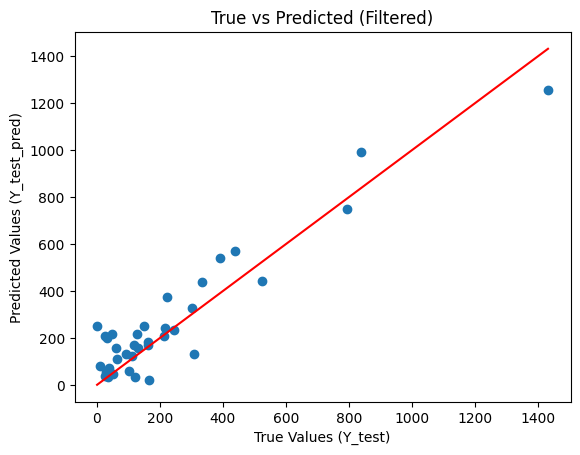

In [52]:

import matplotlib.pyplot as plt

plt.scatter(Y_test, x_pred_test)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_test = r2_score(Y_test, x_pred_test)
#print(f"R² Score: {r2_test}")
#print(max(abs(Y_test - x_pred_test)))
#print(np.argmax(abs(Y_test - x_pred_test)))


R² Score: 0.958997754417867
[357.95642604]
144
[674.46146144]


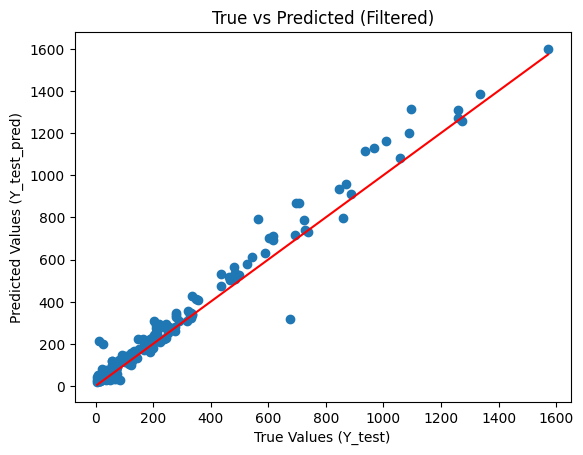

In [53]:
plt.scatter(Y_train, x_pred_train)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_train = r2_score(Y_train, x_pred_train)

print(f"R² Score: {r2_train}")
print(max(abs(Y_train - x_pred_train)))
print(np.argmax(abs(Y_train - x_pred_train)))
print(Y_train[144])



R² Score: 0.9450739059011289


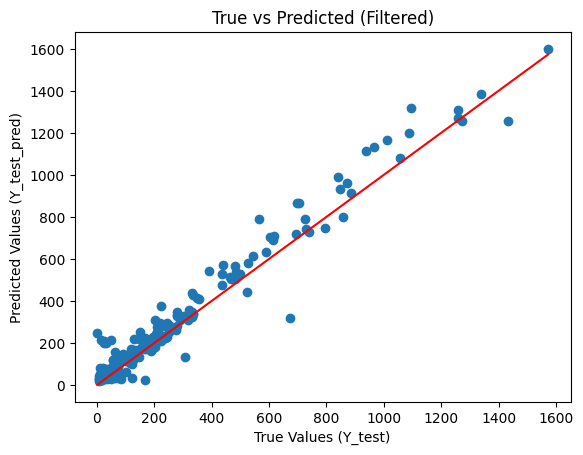

In [54]:
plt.scatter(final_y, x_pred_final)
plt.plot([min(final_y), max(final_y)], [min(final_y), max(final_y)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

print(f"R² Score: {r2_final}")